Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!


# CoronaVirus Prediction

### Number of Day to Predict 63

In [1]:
num_days_R_prediction=63

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=27 # =(6/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=52
#
## DROP_N=75 => 07/04
#
drop_n_dataset_days=75
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
236                           NaN                Thailand  15.870032   
237                           NaN             Timor-Leste  -8.874217   
238                           NaN                    Togo   8.619500   
239                           NaN     Trinidad and Tobago  10.691800   
240                           NaN                 Tunisia  33.886917   
241                           NaN                  Turkey  38.963700   
242                           NaN           United States  40.000000   
243                           NaN                  Uganda   1.373333   
244                           NaN                 Ukraine  48.379400   
245                           NaN    United Arab Emirates  23.424076   
246                      Anguilla          United Kingdom  18.220600   
247                       Bermuda          United Kingdom  32.307800   
248        British Virgin Islands          United Kingdom  18.420700   
249                Cayman Islands          United Kingdom  19.313300   
250               Channel Islands          United Kingdom  49.372300   
251   Falkland Islands (Malvinas)          United Kingdom -51.796300   
252                     Gibraltar          United Kingdom  36.140800   
253                   Isle of Man          United Kingdom  54.236100   
254                    Montserrat          United Kingdom  16.742498   
255      Turks and Caicos Islands          United Kingdom  21.694000   
256                           NaN          United Kingdom  55.378100   
257                           NaN                 Uruguay -32.522800   
258                           NaN              Uzbekistan  41.377491   
259                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
238                           NaN                Thailand  15.870032   
239                           NaN             Timor-Leste  -8.874217   
240                           NaN                    Togo   8.619500   
241                           NaN     Trinidad and Tobago  10.691800   
242                           NaN                 Tunisia  33.886917   
243                           NaN                  Turkey  38.963700   
244                           NaN           United States  40.000000   
245                           NaN                  Uganda   1.373333   
246                           NaN                 Ukraine  48.379400   
247                           NaN    United Arab Emirates  23.424076   
248                      Anguilla          United Kingdom  18.220600   
249                       Bermuda          United Kingdom  32.307800   
250        British Virgin Islands          United Kingdom  18.420700   
251                Cayman Islands          United Kingdom  19.313300   
252               Channel Islands          United Kingdom  49.372300   
253   Falkland Islands (Malvinas)          United Kingdom -51.796300   
254                     Gibraltar          United Kingdom  36.140800   
255                   Isle of Man          United Kingdom  54.236100   
256                    Montserrat          United Kingdom  16.742498   
257      Turks and Caicos Islands          United Kingdom  21.694000   
258                           NaN          United Kingdom  55.378100   
259                           NaN                 Uruguay -32.522800   
260                           NaN              Uzbekistan  41.377491   
261                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN     Mozambique -18.665695   35.529562   
186                               NaN        Namibia -22.957600   18.490400   
187                               NaN          Nepal  28.166700   84.250000   
188                             Aruba    Netherlands  12.521100  -69.968300   
189  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
190                           Curacao    Netherlands  12.169600  -68.990000   
191                      Sint Maarten    Netherlands  18.042500  -63.054800   
192                               NaN    Netherlands  52.132600    5.291300   
193                               NaN    New Zealand -40.900600  174.886000   
194                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  9/21/20  \
185        0        0        0        0        0        0  ...       44   
186        0        0        0        0        0        0  ...      113   
187        0        0        0        0        0        0  ...      427   
188        0        0        0        0        0        0  ...       24   
189        0        0        0        0        0        0  ...        1   
190        0        0        0        0        0        0  ...        1   
191        0        0        0        0        0        0  ...       20   
192        0        0        0        0        0        0  ...     6281   
193        0        0        0        0        0        0  ...       25   
194        0        0        0        0        0        0  ...      147   

     9/22/20  9/23/20  9/24/20  9/25/20  9/26/20  9/27/20  9/28/20  \
185       45       49       51       53       54       58       59   
186      116      117      119      119      120      120      121   
187      429      436      453      459      467      477      481   
188       25       25       25       25       25       25       25   
189        1        1        1        1        1        1        1   
190        1        1        1        1        1        1        1   
191       20       21       22       22       22       22       22   
192     6291     6296     6312     6328     6366     6366     6366   
193       25       25       25       25       25       25       25   
194      149      149      149      149      149      149      149   

      Population                                         region  
185           NaN                                Mozambique_nan  
186           NaN                                   Namibia_nan  
187    29,300,000                                     Nepal_nan  
188           NaN                             Netherlands_Aruba  
189           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
190           NaN                           Netherlands_Curacao  
191           NaN                      Netherlands_Sint Maarten  
192    17,180,000                               Netherlands_nan  
193     4,813,844                               New Zealand_nan  
194           NaN                                 Nicaragua_nan  

[10 rows x 257 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State   Country/Region        Lat        Long  \
175                             Aruba      Netherlands  12.521100  -69.968300   
176  Bonaire, Sint Eustatius and Saba      Netherlands  12.178400  -68.238500   
177                           Curacao      Netherlands  12.169600  -68.990000   
178                      Sint Maarten      Netherlands  18.042500  -63.054800   
179                               NaN      Netherlands  52.132600    5.291300   
180                               NaN      New Zealand -40.900600  174.886000   
181                               NaN        Nicaragua  12.865416  -85.207229   
182                               NaN            Niger  17.607789    8.081666   
183                               NaN          Nigeria   9.082000    8.675300   
184                               NaN  North Macedonia  41.608600   21.745300   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  9/21/20  \
175        0        0        0        0        0        0  ...     2369   
176        0        0        0        0        0        0  ...       17   
177        0        0        0        0        0        0  ...      102   
178        0        0        0        0        0        0  ...      505   
179        0        0        0        0        0        0  ...        0   
180        0        0        0        0        0        0  ...     1729   
181        0        0        0        0        0        0  ...     2913   
182        0        0        0        0        0        0  ...     1104   
183        0        0        0        0        0        0  ...    48674   
184        0        0        0        0        0        0  ...    13949   

     9/22/20  9/23/20  9/24/20  9/25/20  9/26/20  9/27/20  9/28/20  \
175     2426     2501     2664     2753     2829     2948     3037   
176       18       21       21       21       21       21       21   
177      103      104      115      124      134      141      148   
178      512      517      517      532      532      532      549   
179        0        0        0        0        0        0        0   
180     1737     1737     1744     1745     1749     1753     1755   
181     2913     2913     2913     2913     2913     2913     2913   
182     1104     1107     1107     1107     1107     1107     1110   
183    48836    48985    49098    49606    49722    49794    49895   
184    14084    14186    14312    14422    14516    14581    14642   

      Population                                         region  
175           NaN                             Netherlands_Aruba  
176           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
177           NaN                           Netherlands_Curacao  
178           NaN                      Netherlands_Sint Maarten  
179    17,180,000                               Netherlands_nan  
180     4,813,844                               New Zealand_nan  
181           NaN                                 Nicaragua_nan  
182    24,002,020                                     Niger_nan  
183           NaN                                   Nigeria_nan  
184     2,077,000                           North Macedonia_nan  

[10 rows x 257 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN     Mozambique -18.665695   35.529562   
186                               NaN        Namibia -22.957600   18.490400   
187                               NaN          Nepal  28.166700   84.250000   
188                             Aruba    Netherlands  12.521100  -69.968300   
189  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
190                           Curacao    Netherlands  12.169600  -68.990000   
191                      Sint Maarten    Netherlands  18.042500  -63.054800   
192                               NaN    Netherlands  52.132600    5.291300   
193                               NaN    New Zealand -40.900600  174.886000   
194                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  9/21/20  \
185        0        0        0        0        0        0  ...     6912   
186        0        0        0        0        0        0  ...    10526   
187        0        0        0        1        1        1  ...    65276   
188        0        0        0        0        0        0  ...     3587   
189        0        0        0        0        0        0  ...       36   
190        0        0        0        0        0        0  ...      282   
191        0        0        0        0        0        0  ...      591   
192        0        0        0        0        0        0  ...    95995   
193        0        0        0        0        0        0  ...     1815   
194        0        0        0        0        0        0  ...     4961   

     9/22/20  9/23/20  9/24/20  9/25/20  9/26/20  9/27/20  9/28/20  \
185     7114     7262     7399     7589     7757     7983     8288   
186    10607    10663    10740    10835    10918    11033    11121   
187    66632    67804    69301    70614    71821    73394    74745   
188     3665     3721     3756     3799     3832     3844     3872   
189       54       69       69       85       85       85       88   
190      291      301      315      329      337      360      364   
191      594      616      618      627      633      644      645   
192    98240   100597   103141   105918   108631   108631   110671   
193     1824     1827     1829     1831     1833     1833     1835   
194     5073     5073     5073     5073     5073     5073     5073   

      Population                                         region  
185           NaN                                Mozambique_nan  
186           NaN                                   Namibia_nan  
187    29,300,000                                     Nepal_nan  
188           NaN                             Netherlands_Aruba  
189           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
190           NaN                           Netherlands_Curacao  
191           NaN                      Netherlands_Sint Maarten  
192    17,180,000                               Netherlands_nan  
193     4,813,844                               New Zealand_nan  
194           NaN                                 Nicaragua_nan  

[10 rows x 257 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State Country/Region        Lat        Long  1/22/20  1/23/20  \
220            NaN     Seychelles  -4.679600   55.492000        0        0   
221            NaN   Sierra Leone   8.460555  -11.779889        0        0   
222            NaN      Singapore   1.283300  103.833300        0        1   
223            NaN       Slovakia  48.669000   19.699000        0        0   
224            NaN       Slovenia  46.151200   14.995500        0        0   
225            NaN        Somalia   5.152149   46.199616        0        0   
226            NaN   South Africa -30.559500   22.937500        0        0   
227            NaN    South Sudan   6.877000   31.307000        0        0   
228            NaN          Spain  40.463667   -3.749220        0        0   
229            NaN      Sri Lanka   7.873054   80.771797        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  9/21/20  9/22/20  9/23/20  \
220        0        0        0        0  ...      143      143      143   
221        0        0        0        0  ...     2168     2174     2183   
222        3        3        4        5  ...    57606    57627    57639   
223        0        0        0        0  ...     6756     6931     7269   
224        0        0        0        0  ...     4470     4558     4694   
225        0        0        0        0  ...     3465     3465     3465   
226        0        0        0        0  ...   661936   663282   665188   
227        0        0        0        0  ...     2649     2660     2664   
228        0        0        0        0  ...   671468   682267   693556   
229        0        0        0        1  ...     3299     3313     3324   

     9/24/20  9/25/20  9/26/20  9/27/20  9/28/20   Population   \
220      143      143      143      143      143           NaN   
221     2188     2199     2208     2215     2215           NaN   
222    57654    57665    57685    57700    57715     5,612,000   
223     7629     8048     8600     9078     9343     5,459,087   
224     4816     5007     5191     5350     5388     2,078,878   
225     3465     3465     3588     3588     3588           NaN   
226   667049   668529   669498   670766   671669    59,148,674   
227     2669     2676     2676     2686     2692           NaN   
228   704209   716481   716481   716481   748266    46,660,000   
229     3333     3345     3349     3360     3363    21,440,000   

               region  
220    Seychelles_nan  
221  Sierra Leone_nan  
222     Singapore_nan  
223      Slovakia_nan  
224      Slovenia_nan  
225       Somalia_nan  
226  South Africa_nan  
227   South Sudan_nan  
228         Spain_nan  
229     Sri Lanka_nan  

[10 rows x 257 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

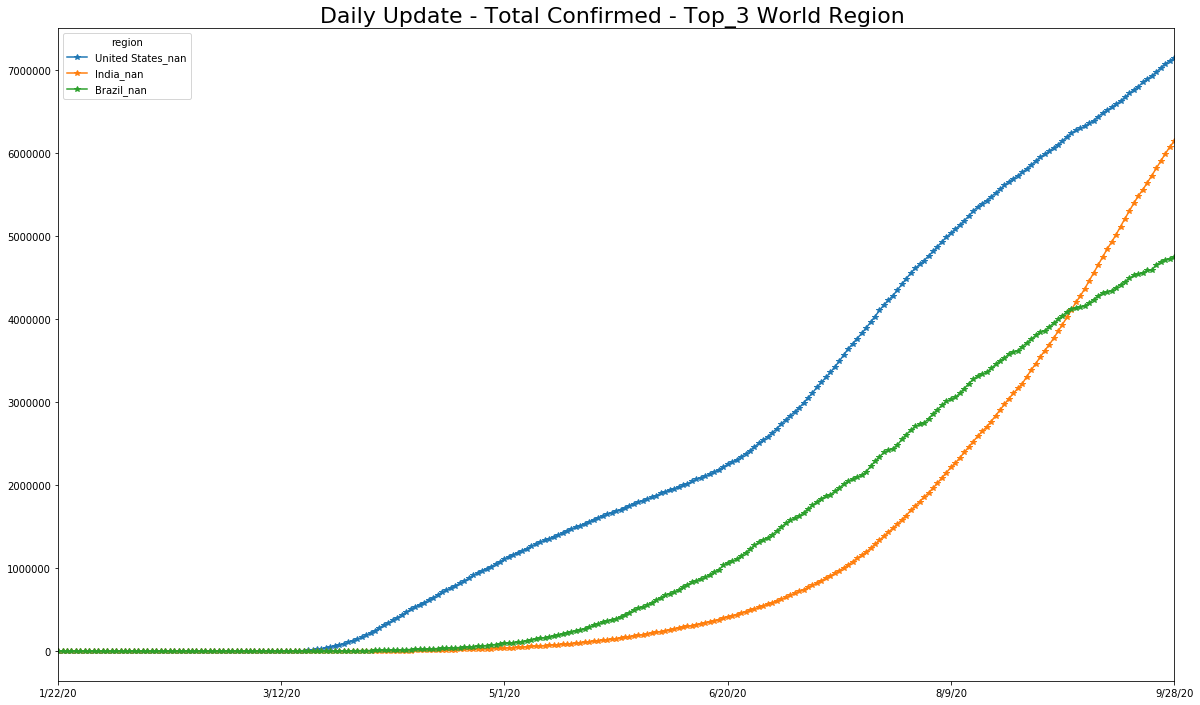

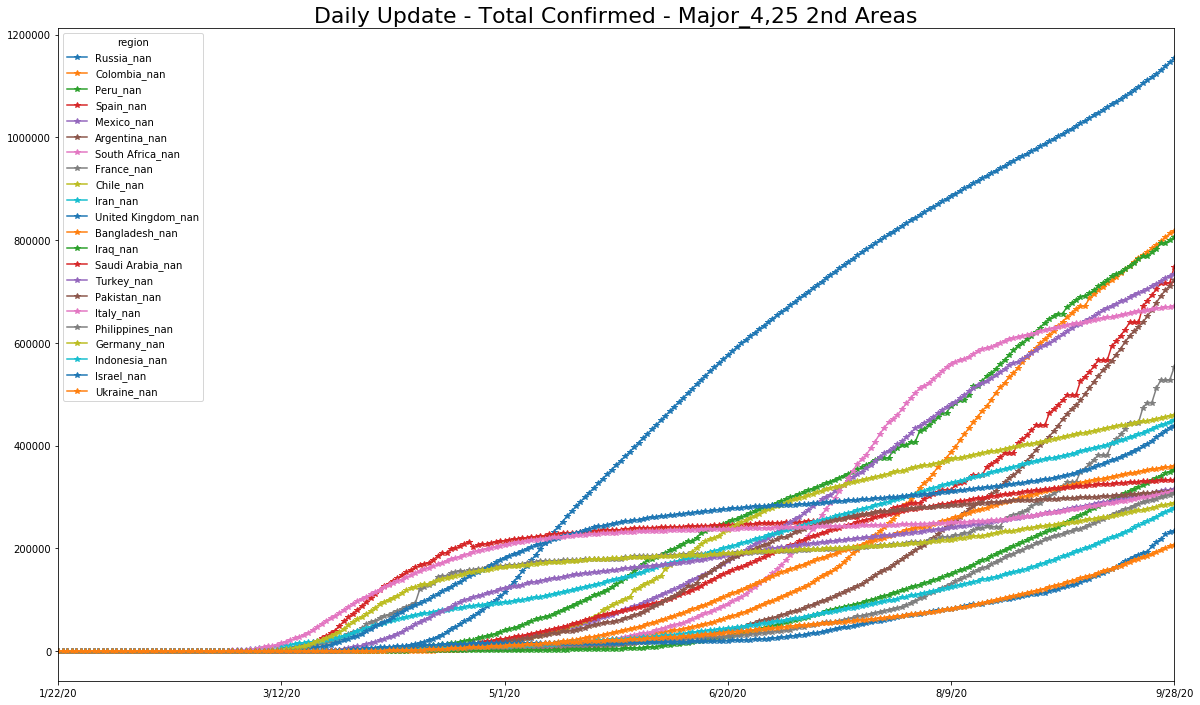

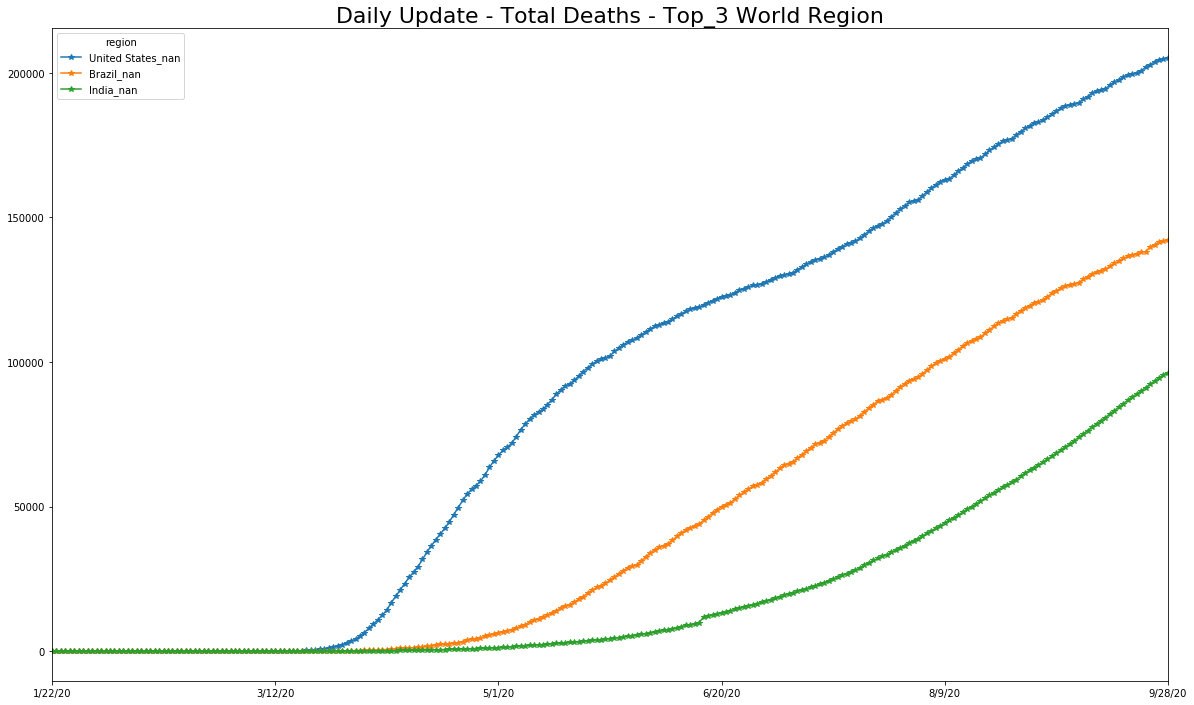

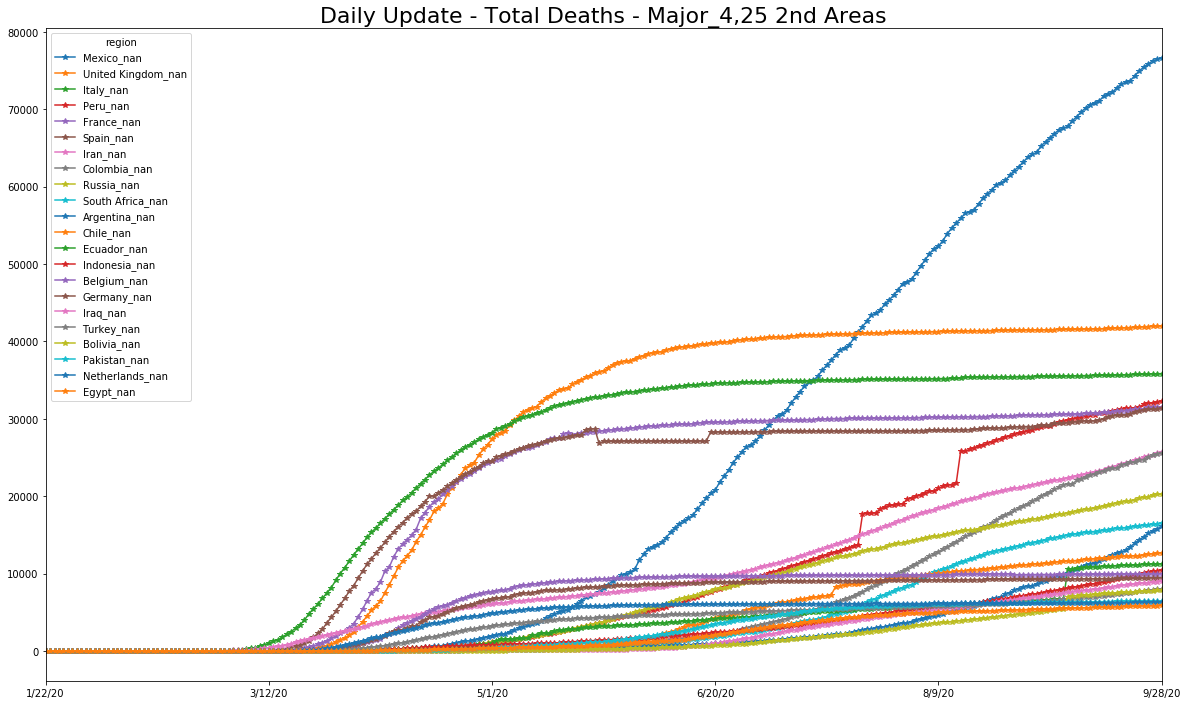

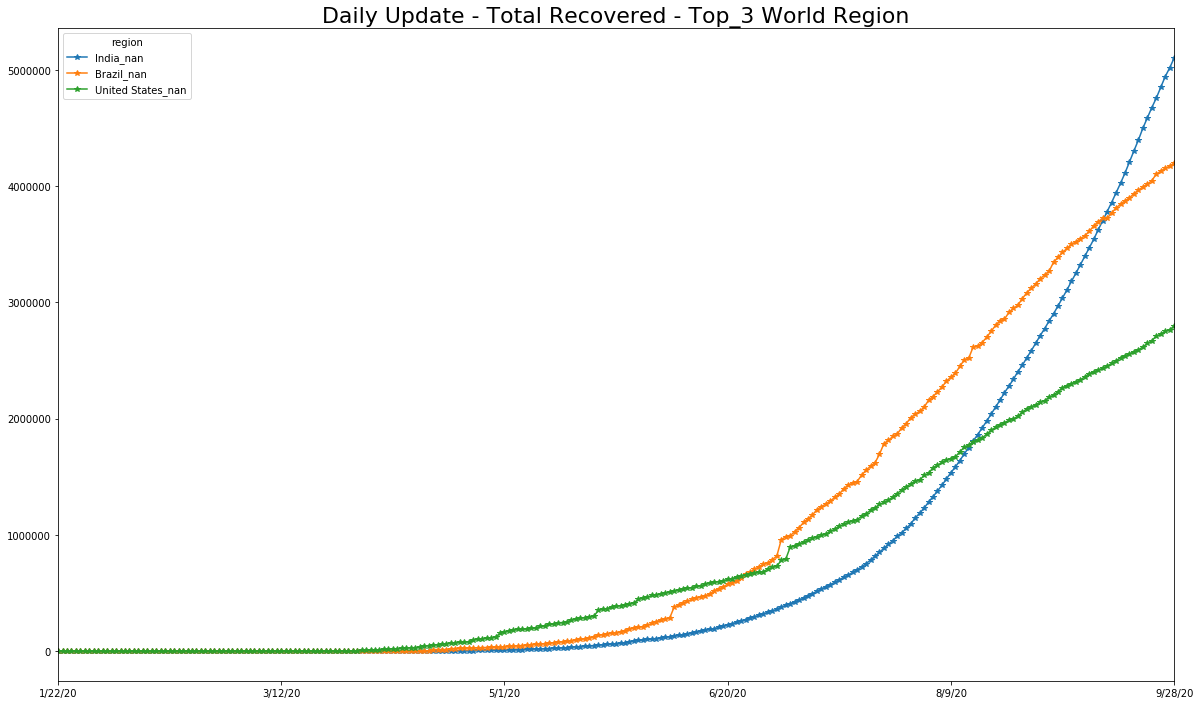

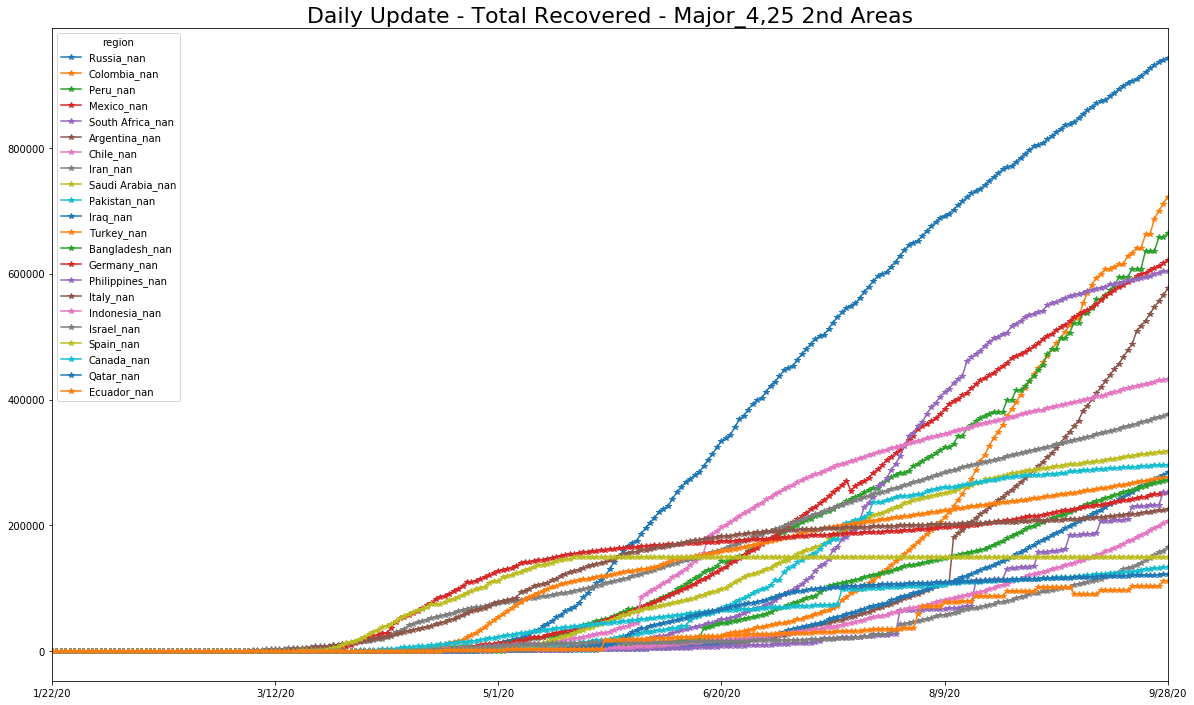

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime
#
#api_key="46f953cbca334ea1b85ab5d47dbc9aa0" # joao@fuelbigdata.com
api_key="27a4e12ebc7f41b2bd6e300015f1a090" # jpacerqueira.consult.bigdata@gmail.com
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/09/29


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region  Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
2/6/20                0            0            0            0           0   
2/7/20                0            0            0            0           0   
2/8/20                0            0            0            0           0   

region  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
2/6/20                        0              0            0   
2/7/20                        0              0            0   
2/8/20                        0              0            0   

region  Australia_Australian Capital Territory  Australia_New South Wales  \
2/6/20                                       0                          4   
2/7/20                                       0                          4   
2/8/20                                       0                          4   

region  ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Venezuela_nan  \
2/6/20  ...                 12            0               0              0   
2/7/20  ...                 12            0               0              0   
2/8/20  ...                 12            0               0              0   

region  Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
2/6/20           10                       0                   0          0   
2/7/20           10                       0                   0          0   
2/8/20           13                       0                   0          0   

region  Zambia_nan  Zimbabwe_nan  
2/6/20           0             0  
2/7/20           0             0  
2/8/20           0             0  

[3 rows x 266 columns]

In [24]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
9/25/20            39186        13045        50754         1836        4590   
9/26/20            39192        13153        50914         1836        4672   
9/27/20            39227        13259        51067         1836        4718   
9/28/20            39233        13391        51213         1966        4797   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
9/25/20                       98         691235        48643   
9/26/20                       98         702484        49072   
9/27/20                      101         711325        49400   
9/28/20                      101         723132        49574   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
9/25/20                                     113                       4218   
9/26/20                                     113                       4218   
9/27/20                                     113                       4218   
9/28/20                                     113                       4220   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Venezuela_nan  \
9/25/20  ...            7032712         1967           54392          71273   
9/26/20  ...            7078089         1998           54819          71940   
9/27/20  ...            7115008         2008           55320          72691   
9/28/20  ...            7148045         2010           55776          73528   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
9/25/20         1069                   37963                  10       2029   
9/26/20         1069                   38253                  10       2030   
9/27/20         1074                   38703                  10       2030   
9/28/20         1077                   39121                  10       2031   

region   Zambia_nan  Zimbabwe_nan  
9/25/20       14515          7787  
9/26/20       14612          7803  
9/27/20       14641          7812  
9/28/20       14660          7816  

[4 rows x 266 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: Parsed with column specification:
cols(
  .default = col_double(),
  date = col_date(format = "")
)

R[write to console]: See spec(...) for full column specifications.



In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
6899 2020-05-10  Vietnam_nan  26.9  33.0
6900 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
19    2020-02-25  Afghanistan_nan          1             1             1   
20    2020-02-26  Afghanistan_nan          1             0             1   
21    2020-02-27  Afghanistan_nan          1             0             1   
22    2020-02-28  Afghanistan_nan          1             0             0   
23    2020-02-29  Afghanistan_nan          1             0             0   
24    2020-03-01  Afghanistan_nan          1             0             0   
25    2020-03-02  Afghanistan_nan          1             0             0   
26    2020-03-03  Afghanistan_nan          1             0             0   
27    2020-03-04  Afghanistan_nan          1             0             0   
28    2020-03-05  Afghanistan_nan          1             0             0   
29    2020-03-06  Afghanistan_nan          1             0             0   
30    2020-03-07  Afghanistan_nan          1             0             0   
31    2020-03-08  Afghanistan_nan          4             0             0   
32    2020-03-09  Afghanistan_nan          4             3             3   
33    2020-03-10  Afghanistan_nan          5             0             3   
34    2020-03-11  Afghanistan_nan          7             1             4   
35    2020-03-12  Afghanistan_nan          7             2             3   
36    2020-03-13  Afghanistan_nan          7             0             3   
37    2020-03-14  Afghanistan_nan         11             0             2   
38    2020-03-15  Afghanistan_nan         16             4             4   
39    2020-03-16  Afghanistan_nan         21             5             9   
40    2020-03-17  Afghanistan_nan         22             5            14   
41    2020-03-18  Afghanistan_nan         22             1            11   
42    2020-03-19  Afghanistan_nan         22             0             6   
43    2020-03-20  Afghanistan_nan         24             0             1   
44    2020-03-21  Afghanistan_nan         24             2             2   
45    2020-03-22  Afghanistan_nan         40             0             2   
46    2020-03-23  Afghanistan_nan         40            16            18   
47    2020-03-24  Afghanistan_nan         74             0            16   
48    2020-03-25  Afghanistan_nan         84            34            50   
...          ...              ...        ...           ...           ...   
63486 2020-08-31     Zimbabwe_nan       6497             6           120   
63487 2020-09-01     Zimbabwe_nan       6559            85           109   
63488 2020-09-02     Zimbabwe_nan       6638            62           153   
63489 2020-09-03     Zimbabwe_nan       6678            79           226   
63490 2020-09-04     Zimbabwe_nan       6837            40           181   
63491 2020-09-05     Zimbabwe_nan       6837           159           278   
63492 2020-09-06     Zimbabwe_nan       6837             0           199   
63493 2020-09-07     Zimbabwe_nan       7298             0           159   
63494 2020-09-08     Zimbabwe_nan       7388           461           461   
63495 2020-09-09     Zimbabwe_nan       7429            90           551   
63496 2020-09-10     Zimbabwe_nan       7453            41           592   
63497 2020-09-11     Zimbabwe_nan       7479            24           155   
63498 2020-09-12     Zimbabwe_nan       7508            26            91   
63499 2020-09-13     Zimbabwe_nan       7526            29            79   
63500 2020-09-14     Zimbabwe_nan       7531            18            73   
63501 2020-09-15     Zimbabwe_nan       7576             5            52   
63502 2020-09-16     Zimbabwe_nan       7598            45            68   
63503 2020-09-17     Zimbabwe_nan       7633            22            72   
63504 2020-09-18     Zimbabwe_nan       7647            35           102   
63505 2020-09-19     Zimbabwe_nan       7672            14            71   
63506 2020-09-20     Zimbabwe_nan       7683            25  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
63515 2020-09-29  Zimbabwe_nan          0             4            29   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
63515           133         100.051331         100.372544         101.731225   

       last_day  kalman_prediction  population  infected_rate  min  max  
63515      7816             7844.0    14862924       0.000005  NaN  NaN

In [39]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
63513  2020-09-27  Zimbabwe_nan       7812            16            78   
63514  2020-09-28  Zimbabwe_nan       7816             9            60   
63515  2020-09-29  Zimbabwe_nan          0             4            29   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
63513           131         100.205599         101.009838         101.707638   
63514           129         100.115468         100.774123         101.679162   
63515           133         100.051331         100.372544         101.731225   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
63513                 7803  ...    14862924       0.000005  NaN  NaN   
63514                 7812  ...    14862924       0.000005  NaN  NaN   
63515                 7816  ...    14862924       0.000005  NaN  NaN   

       population_percentage : infected_rate confirmed  \
63513                                         0.000525   
63514                                         0.000526   
63515                                         0.000526   

       population_percentage : factor 9/10 infected_rate confirmed  \
63513                                           0.005251             
63514                                           0.005257             
63515                                           0.005259             

       delta : new_cases  delta : new_cases per 1M hab  \
63513               17.0                      1.143786   
63514               25.0                      1.682038   
63515               28.0                      1.883882   

       delta : roling 7day AVG  \
63513                18.714286   
63514                18.428571   
63515                19.000000   

       delta : aprox 14-day case notification rate per 100k hab  
63513                                           1.762776         
63514                                           1.735863         
63515                                           1.789688         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse           rmse          mae
256  United States_nan  2.196112e+11  468626.881511  36283.45339


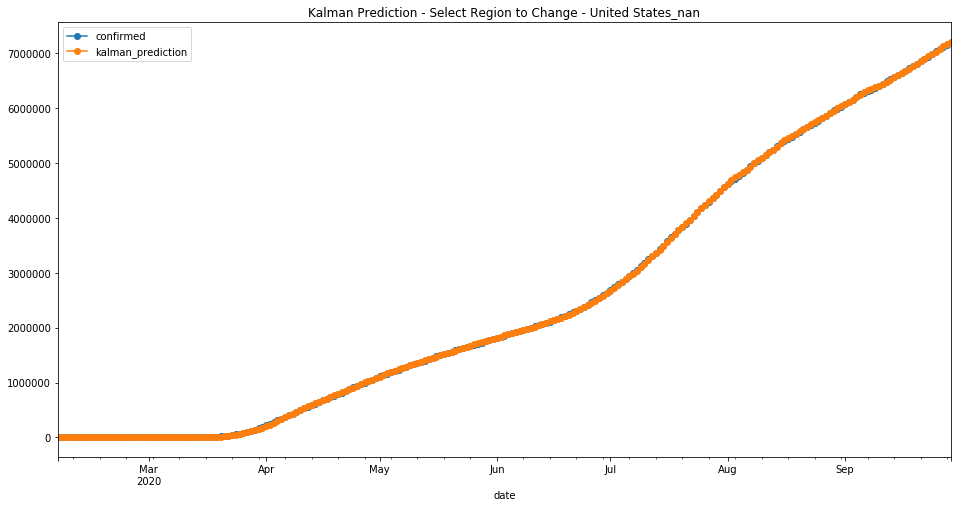

In [40]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse          mae
208  Russia_nan  5.706859e+09  75543.752577  5515.927966


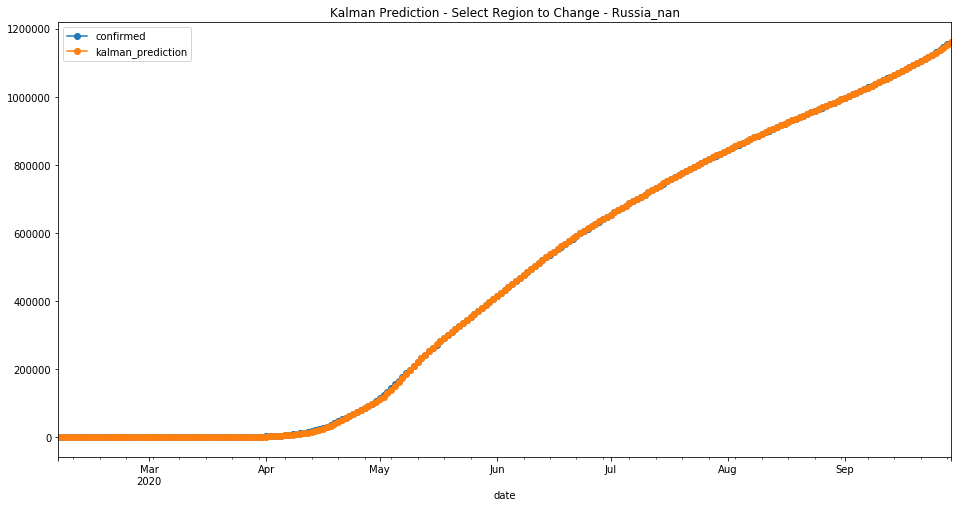

In [41]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  9.709625e+10  311602.716297  28398.639831


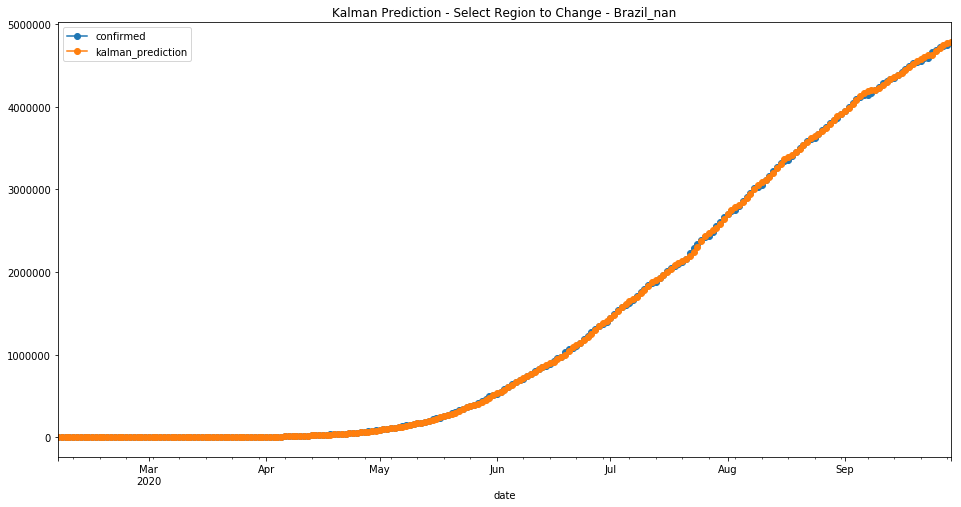

In [42]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse        rmse          mae
255  United Kingdom_nan  8.427326e+08  29029.8574  2455.940678


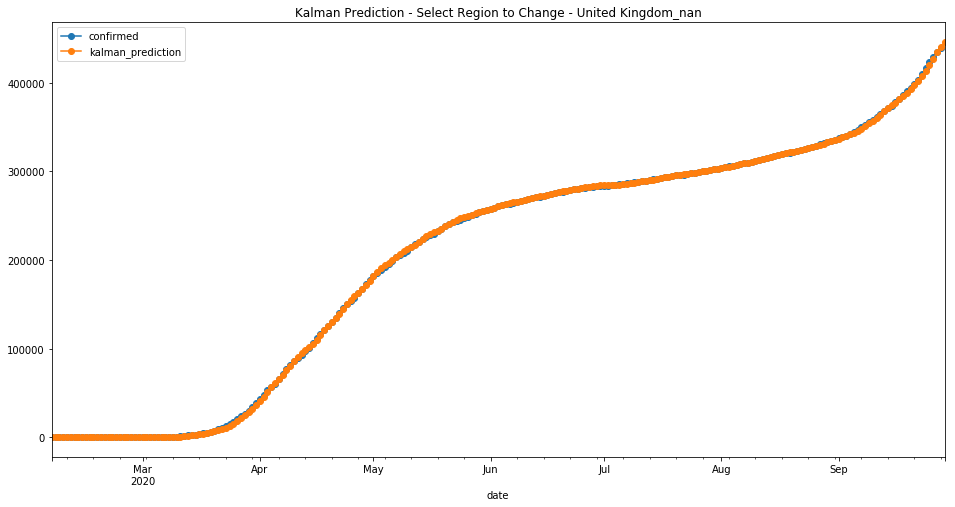

In [43]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [44]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='5G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.8" 2020-07-14; OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp4b_1j927
  JVM stdout: /tmp/tmp4b_1j927/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp4b_1j927/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    1 year, 11 months and 2 days !!!
H2O cluster name:           H2O_from_python_unknownUser_4s11tx
H2O cluster total nodes:    1
H2O cluster free memory:    5 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.3 final
--------------------------  ----------------------------------------

In [45]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-09-02
last_train_date= 2020-09-28
first_bootstrap_date= 2020-09-20
boost_bootstrap_date= 2020-09-25
first_test_date= 2020-09-19
last_test_date= 2020-09-29
first_valid_date= 2020-09-27


In [46]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [47]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [48]:
pred2.iloc[:25]

0  confirmed       date           region
0   38976.0      39044 2020-09-20  Afghanistan_nan
1   39126.0      39074 2020-09-21  Afghanistan_nan
2   39117.0      39096 2020-09-22  Afghanistan_nan
3   39119.0      39145 2020-09-23  Afghanistan_nan
4   39195.0      39170 2020-09-24  Afghanistan_nan
5   39220.0      39186 2020-09-25  Afghanistan_nan
6   39237.0      39192 2020-09-26  Afghanistan_nan
7   39243.0      39227 2020-09-27  Afghanistan_nan
8   39255.0      39233 2020-09-28  Afghanistan_nan
9   39256.0          0 2020-09-29  Afghanistan_nan
10  12375.0      12385 2020-09-20      Albania_nan
11  12533.0      12535 2020-09-21      Albania_nan
12  12670.0      12666 2020-09-22      Albania_nan
13  12793.0      12787 2020-09-23      Albania_nan
14  12911.0      12921 2020-09-24      Albania_nan
15  13055.0      13045 2020-09-25      Albania_nan
16  13182.0      13153 2020-09-26      Albania_nan
17  13275.0      13259 2020-09-27      Albania_nan
18  13371.0      13391 2020-09-28      Albania_nan
19  13508.0          0 2020-09-29      Albania_nan
20  49867.0      49826 2020-09-20      Algeria_nan
21  50065.0      50023 2020-09-21      Algeria_nan
22  50256.0      50214 2020-09-22      Algeria_nan
23  50440.0      50400 2020-09-23      Algeria_nan
24  50618.0      50579 2020-09-24      Algeria_nan

In [49]:
pred2.iloc[175:195]

0  confirmed       date          region
175  39816.0      39787 2020-09-25  Azerbaijan_nan
176  39890.0      39895 2020-09-26  Azerbaijan_nan
177  39988.0      40023 2020-09-27  Azerbaijan_nan
178  40124.0      40061 2020-09-28  Azerbaijan_nan
179  40135.0          0 2020-09-29  Azerbaijan_nan
180   3239.0       3315 2020-09-20     Bahamas_nan
181   3403.0       3418 2020-09-21     Bahamas_nan
182   3495.0       3467 2020-09-22     Bahamas_nan
183   3528.0       3618 2020-09-23     Bahamas_nan
184   3720.0       3699 2020-09-24     Bahamas_nan
185   3779.0       3790 2020-09-25     Bahamas_nan
186   3880.0       3790 2020-09-26     Bahamas_nan
187   3870.0       3838 2020-09-27     Bahamas_nan
188   3915.0       3838 2020-09-28     Bahamas_nan
189   3899.0          0 2020-09-29     Bahamas_nan
190  65080.0      65039 2020-09-20     Bahrain_nan
191  65572.0      65752 2020-09-21     Bahrain_nan
192  66367.0      66402 2020-09-22     Bahrain_nan
193  67017.0      67014 2020-09-23     Bahrain_nan
194  67522.0      67701 2020-09-24     Bahrain_nan

In [50]:
pred2.iloc[220:240]

0  confirmed       date       region
220   75634.0      75674 2020-09-20  Belarus_nan
221   75840.0      75898 2020-09-21  Belarus_nan
222   76077.0      76104 2020-09-22  Belarus_nan
223   76286.0      76357 2020-09-23  Belarus_nan
224   76555.0      76651 2020-09-24  Belarus_nan
225   76871.0      76957 2020-09-25  Belarus_nan
226   77173.0      77289 2020-09-26  Belarus_nan
227   77517.0      77609 2020-09-27  Belarus_nan
228   77849.0      77946 2020-09-28  Belarus_nan
229   78203.0          0 2020-09-29  Belarus_nan
230  101711.0     102295 2020-09-20  Belgium_nan
231  103518.0     103392 2020-09-21  Belgium_nan
232  104641.0     105226 2020-09-22  Belgium_nan
233  106929.0     106887 2020-09-23  Belgium_nan
234  108710.0     108768 2020-09-24  Belgium_nan
235  110314.0     110976 2020-09-25  Belgium_nan
236  112650.0     112803 2020-09-26  Belgium_nan
237  114501.0     114179 2020-09-27  Belgium_nan
238  115657.0     115353 2020-09-28  Belgium_nan
239  116982.0          0 2020-09-29  Belgium_nan

In [51]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [52]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  84328211.95200396
# MSE on the validation data =  962020021281.8882
# R^2 on the training data =  0.9998712376669042
# R^2 on the validation data =  0.48331068986810843


In [53]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1601398198935_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 84328211.95200396
RMSE: 9183.039363522512
MAE: 1187.225304814902
RMSLE: 0.2926057785072692
Mean Residual Deviance: 84328211.95200396

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 962020021281.8882
RMSE: 980826.1932074857
MAE: 229966.33388902055
RMSLE: 6.688506120503577
Mean Residual Deviance: 962020021281.8882
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2020-09-29 16:50:07  0.096 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2020-09-29 16:50:08  0.628 sec   1.0                35184.76678908712   5024.799234076375   1237967814.0024483   987125.5344790847   226978.7102248733   974416820820.6185
     2020-09-29 16:50:08  0.806 sec   2.0                23810.644628661594  4358.754985088441   566946797.6324112    1001351.3114048516  230244.7423260663   1002704448852.2161
     2020-09-29 16:50:08  1.252 sec   3.0                26459.62694885581   4389.384795433865   700111858.2726166    978122.0874578443   226531.71328212981  956722817972.8909
     2020-09-29 16:50:08  1.364 sec   4.0                25347.871017924273  4093.1211390993944  642514565.1413254    980789.867790253    227041.12425850533  961948764760.022
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2020-09-29 16:50:19  12.173 sec  174.0              10130.904717857864  1334.487031366877   102635230.40231474   977082.9935142937   229946.79119458646  954691176214.8533
     2020-09-29 16:50:23  16.188 sec  258.0              9756.373210734046   1251.0829476347506  95186818.22712895    979773.2939740877   230150.534424503    959955707584.834
     2020-09-29 16:50:27  20.245 sec  344.0              10266.574449295056  1242.679072808373   105402550.92291808   977930.4440505215   229923.46986756581  956347953400.8502
     2020-09-29 16:50:31  24.247 sec  428.0              9480.964661867674   1215.3962544695041  89888690.91958363    979375.1031096834   229760.7582451173   959175592591.1029
     2020-09-29 16:50:34  27.581 sec  500.0              9183.039363522512   1187.225304814902   84328211.95200396    980826.1932074857   229966.33388902055  962020021281.8882


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
last_day           9.87288e+17            1                    0.358531
kalman_prediction  7.9632e+17             0.806573             0.289181
7_day_change       4.04666e+17            0.409877             0.146954
3_day_change       2.27266e+17            0.230193             0.0825312
1_day_change       1.97241e+17            0.19978              0.0716274
infected_rate      5.33892e+16            0.0540766            0.0193881
region             4.90166e+16            0.0496477            0.0178002
1_day_change_rate  2.06755e+16            0.0209417            0.00750824
3_day_change_rate  5.75178e+15            0.00582583           0.00208874
max                4.45294e+15            0.00451027           0.00161707
7_day_change_rate  4.3949e+15             0.00445149           0.001596
min                3.24135e+15            0.00328308           0.00117709

In [54]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0            last_day         9.872879e+17           1.000000    0.358531
1   kalman_prediction         7.963199e+17           0.806573    0.289181
2        7_day_change         4.046664e+17           0.409877    0.146954
3        3_day_change         2.272663e+17           0.230193    0.082531
4        1_day_change         1.972405e+17           0.199780    0.071627
5       infected_rate         5.338917e+16           0.054077    0.019388
6              region         4.901658e+16           0.049648    0.017800
7   1_day_change_rate         2.067546e+16           0.020942    0.007508
8   3_day_change_rate         5.751776e+15           0.005826    0.002089
9                 max         4.452936e+15           0.004510    0.001617
10  7_day_change_rate         4.394899e+15           0.004451    0.001596
11                min         3.241348e+15           0.003283    0.001177

In [55]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


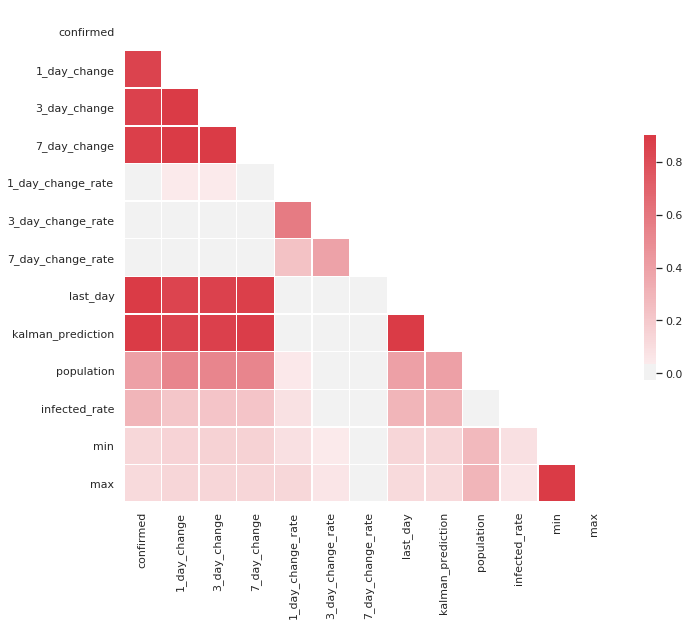

In [56]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [57]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.849872
3_day_change         0.863689
7_day_change         0.874651
1_day_change_rate    0.031409
3_day_change_rate    0.005863
7_day_change_rate   -0.009219
last_day             0.988162
kalman_prediction    0.988225
population           0.396807
infected_rate        0.297925
min                  0.134188
max                  0.114340
Name: confirmed, dtype: float64


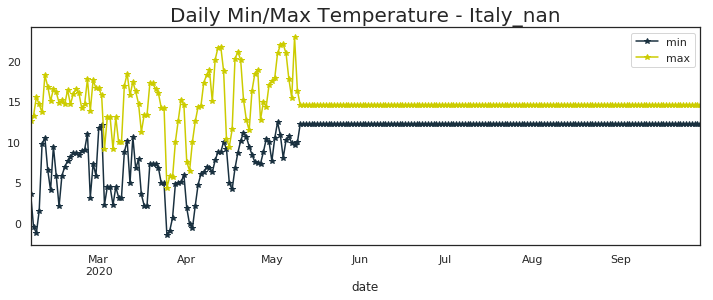

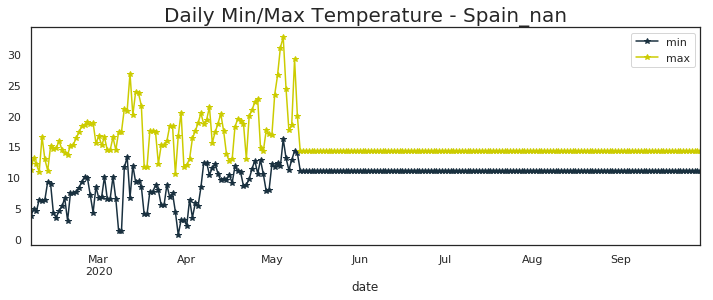

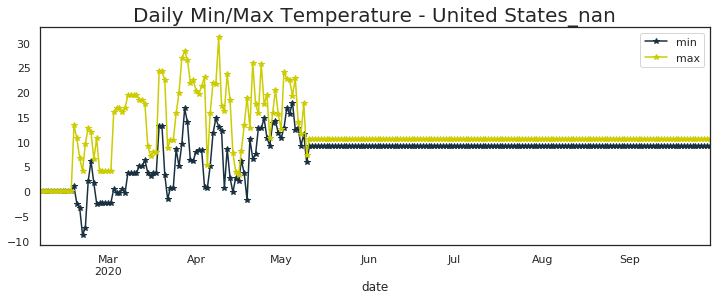

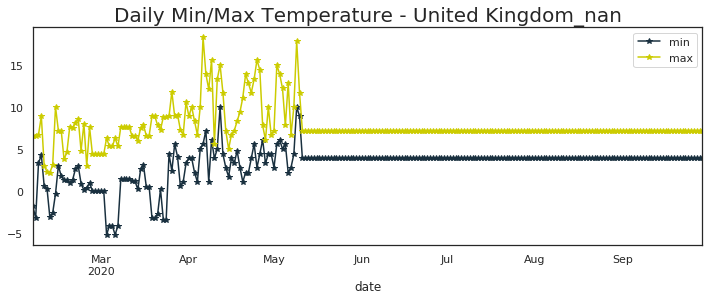

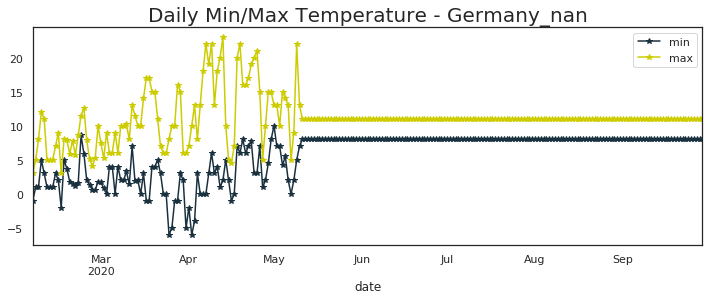

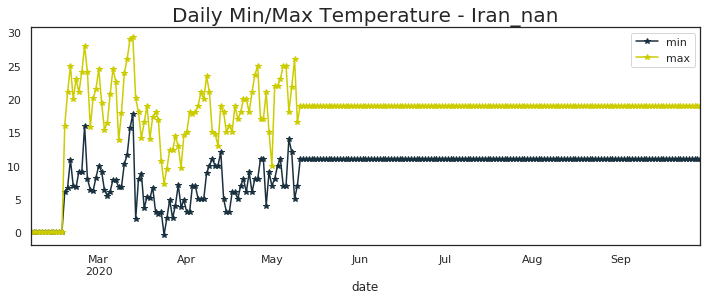

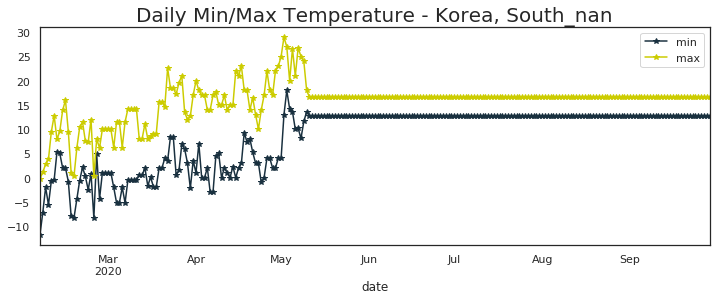

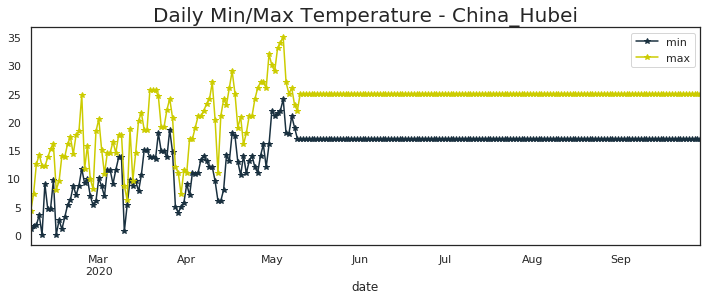

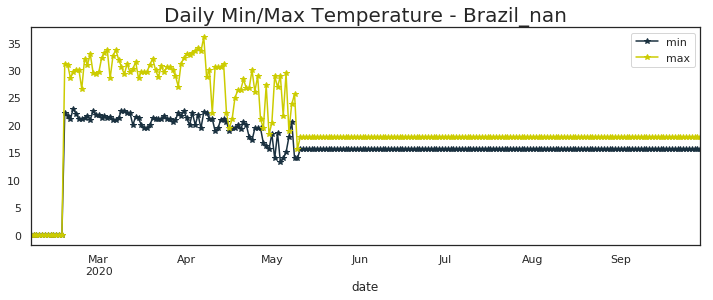

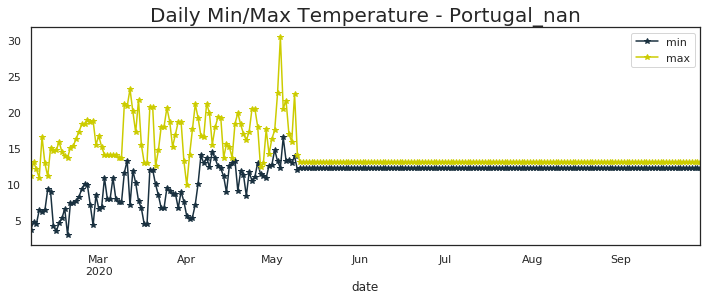

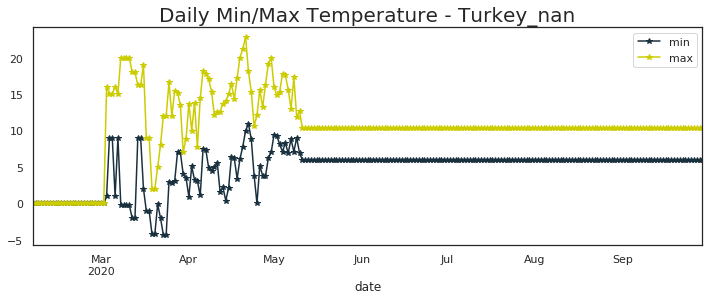

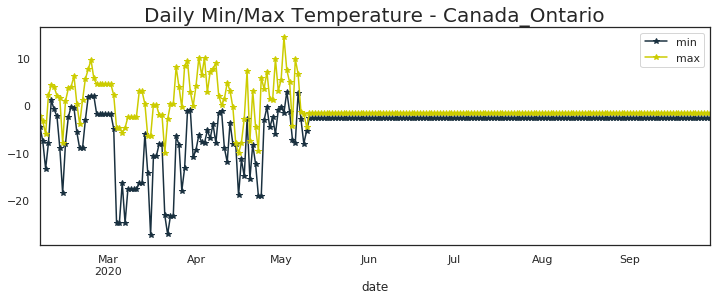

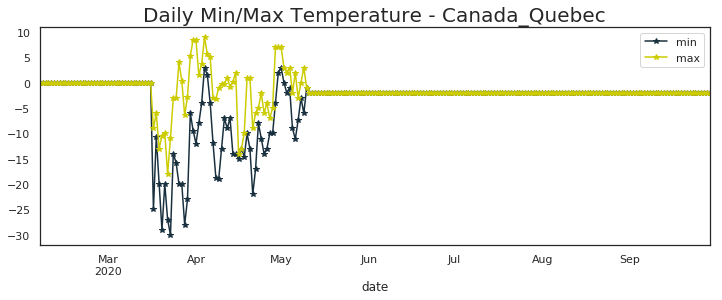

In [58]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [59]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           17.9  31.1
India_nan                   30.0  43.0
Brazil_nan                  23.0  36.0
Russia_nan                  13.0  30.0
Colombia_nan                 0.0   0.0
Peru_nan                     0.0   0.0
Spain_nan                   16.2  32.7
Mexico_nan                   0.0   0.0
Argentina_nan                0.0   0.0
South Africa_nan             0.0   0.0
France_nan                  14.2  23.8
Chile_nan                    0.0   0.0
Iran_nan                    17.8  29.3
United Kingdom_nan          10.0  18.3
Bangladesh_nan               0.0   0.0
Iraq_nan                    21.2  29.1
Saudi Arabia_nan             0.0   0.0
Turkey_nan                  10.9  22.8
Pakistan_nan                16.0  28.0
Italy_nan                   12.4  22.9
Philippines_nan             27.8  35.0
Germany_nan                 10.0  23.0
Indonesia_nan               

### Kalman X Days Ahead Prediction

In [60]:
%%R

#install.packages('reshape')

NULL


In [61]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

cols(
  .default = col_double(),
  date = col_date(format = "")
)




In [62]:
all_new=%R all_new

In [63]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

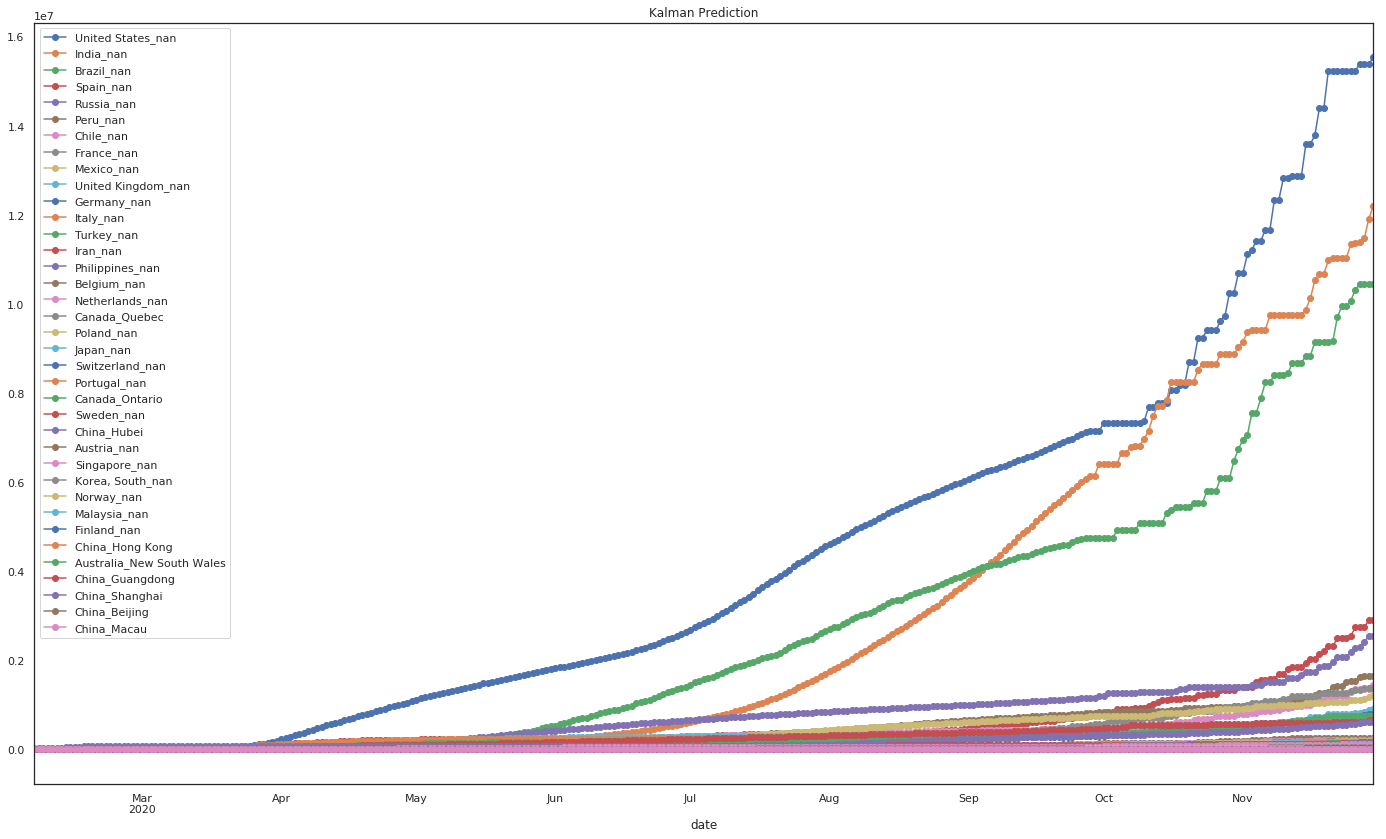

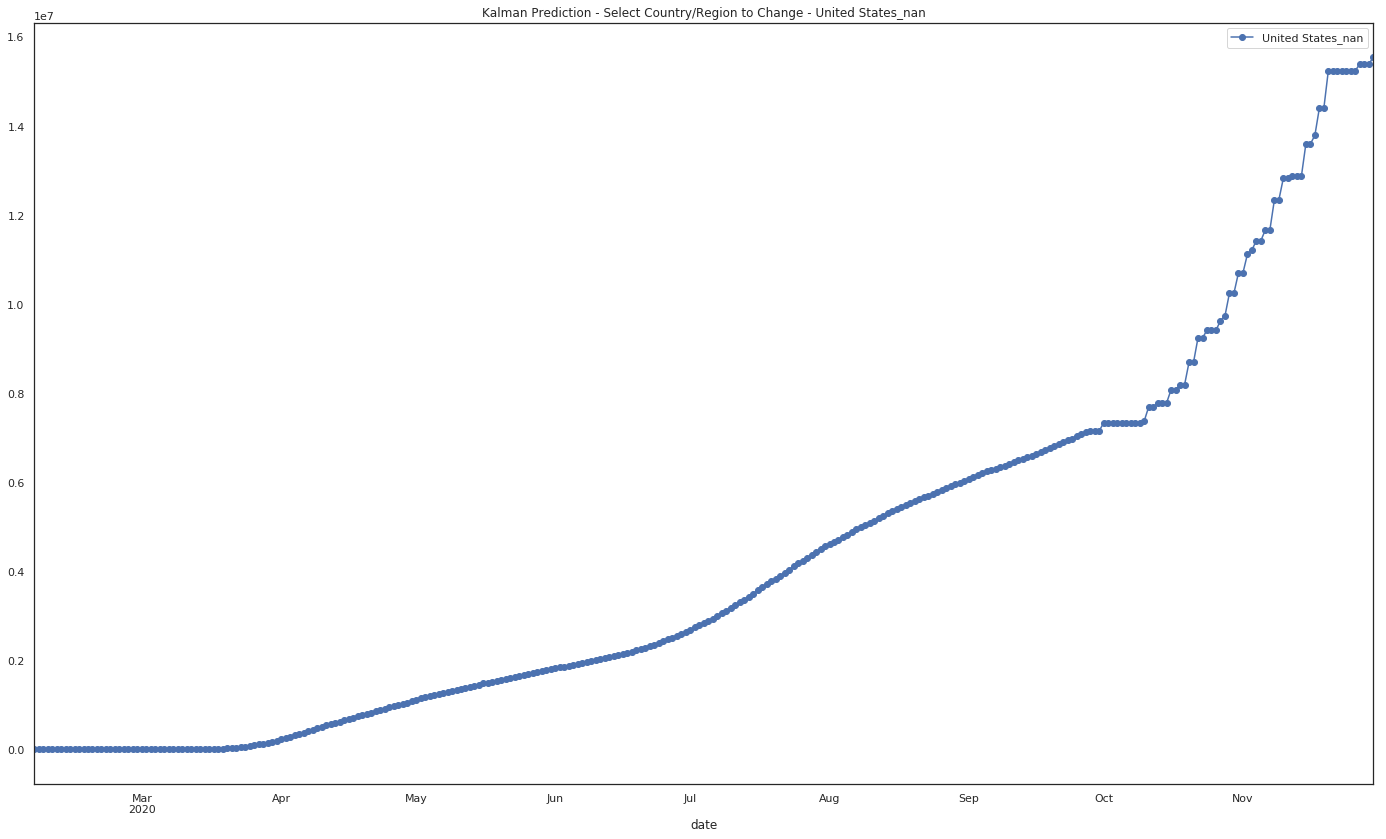

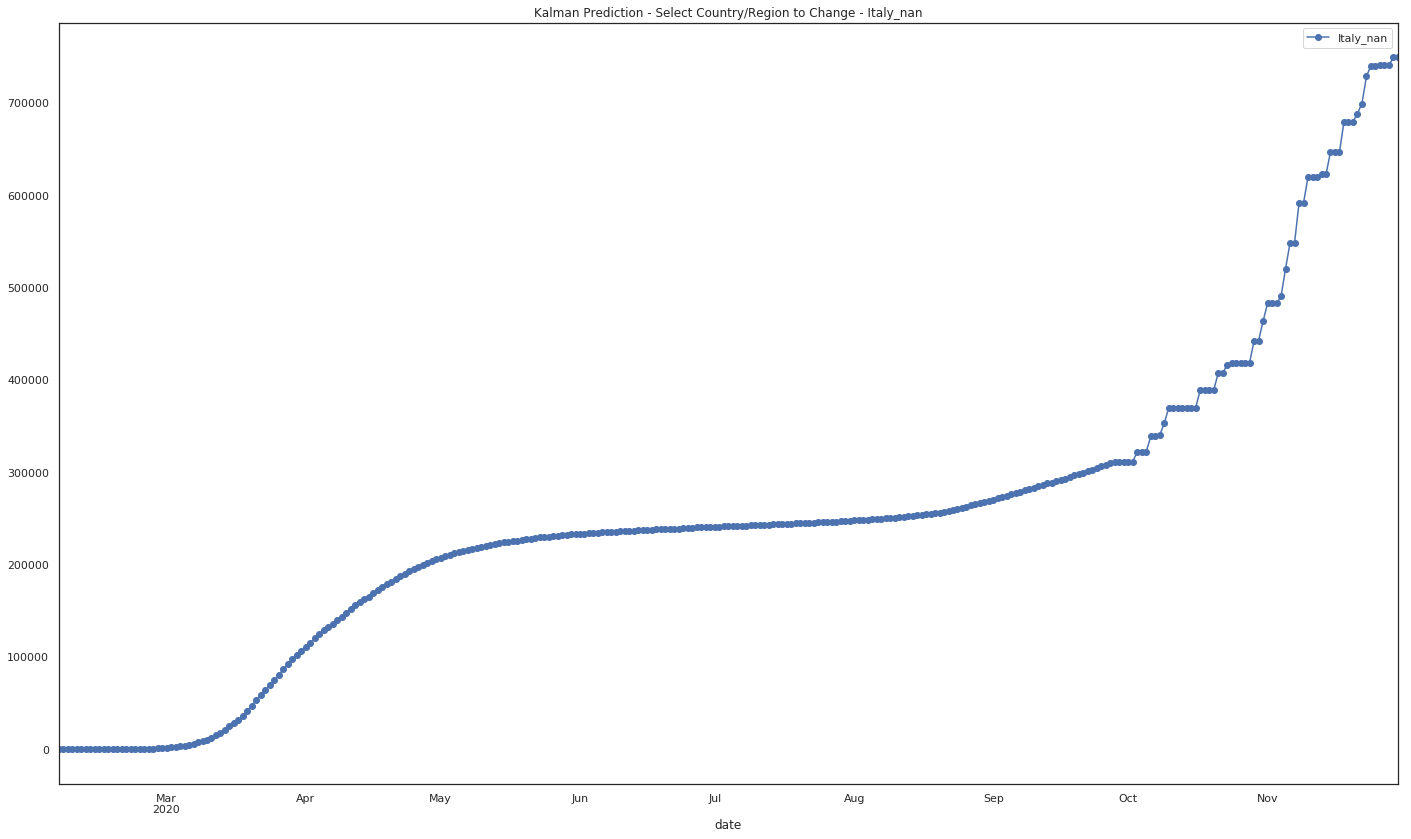

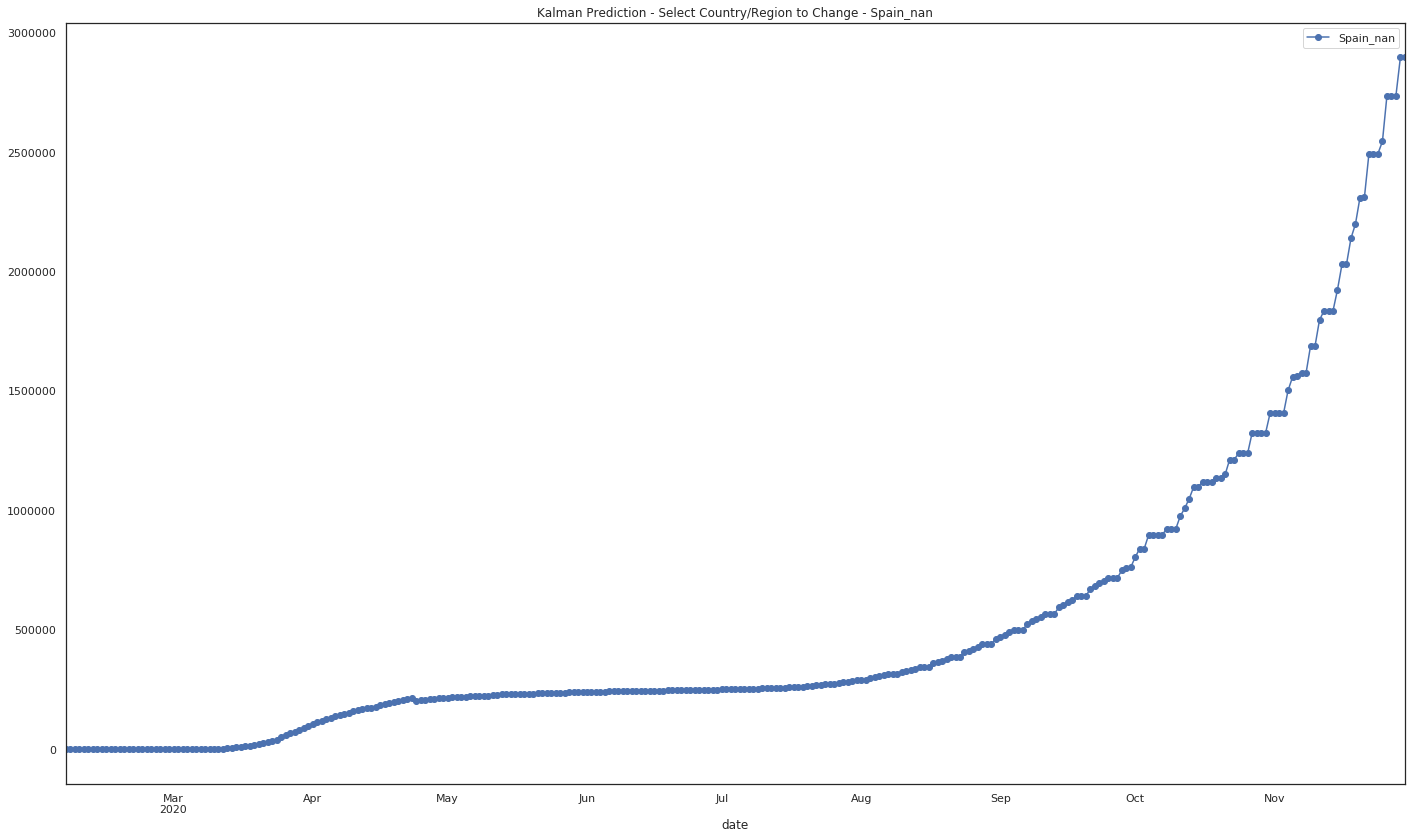

In [64]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


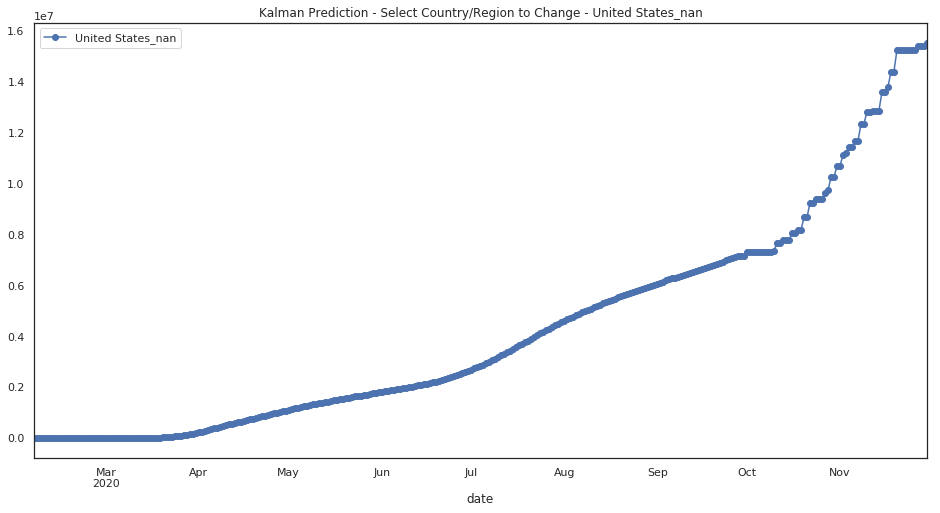

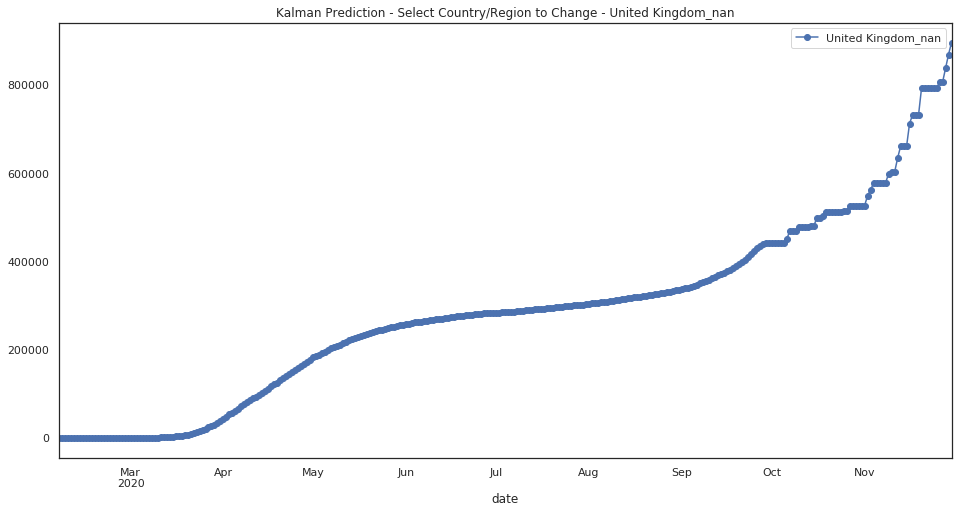

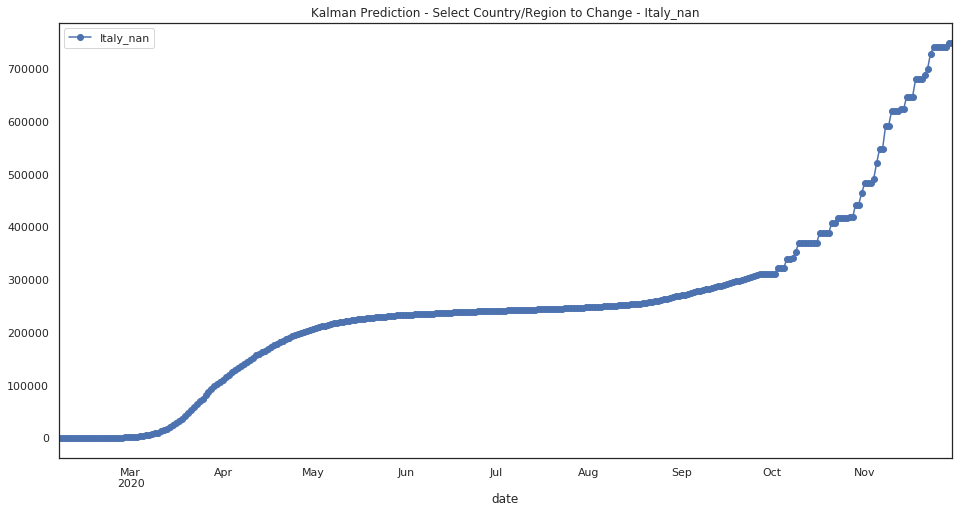

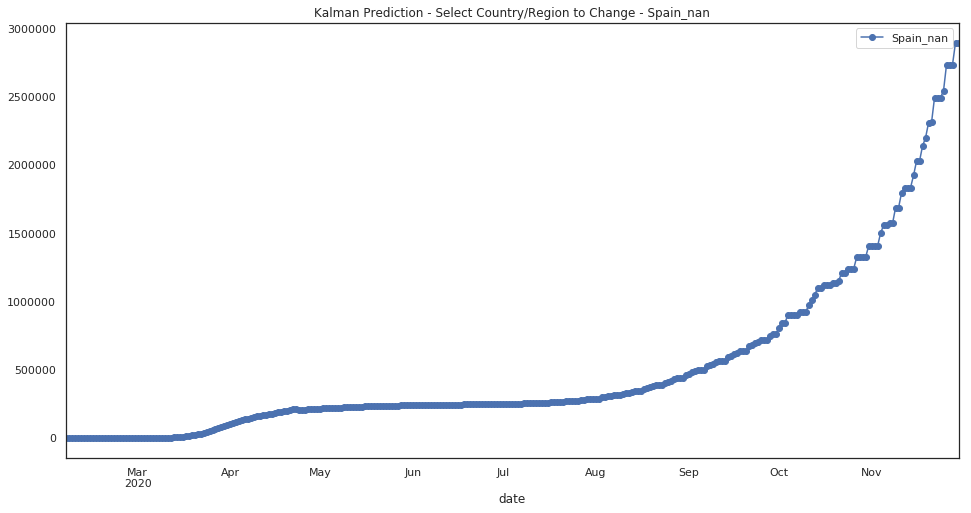

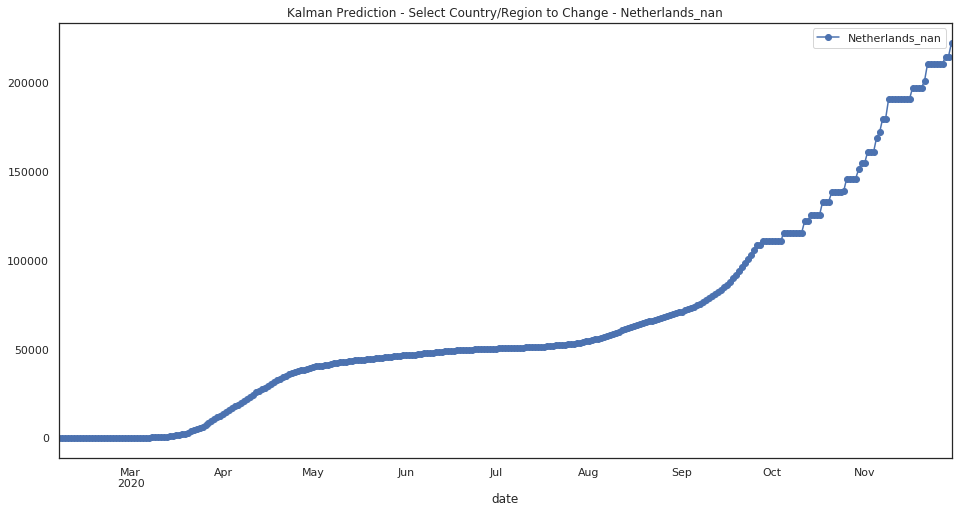

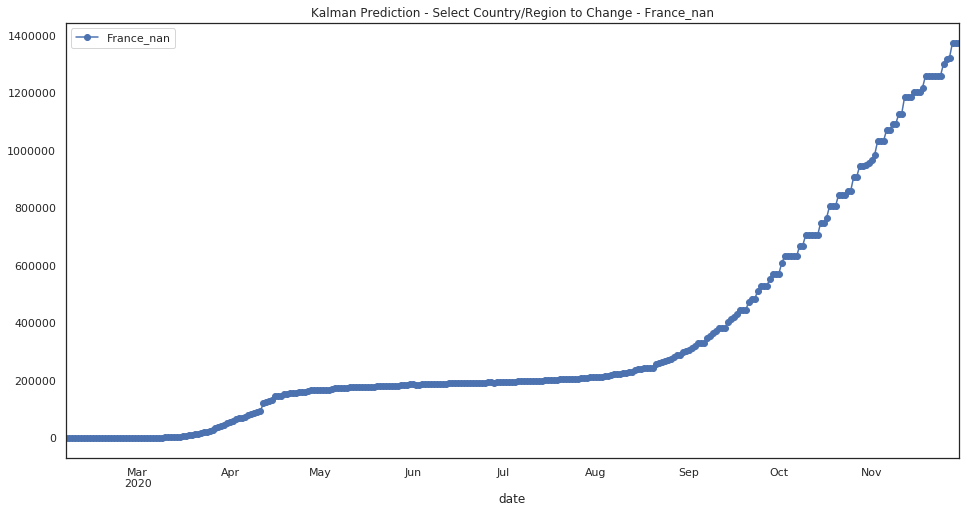

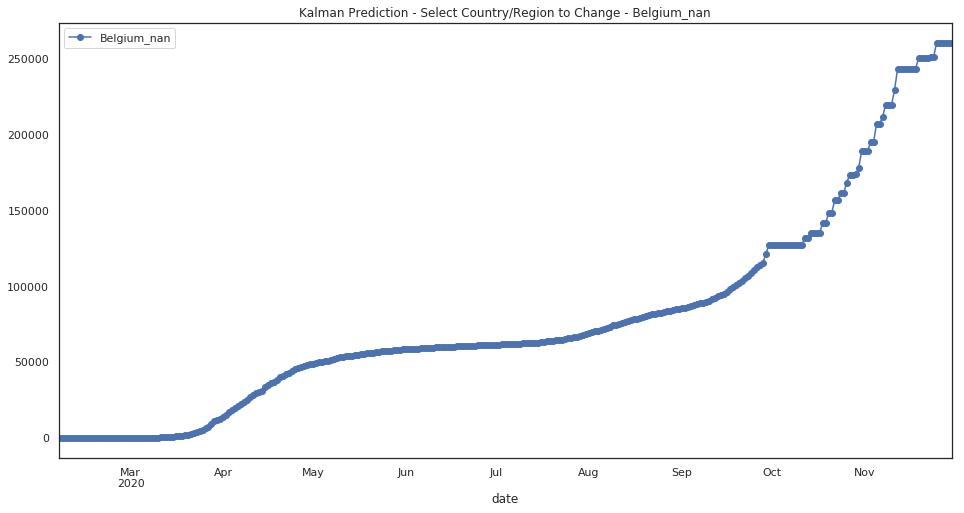

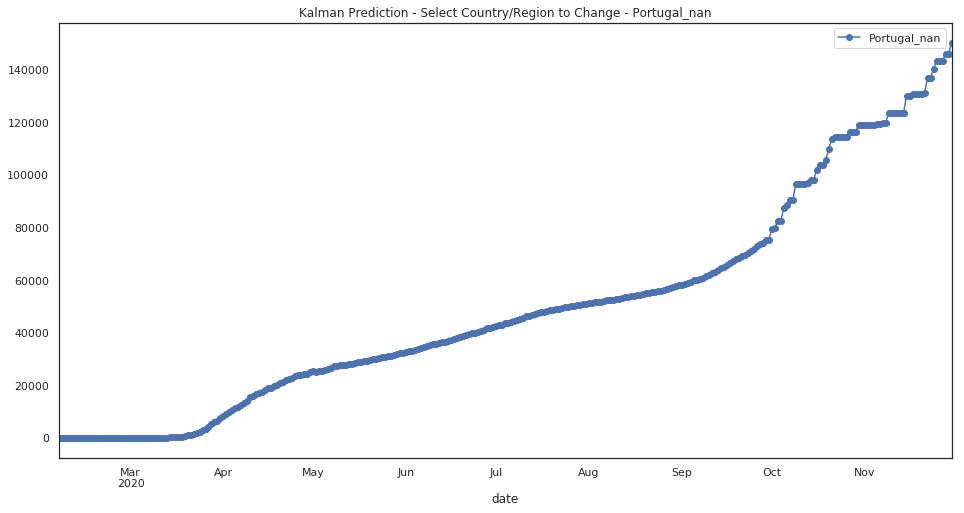

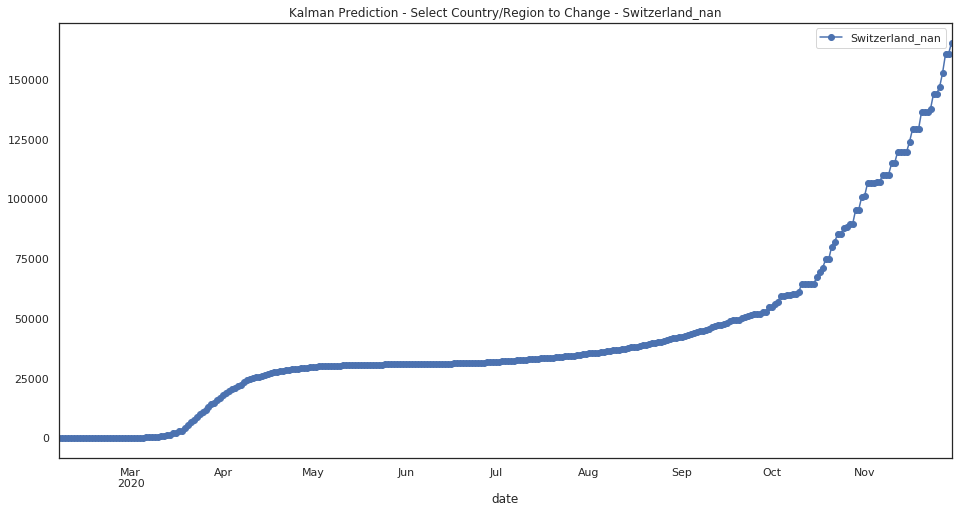

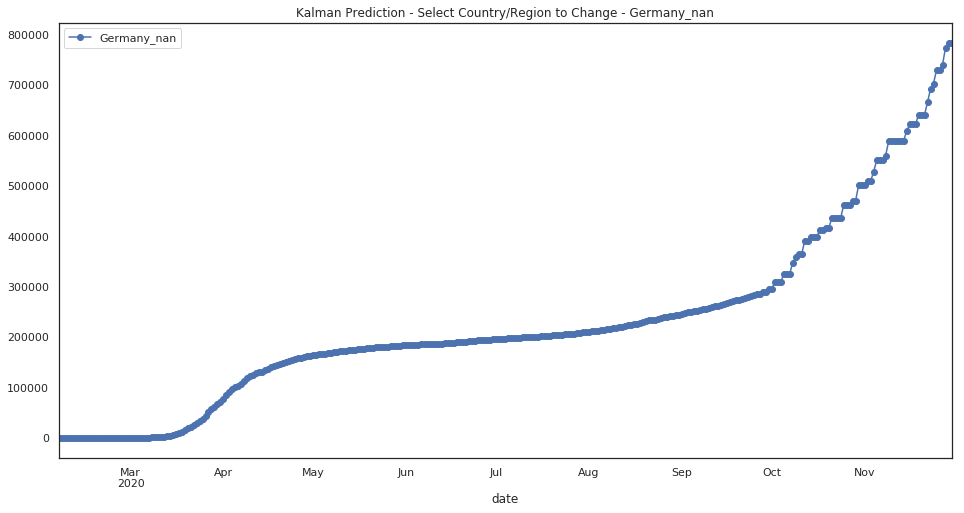

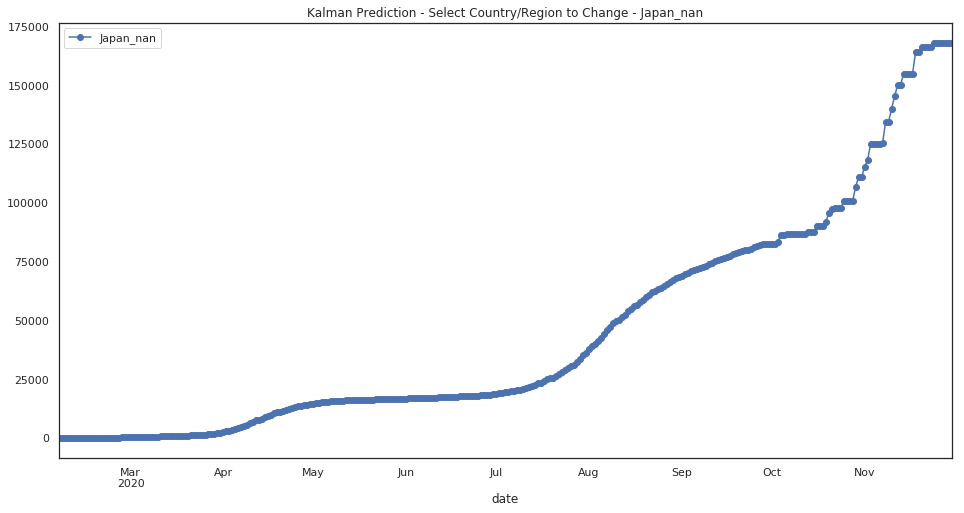

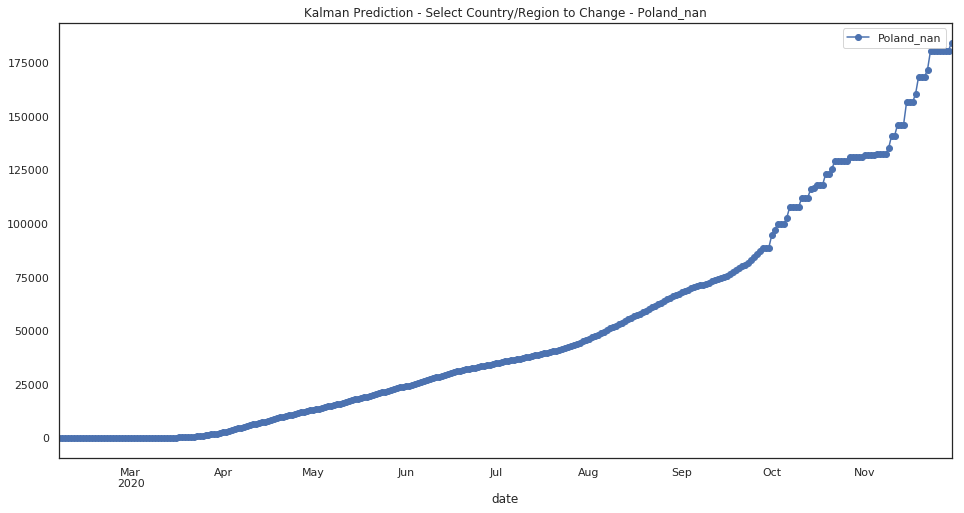

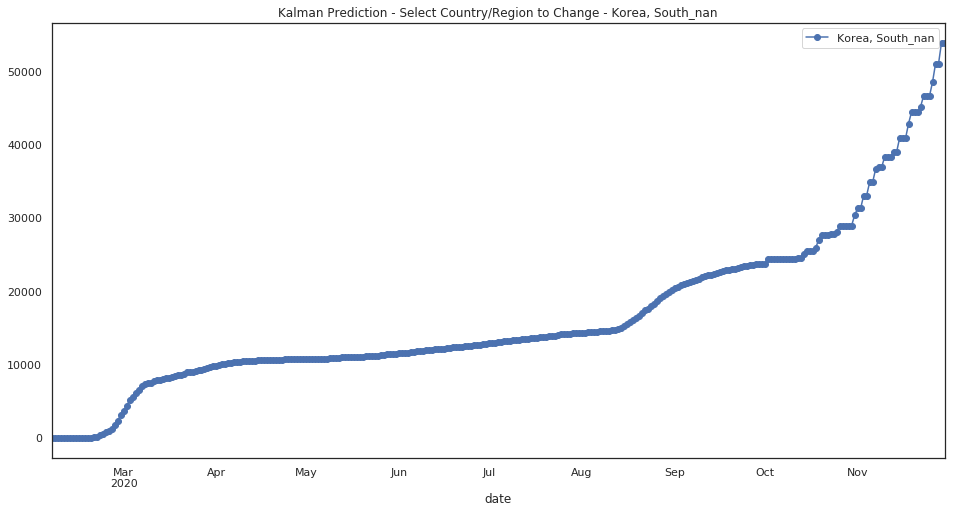

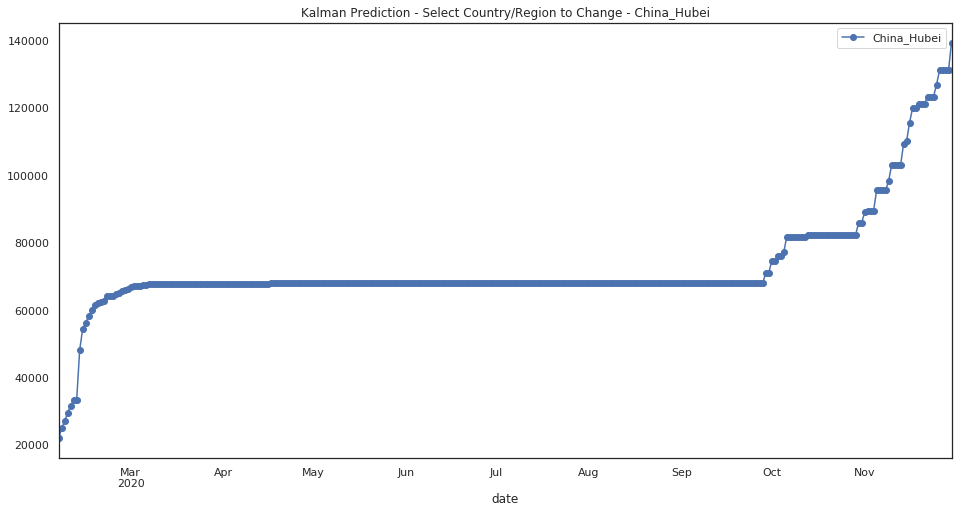

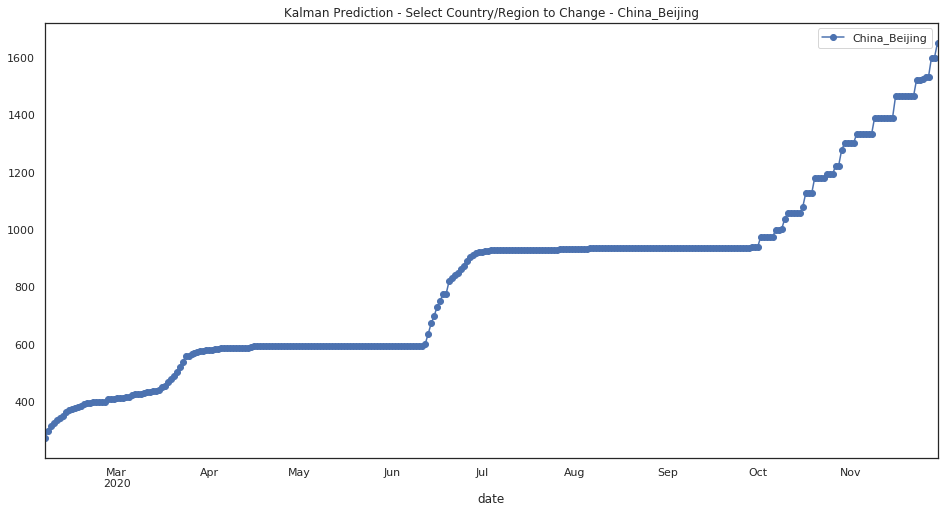

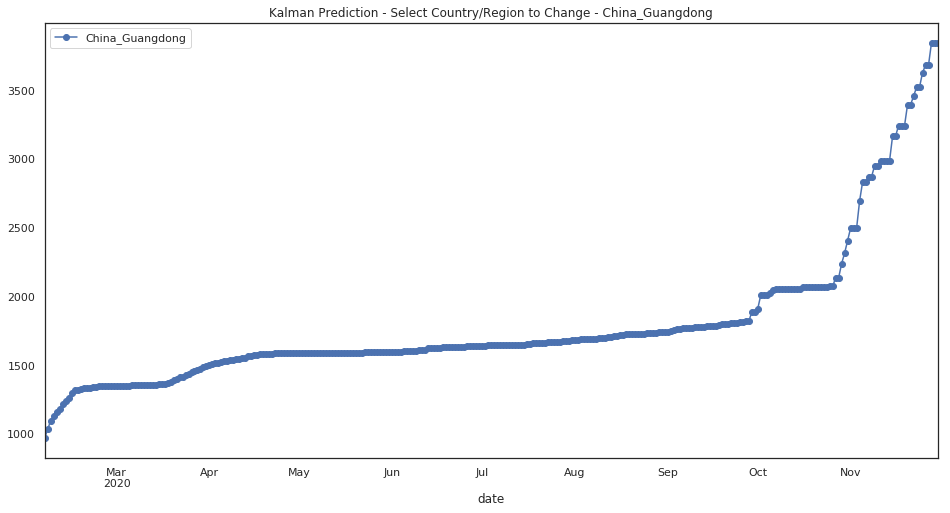

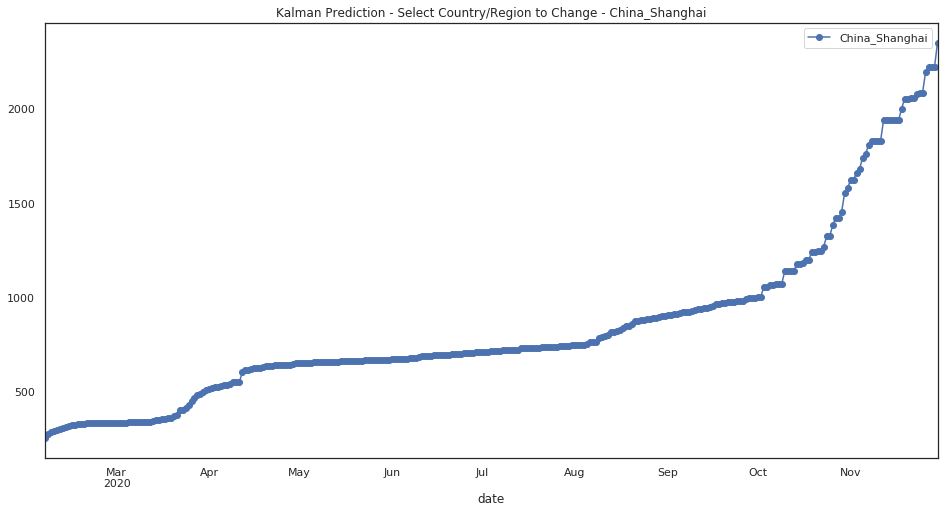

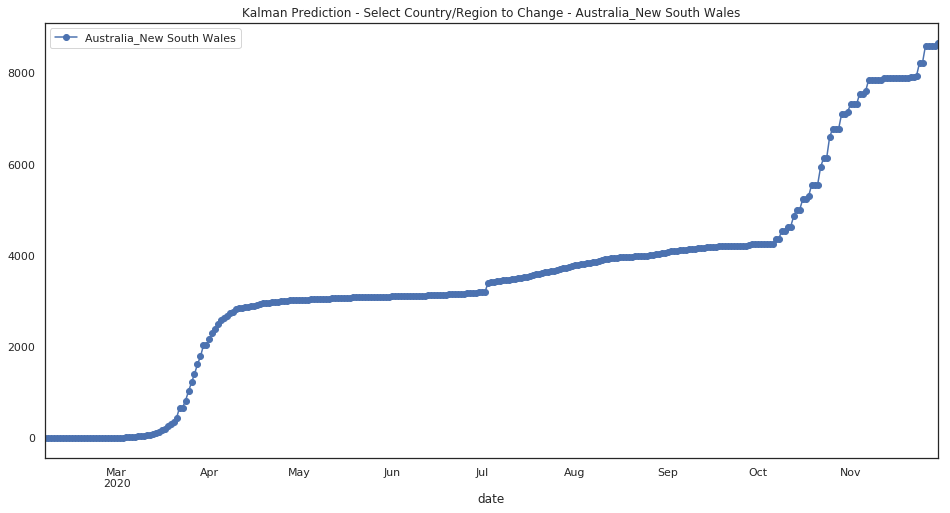

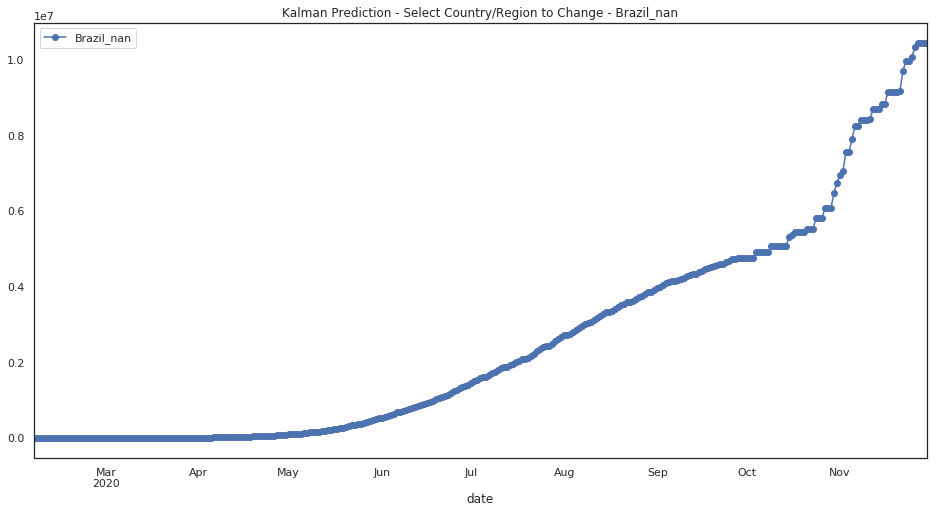

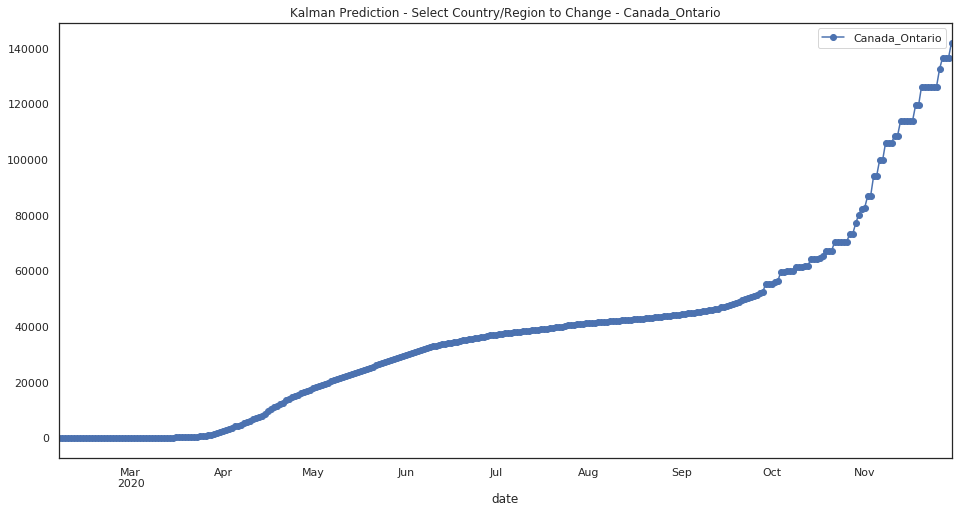

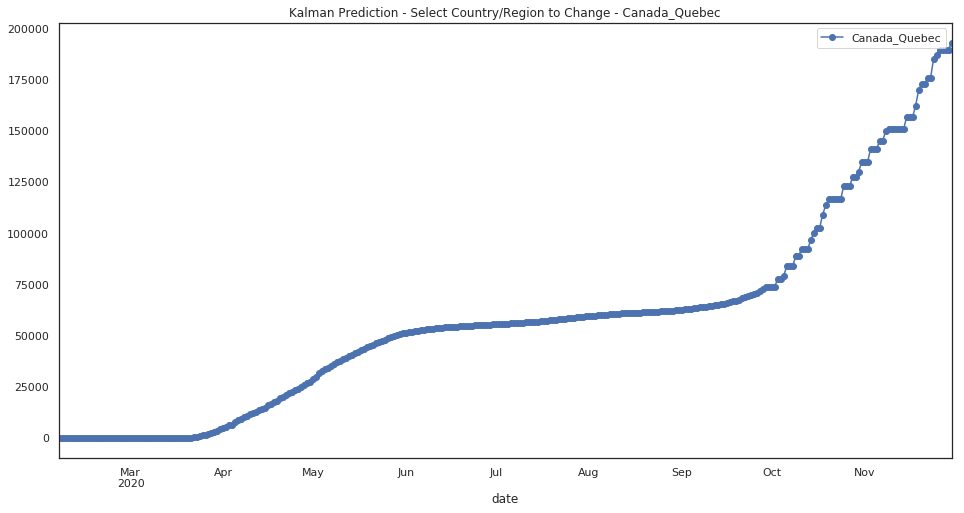

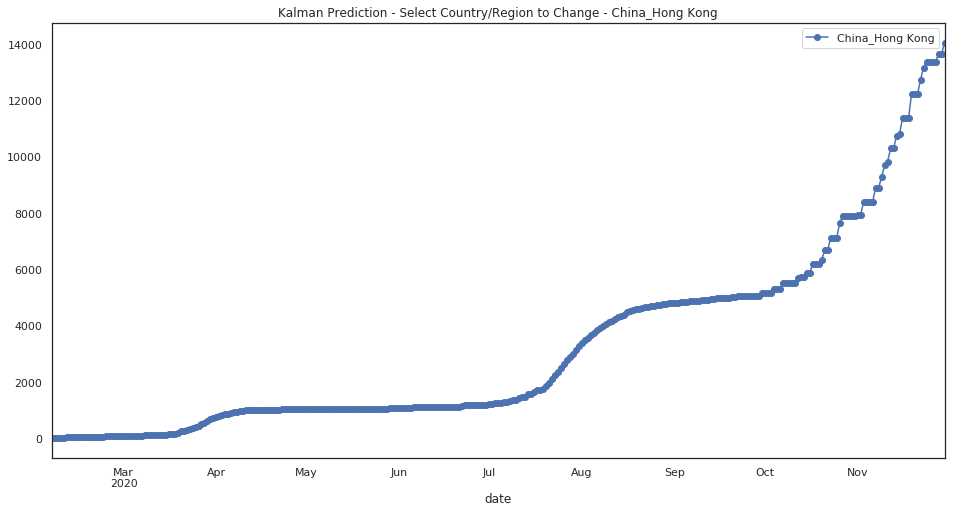

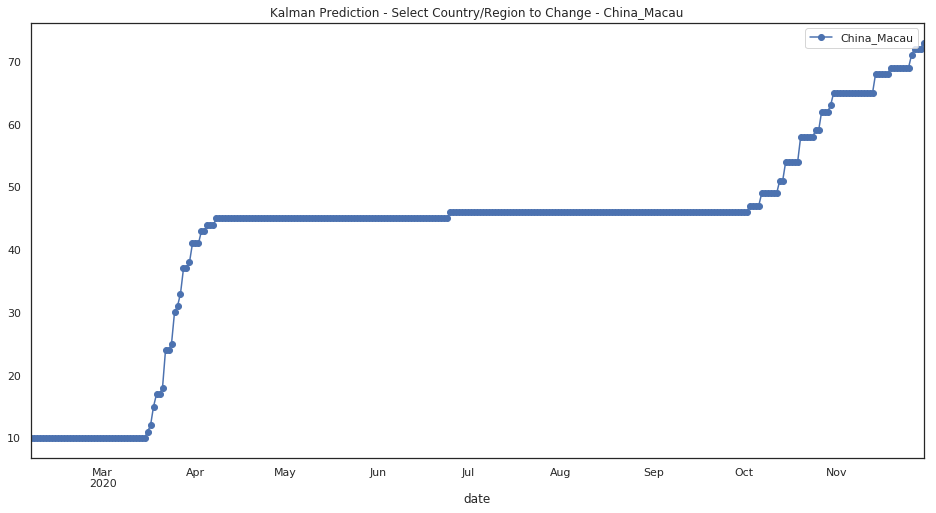

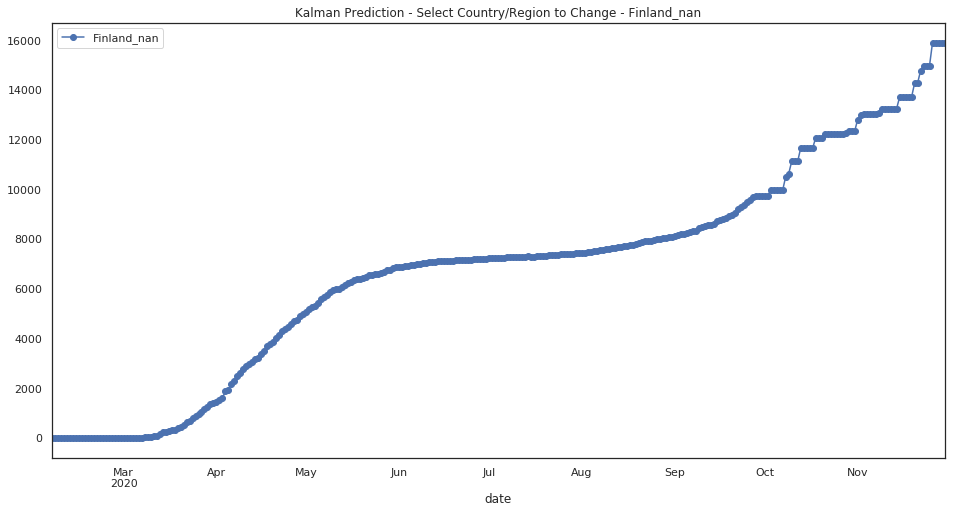

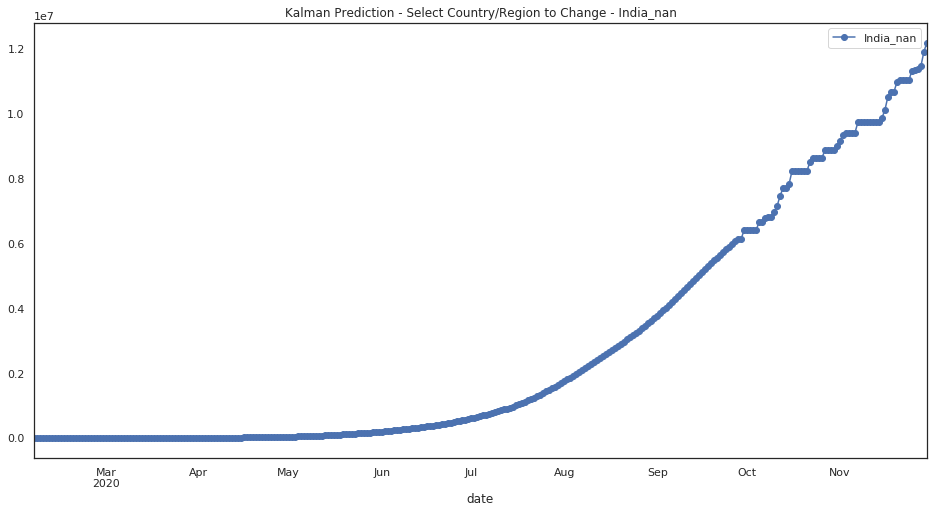

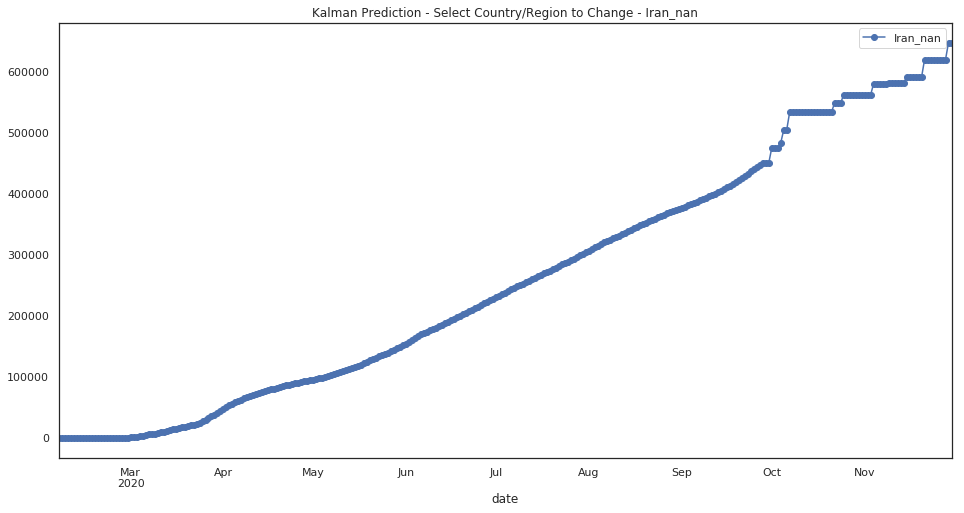

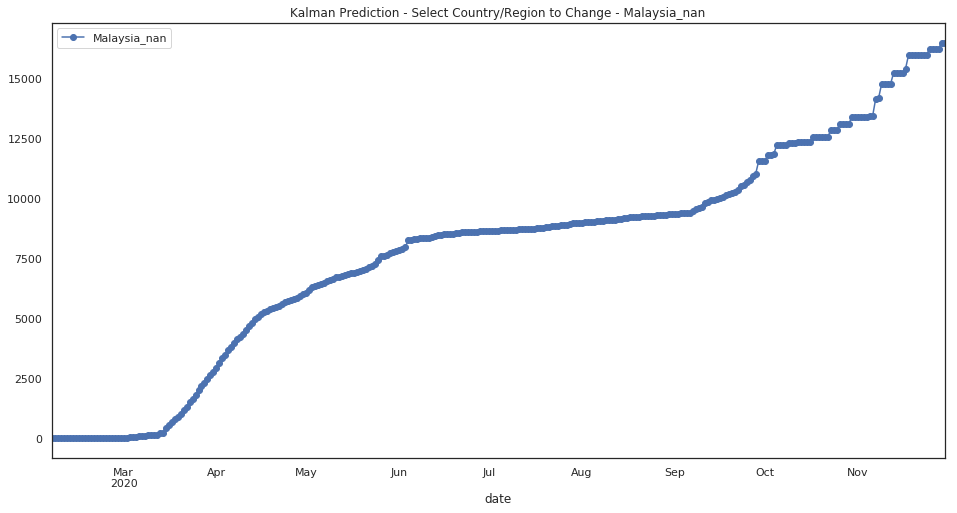

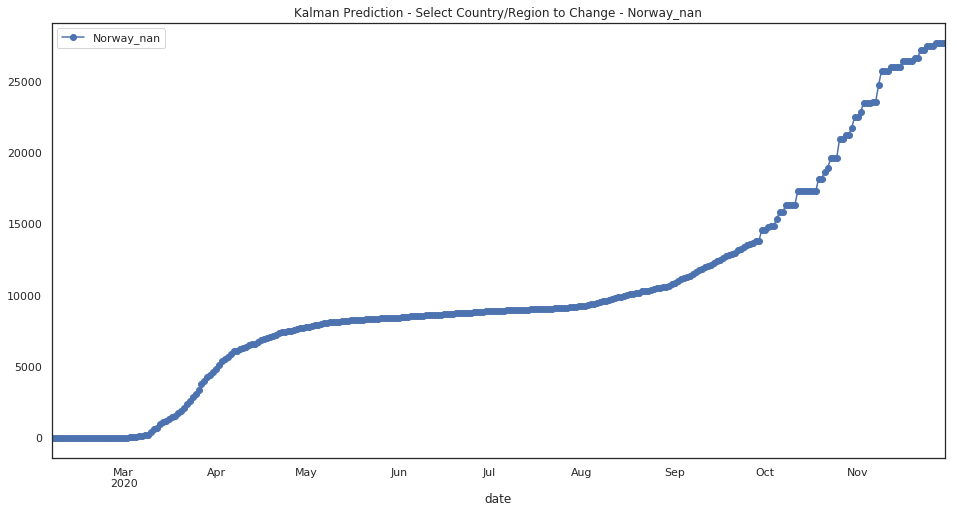

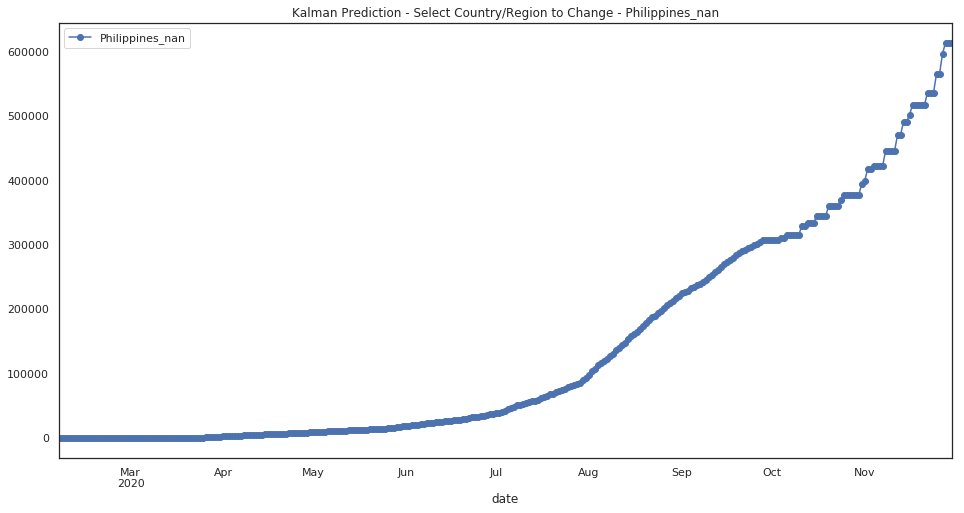

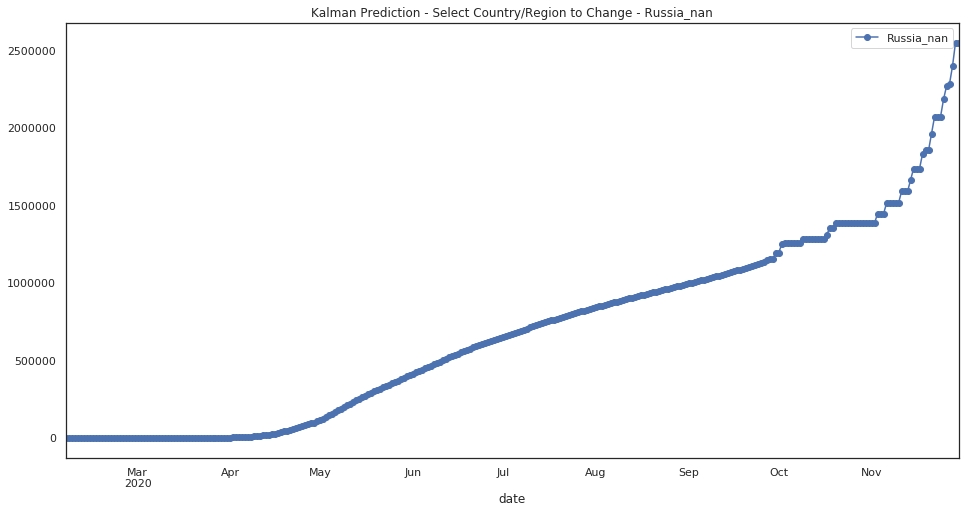

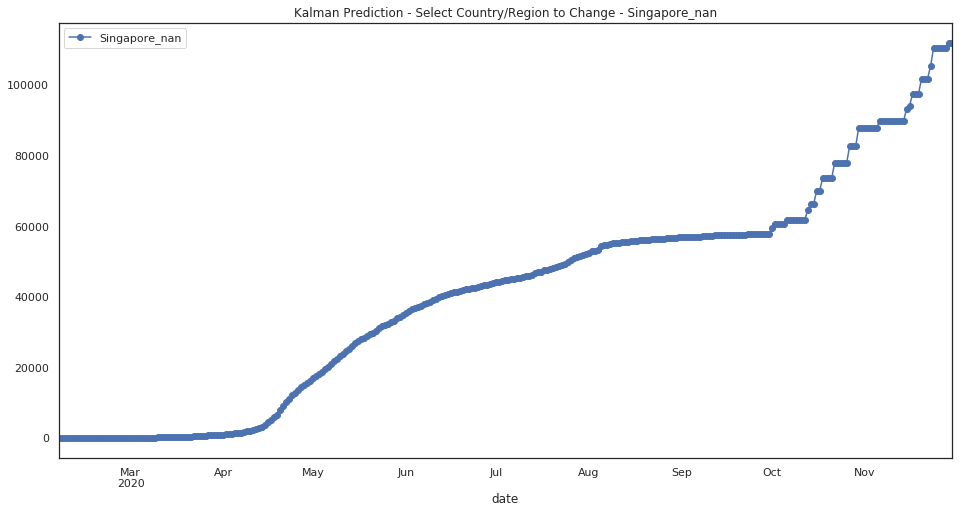

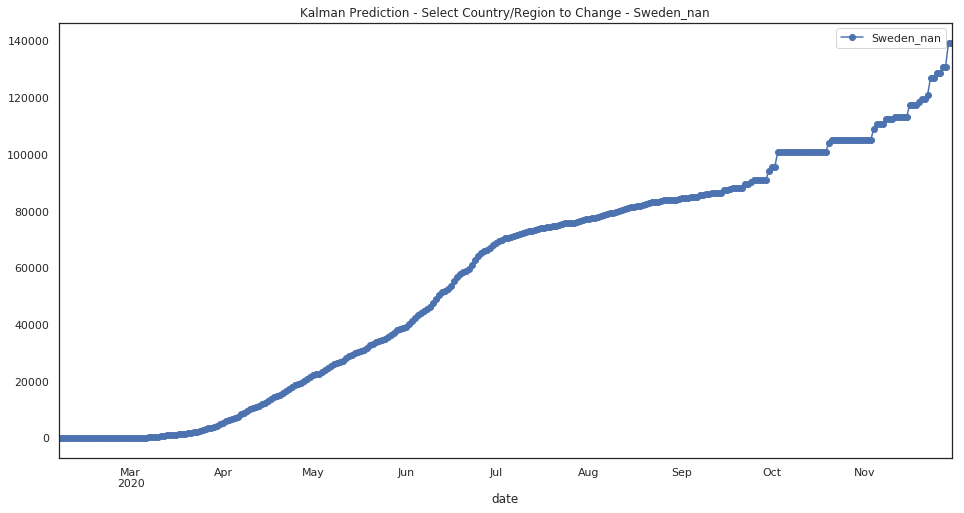

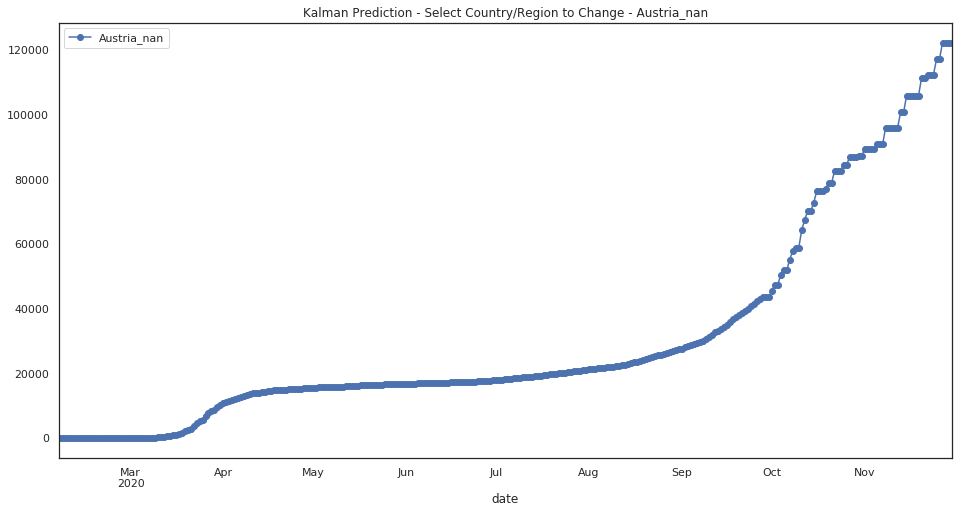

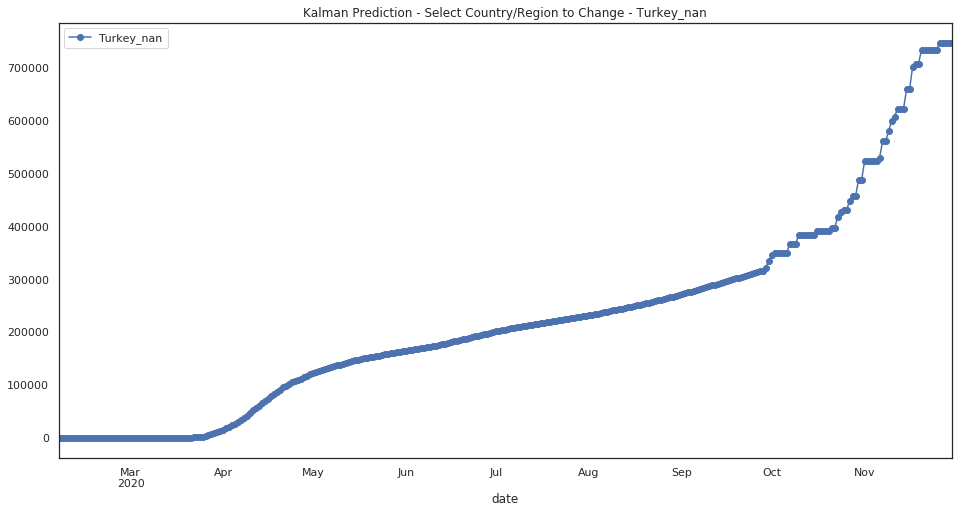

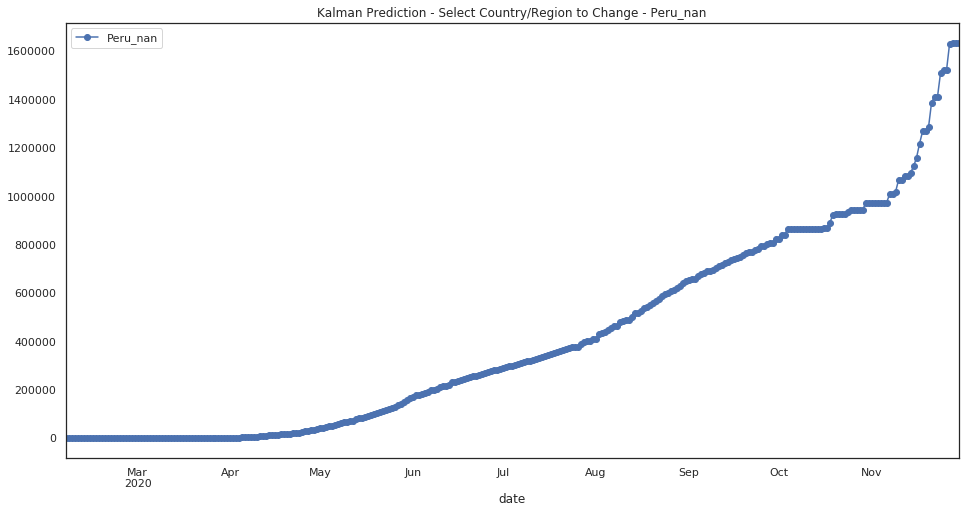

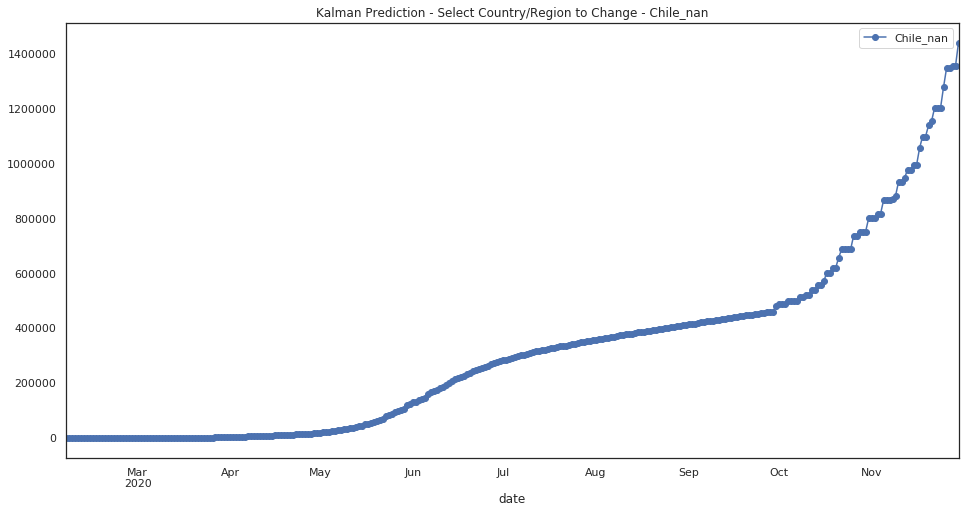

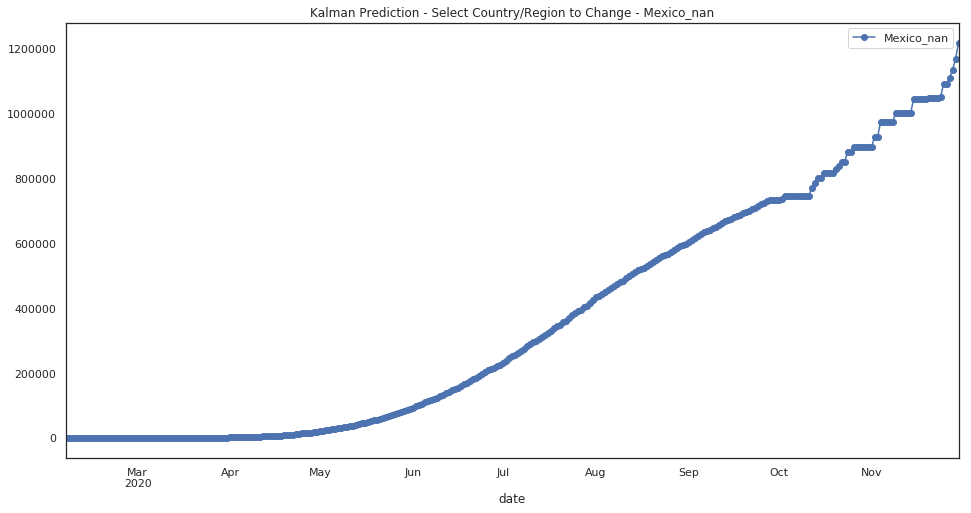

In [65]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [66]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2020-11-30 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      15543783.0
India_nan                                   NaN      12201530.0
Brazil_nan                                  NaN      10449430.0
Spain_nan                                   NaN       2897106.0
Russia_nan                                  NaN       2551838.0
Colombia_nan                                NaN       1662689.0
Peru_nan                                    NaN       1634983.0
Argentina_nan                               NaN       1571647.0
Chile_nan                                   NaN       1439472.0
France_nan                                  NaN       1375030.0
Mexico_nan                                  NaN       1220037.0
Bangladesh_nan                              NaN       1090962.0
South Africa_nan                            NaN        979161.0
Saudi Arabia_nan                            NaN        957600.0
United Kingdom_nan                          NaN        895811.0
Germany_nan                                 NaN        784183.0
Italy_nan                                   NaN        749461.0
Turkey_nan                                  NaN        746864.0
Iran_nan                                    NaN        647296.0
Philippines_nan                             NaN        613411.0
Morocco_nan                                 NaN        605569.0
Iraq_nan                                    NaN        574933.0
Israel_nan                                  NaN        538133.0
Pakistan_nan                                NaN        514616.0
Indonesia_nan                               NaN        428863.0
Ukraine_nan                                 NaN        359975.0
Dominican Republic_nan                      NaN        325253.0
Egypt_nan                                   NaN        298734.0
United Arab Emirates_nan                    NaN        292745.0
Panama_nan                                  NaN        276145.0
...                                         ...             ...
Australia_Australian Capital Territory      NaN           191.0
France_Saint Barthelemy                     NaN           187.0
United Kingdom_British Virgin Islands       NaN           170.0
Saint Vincent and the Grenadines_nan        NaN           137.0
Dominica_nan                                NaN           129.0
China_Ningxia                               NaN           116.0
Canada_Prince Edward Island                 NaN           115.0
China_Macau                                 NaN            73.0
Australia_Northern Territory                NaN            73.0
Fiji_nan                                    NaN            69.0
Saint Lucia_nan                             NaN            61.0
Timor-Leste_nan                             NaN            60.0
France_New Caledonia                        NaN            47.0
France_Saint Pierre and Miquelon            NaN            47.0
Saint Kitts and Nevis_nan                   NaN            46.0
Grenada_nan                                 NaN            38.0
Denmark_Greenland                           NaN            38.0
Laos_nan                                    NaN            38.0
China_Qinghai                               NaN            33.0
Canada_Yukon                                NaN            32.0
United Kingdom_Falkland Islands (Malvinas)  NaN            28.0
Holy See_nan                                NaN            22.0
Canada_Grand Princess                       NaN            21.0
United Kingdom_Montserrat                   NaN            21.0
Western Sahara_nan                          NaN            10.0
MS Zaandam_nan                              NaN             9.0
Canada_Northwest Territories                NaN             5.0
United Kingdom_Anguilla                     NaN             3.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             1.0

[266 rows x 2 columns]

In [67]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [68]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [69]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [70]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [71]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [72]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-02-06             11.0         11.0         11.0         11.0   
2020-02-07             11.0         11.0         11.0         11.0   
2020-02-08             11.0         11.0         11.0         11.0   
2020-02-09             11.0         11.0         11.0         11.0   
2020-02-10             11.0         11.0         11.0         11.0   
2020-02-11             11.0         11.0         11.0         11.0   
2020-02-12             11.0         11.0         11.0         11.0   
2020-02-13             11.0         11.0         11.0         11.0   
2020-02-14             11.0         11.0         11.0         11.0   
2020-02-15             11.0         11.0         11.0         11.0   
2020-02-16             11.0         11.0         11.0         11.0   
2020-02-17             11.0         11.0         11.0         11.0   
2020-02-18             36.0         11.0         38.0         11.0   
2020-02-19             23.0         11.0         40.0         11.0   
2020-02-20             32.0         11.0         40.0         11.0   
2020-02-21             37.0         11.0         43.0         11.0   
2020-02-22             33.0         11.0         41.0         11.0   
2020-02-23             33.0         11.0         38.0         11.0   
2020-02-24             36.0         11.0         44.0         11.0   
2020-02-25             38.0         11.0         39.0         11.0   
2020-02-26             16.0         11.0         42.0         11.0   
2020-02-27             34.0         11.0         40.0         11.0   
2020-02-28             20.0         11.0         32.0         11.0   
2020-02-29             22.0         11.0         36.0         11.0   
2020-03-01             23.0         11.0         35.0         11.0   
2020-03-02             25.0         11.0         34.0         10.0   
2020-03-03             26.0         11.0         24.0         12.0   
2020-03-04             20.0         11.0         45.0          4.0   
2020-03-05             20.0         11.0         87.0          4.0   
2020-03-06             21.0         11.0         72.0          7.0   
...                     ...          ...          ...          ...   
2020-11-02         104678.0      18802.0      58390.0       3005.0   
2020-11-03         104095.0      18362.0      58393.0       3171.0   
2020-11-04         108137.0      19258.0      58157.0       3138.0   
2020-11-05         108910.0      19092.0      58431.0       3349.0   
2020-11-06         105575.0      20643.0      59080.0       3496.0   
2020-11-07         114337.0      20473.0      59093.0       3496.0   
2020-11-08         119564.0      21191.0      59172.0       3496.0   
2020-11-09         114110.0      21512.0      58744.0       3717.0   
2020-11-10         125306.0      21326.0      60298.0       3646.0   
2020-11-11         125254.0      21014.0      59689.0       3763.0   
2020-11-12         120962.0      21954.0      61508.0       3734.0   
2020-11-13         129724.0      23242.0      61433.0       3936.0   
2020-11-14         136682.0      23327.0      61981.0       4053.0   
2020-11-15         140904.0      23391.0      62310.0       4053.0   
2020-11-16         142838.0      23535.0      62314.0       4109.0   
2020-11-17         137092.0      23535.0      61502.0       4145.0   
2020-11-18         148515.0      23447.0      62710.0       4130.0   
2020-11-19         148671.0      23091.0      62272.0       4130.0   
2020-11-20         145995.0      22785.0      62275.0       4130.0   
2020-11-21         145225.0      23789.0      62337.0       4130.0   
2020-11-22         142151.0      23731.0      62340.0       4130.0   
2020-11-23         144881.0      24535.0      62344.0       4130.0   
2020-11-24         149540.0      24456.0      62347.0       4130.0   
2020-11-25         146699.0      25266.0      62108.0       4130.0   
2020-11-26

In [73]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [74]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'Spain_nan',
 'Russia_nan',
 'Colombia_nan',
 'Peru_nan',
 'Argentina_nan',
 'Chile_nan',
 'France_nan',
 'Mexico_nan',
 'Bangladesh_nan',
 'South Africa_nan',
 'Saudi Arabia_nan',
 'United Kingdom_nan',
 'Germany_nan',
 'Italy_nan',
 'Turkey_nan',
 'Iran_nan',
 'Philippines_nan',
 'Morocco_nan',
 'Iraq_nan',
 'Israel_nan',
 'Pakistan_nan',
 'Indonesia_nan',
 'Ukraine_nan',
 'Dominican Republic_nan',
 'Egypt_nan',
 'United Arab Emirates_nan',
 'Panama_nan',
 'Qatar_nan',
 'Belgium_nan',
 'Ecuador_nan',
 'Bolivia_nan',
 'Belarus_nan',
 'Netherlands_nan',
 'Kuwait_nan',
 'Romania_nan',
 'Kazakhstan_nan',
 'Canada_Quebec',
 'Oman_nan',
 'Poland_nan',
 'Guatemala_nan',
 'Nepal_nan',
 'Japan_nan',
 'Afghanistan_nan',
 'Switzerland_nan',
 'Honduras_nan',
 'Czechia_nan',
 'Portugal_nan',
 'Venezuela_nan',
 'Nigeria_nan',
 'Canada_Ontario',
 'Sweden_nan',
 'China_Hubei',
 'Ghana_nan',
 'Paraguay_nan',
 'Bahrain_nan',
 'Costa Rica_nan',
 'Aust

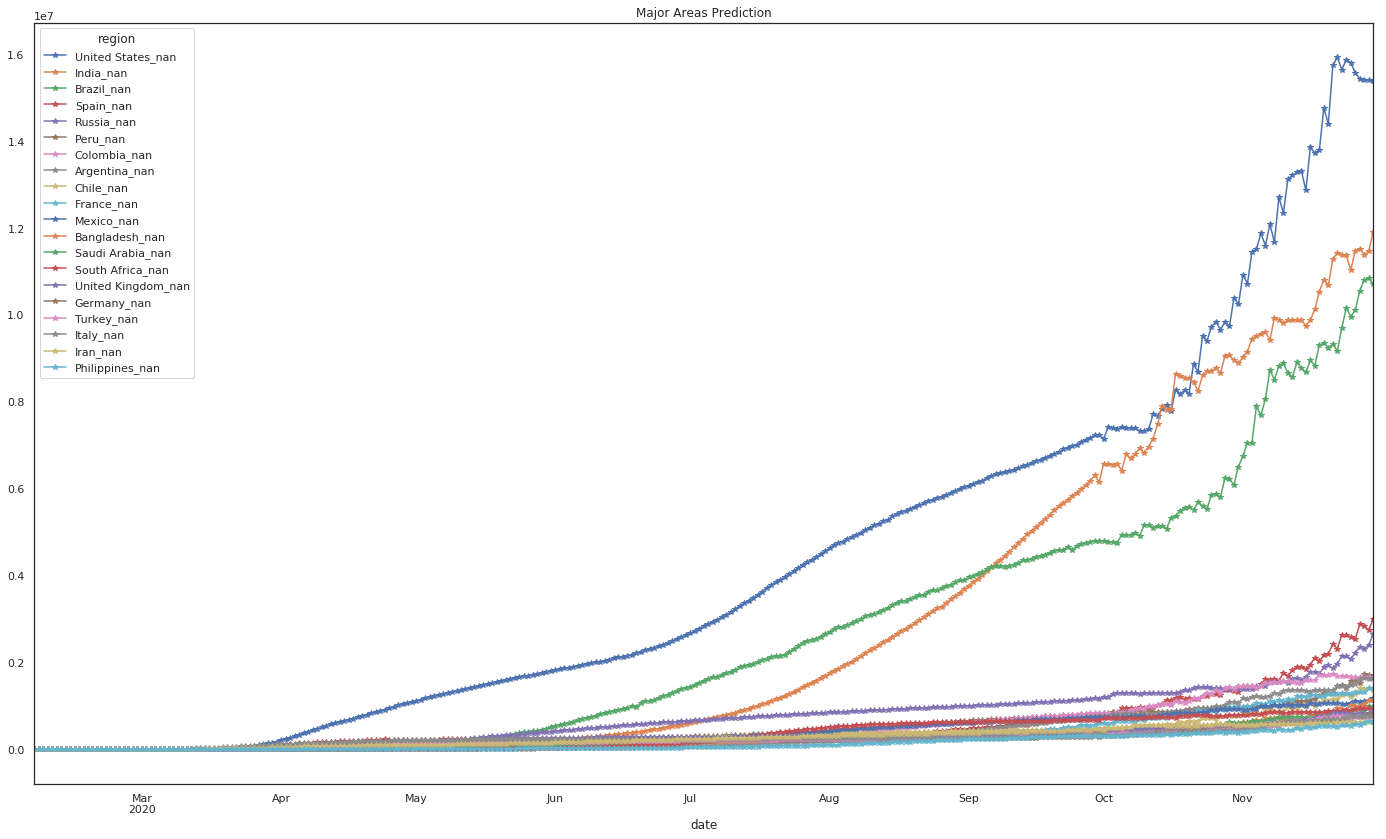

In [75]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

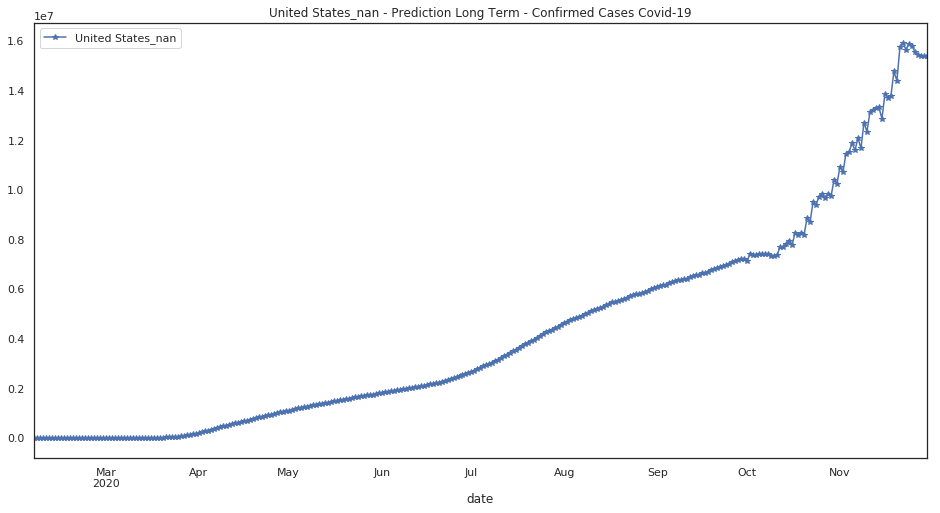

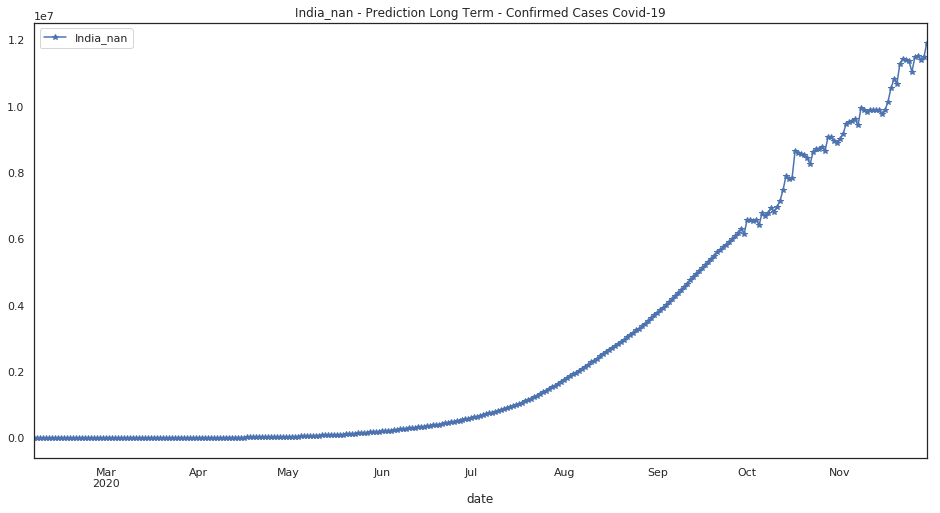

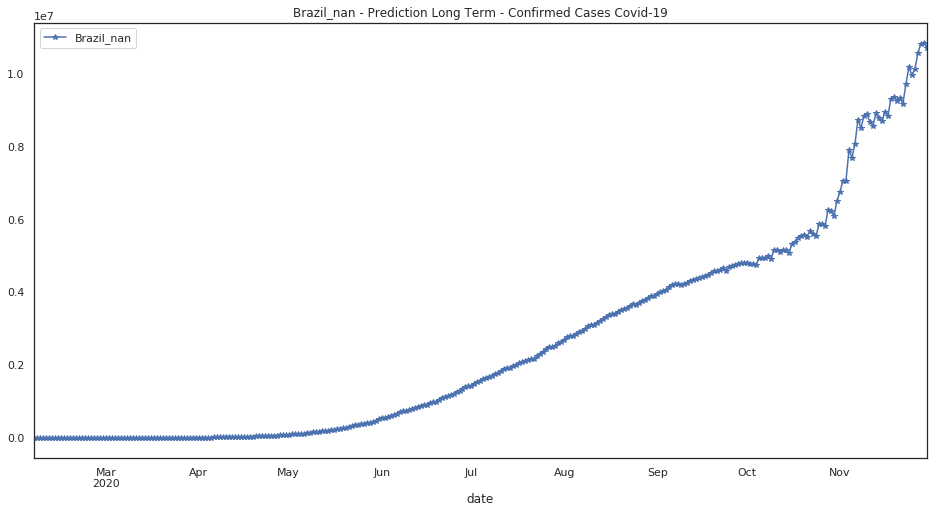

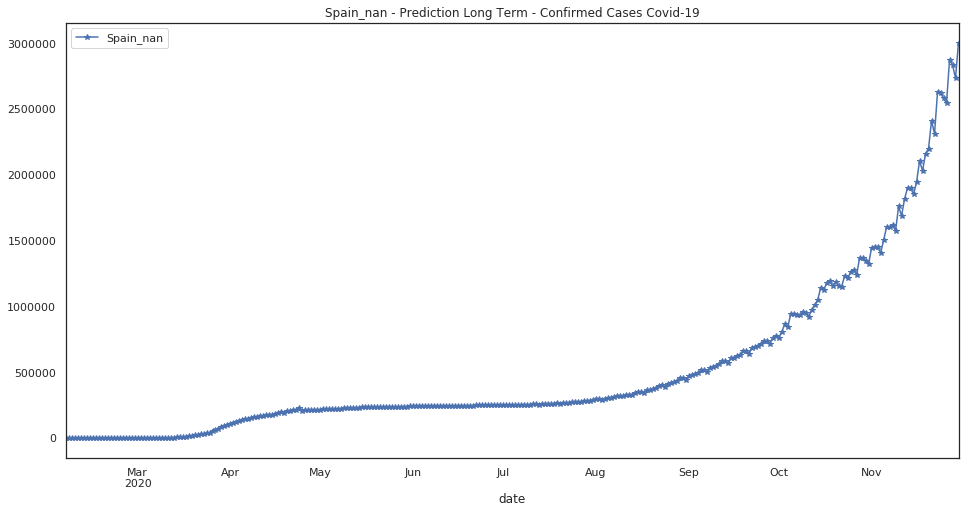

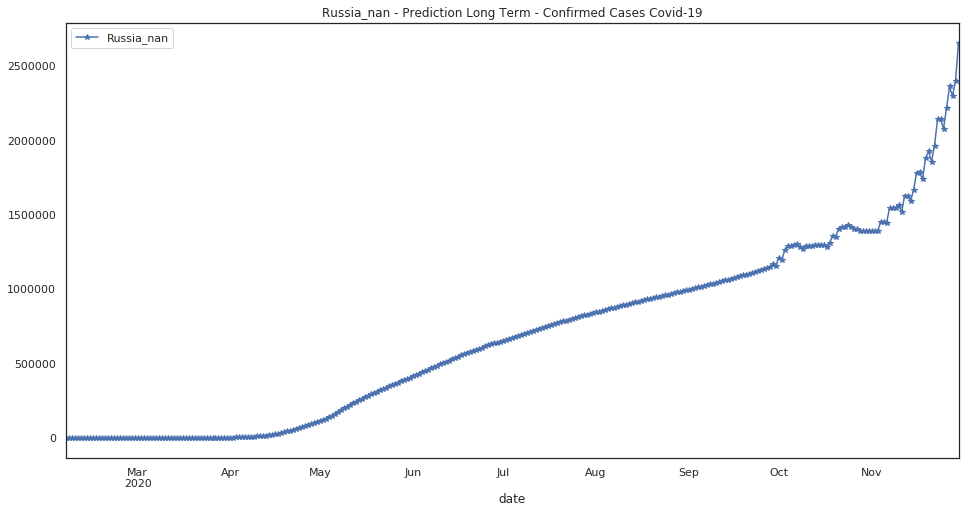

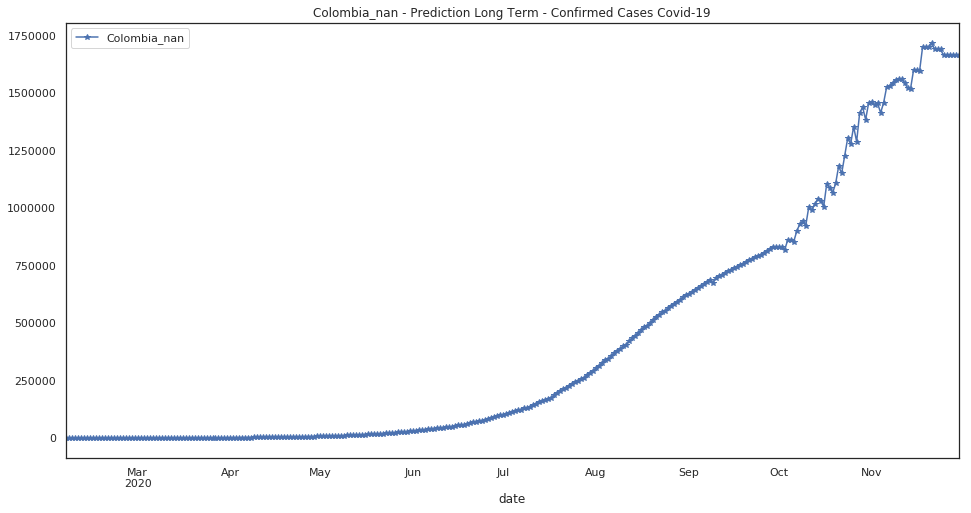

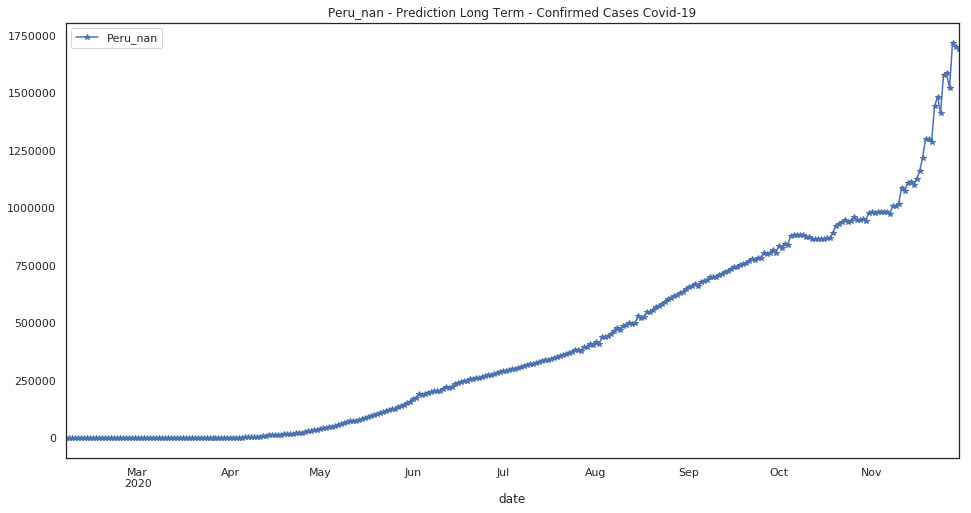

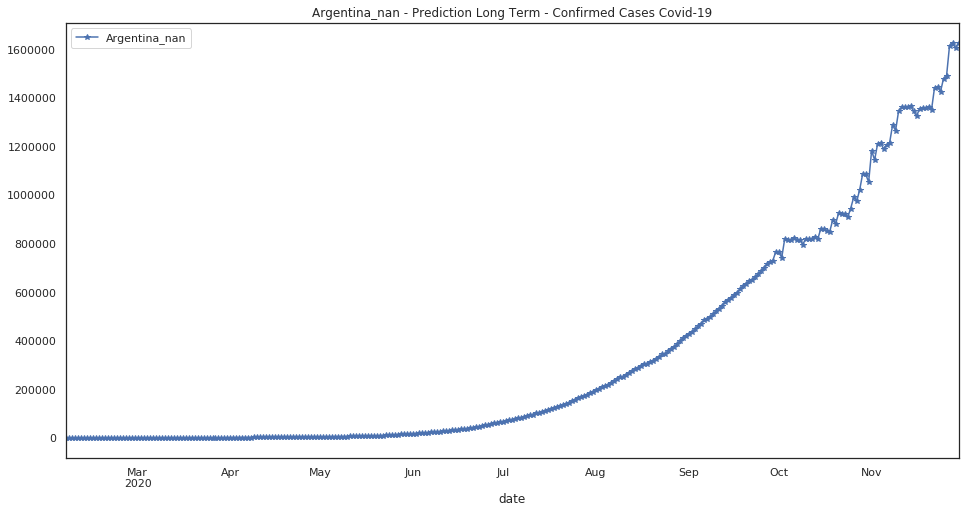

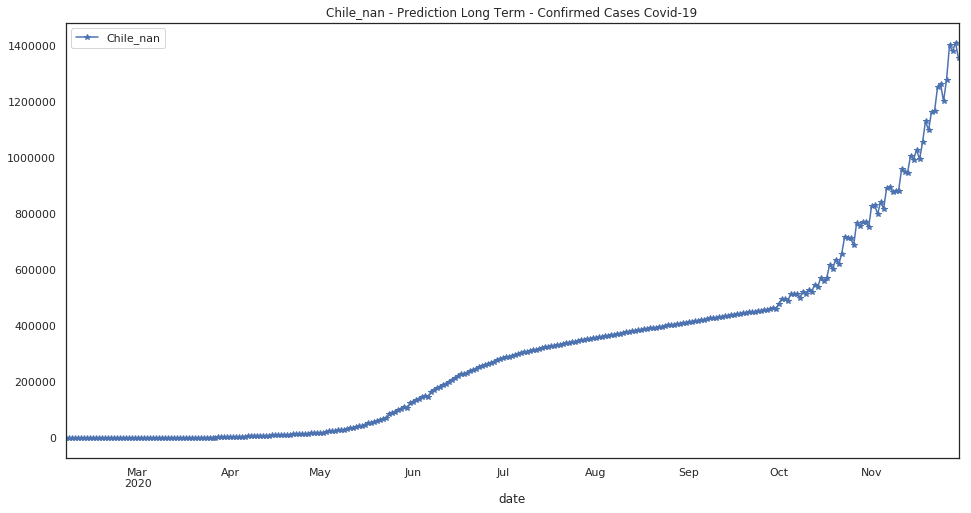

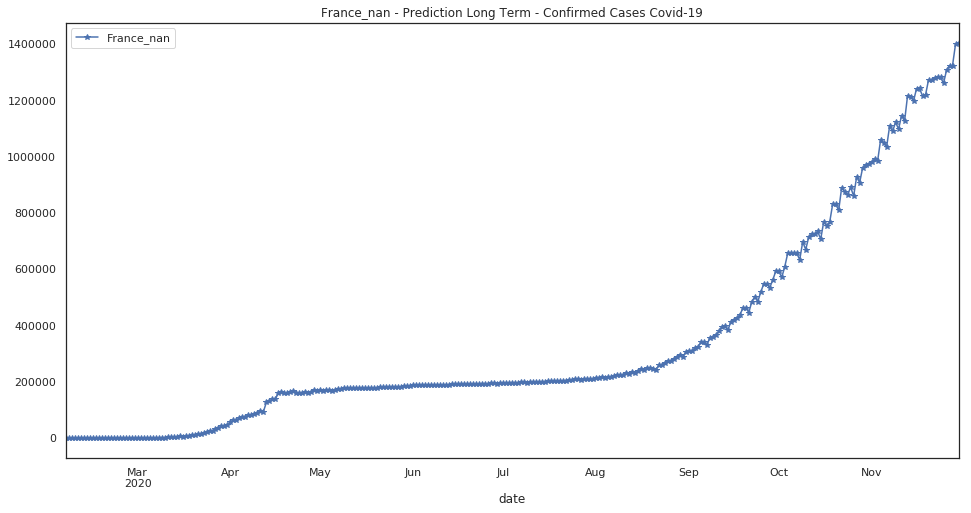

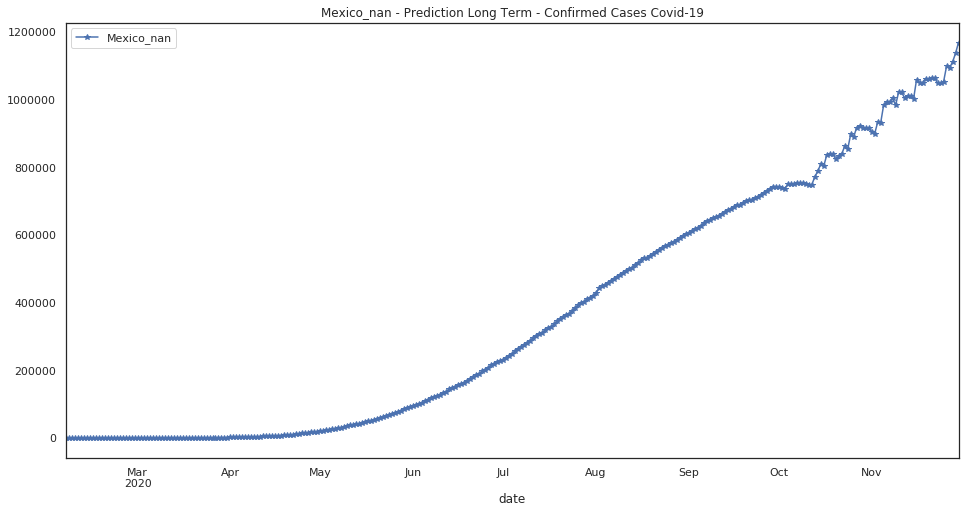

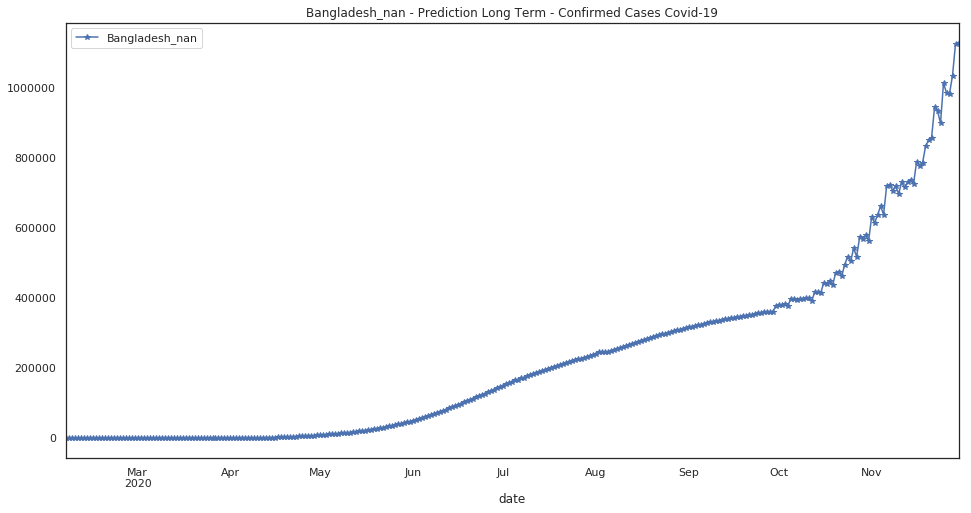

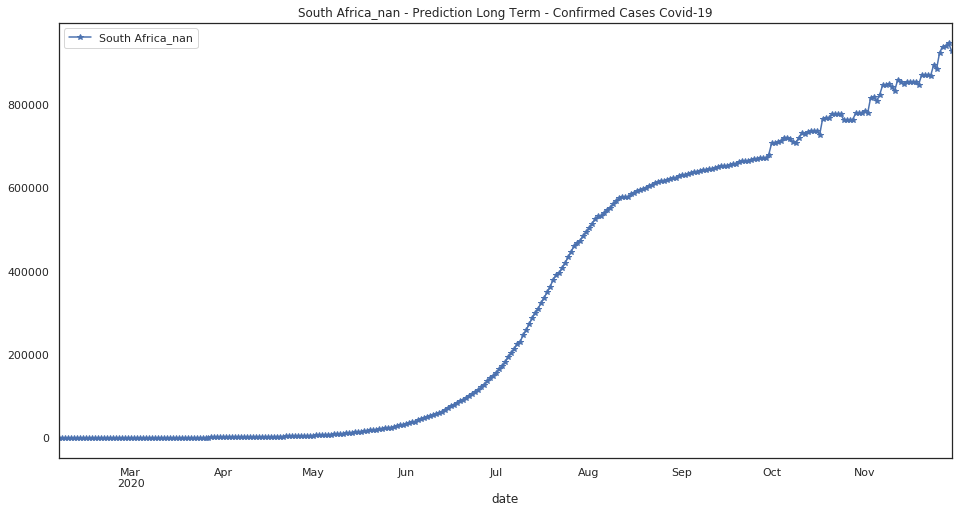

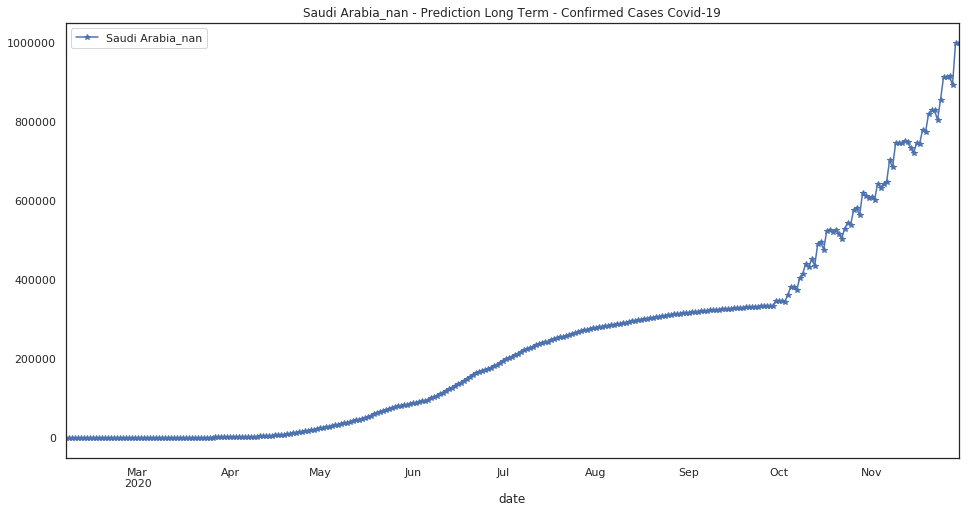

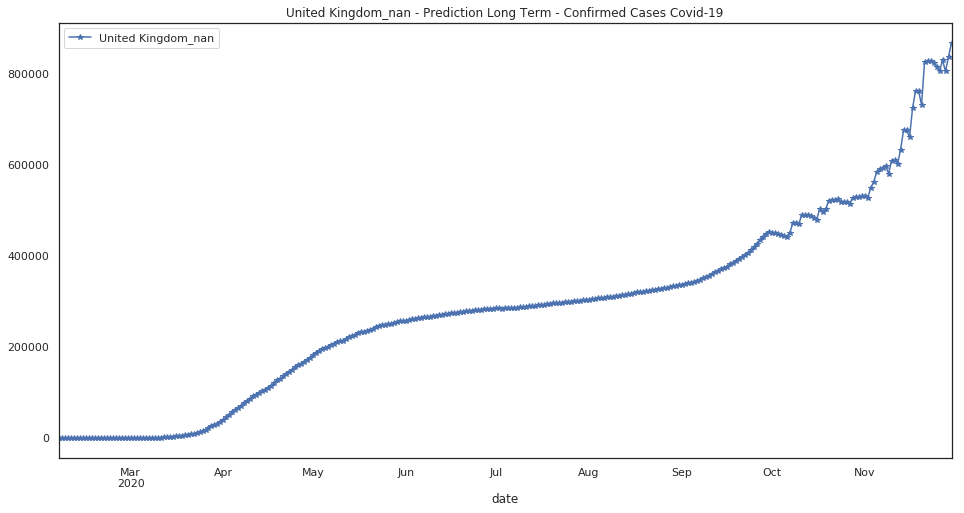

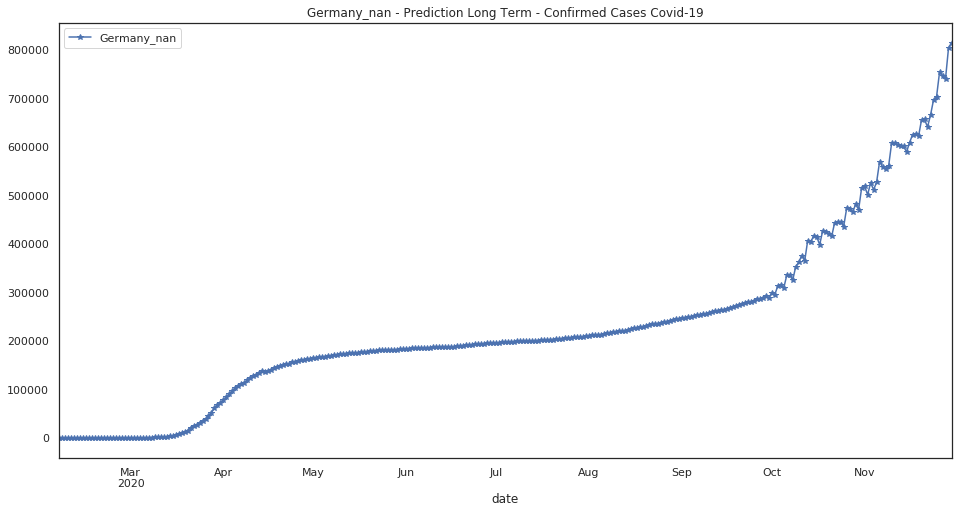

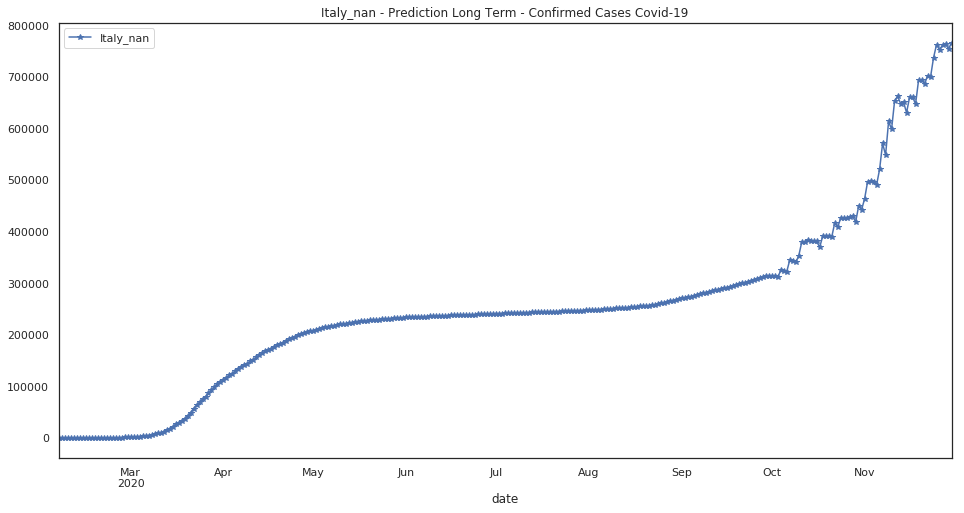

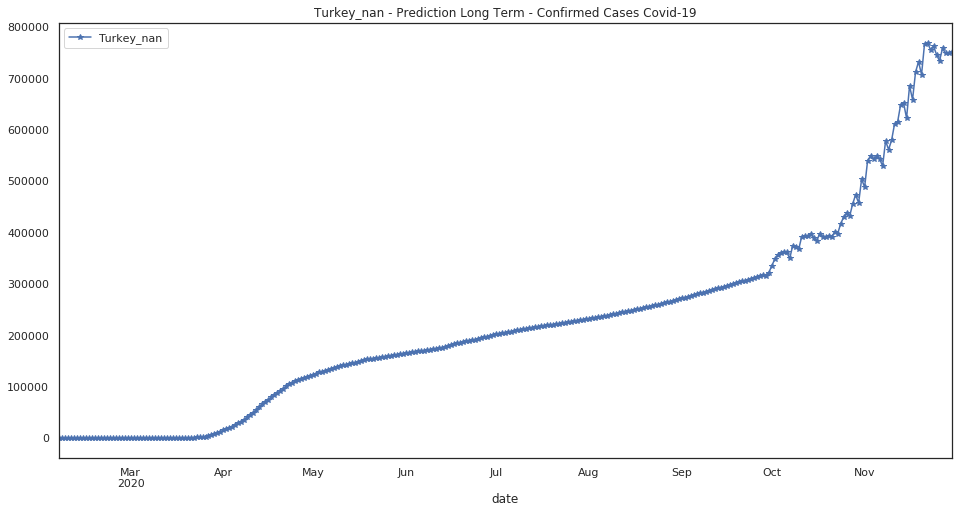

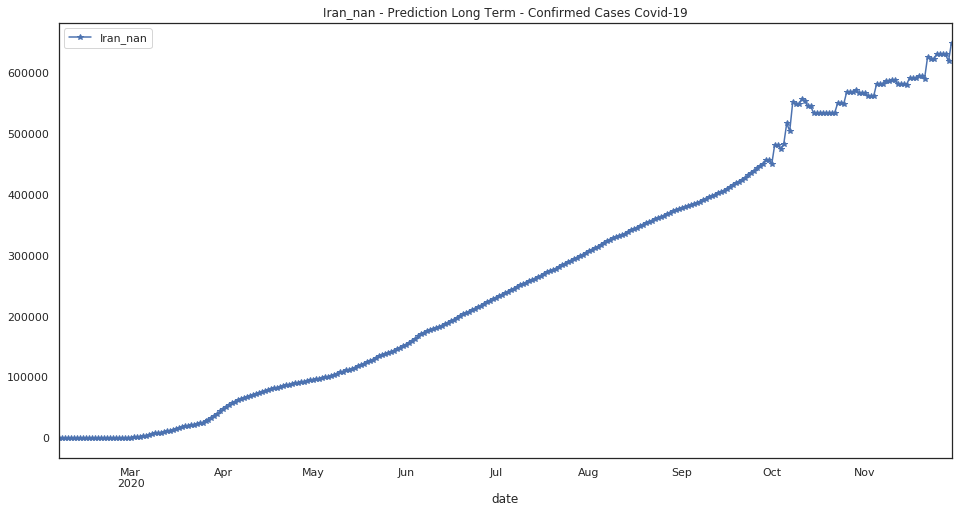

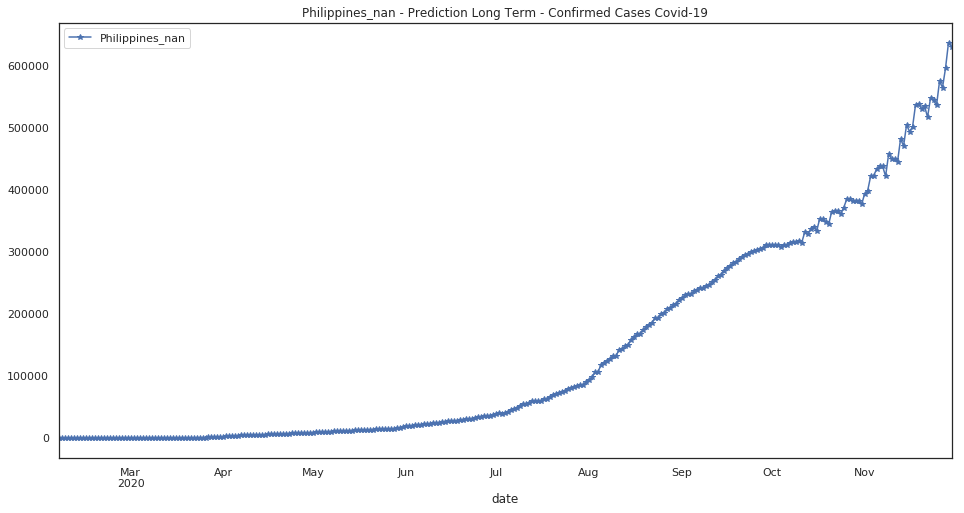

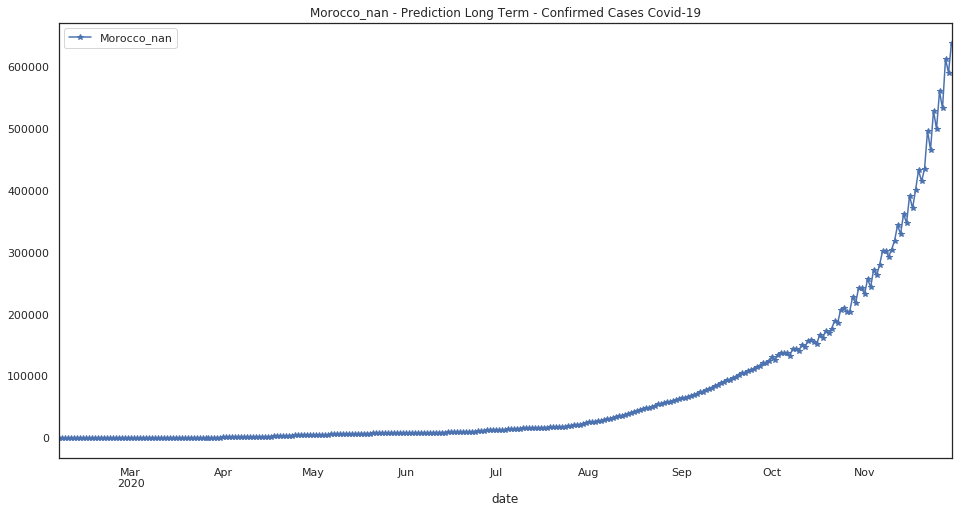

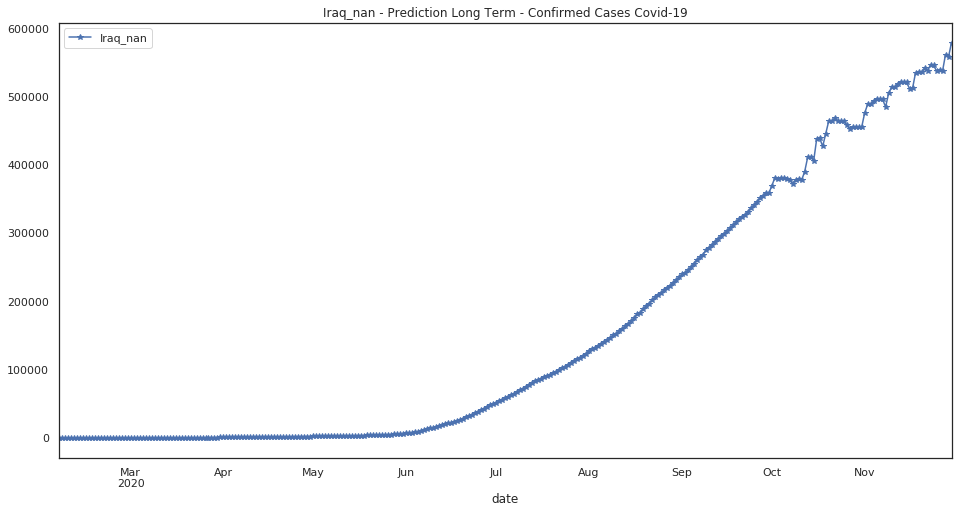

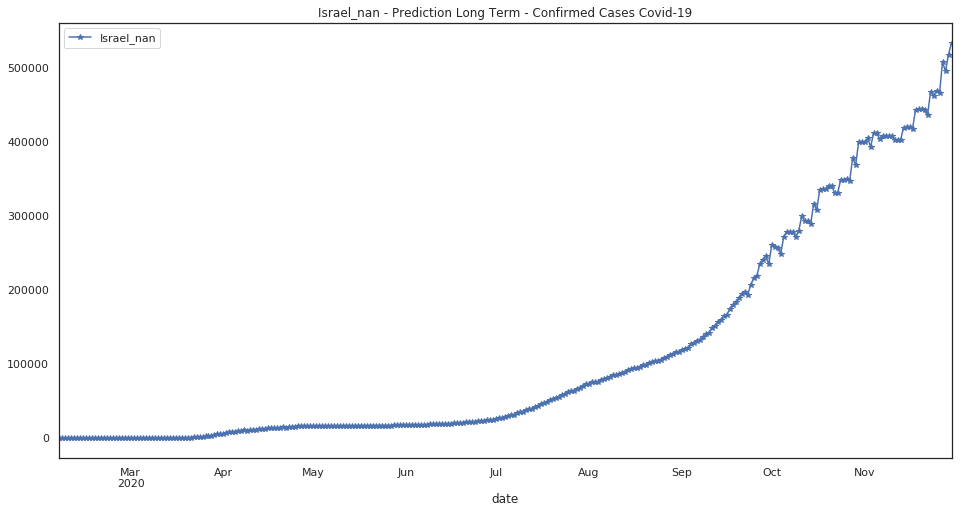

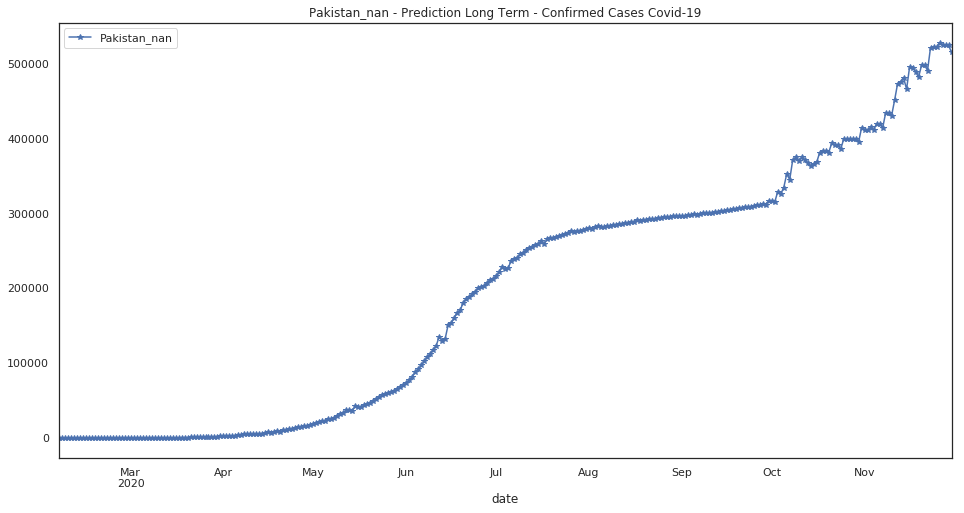

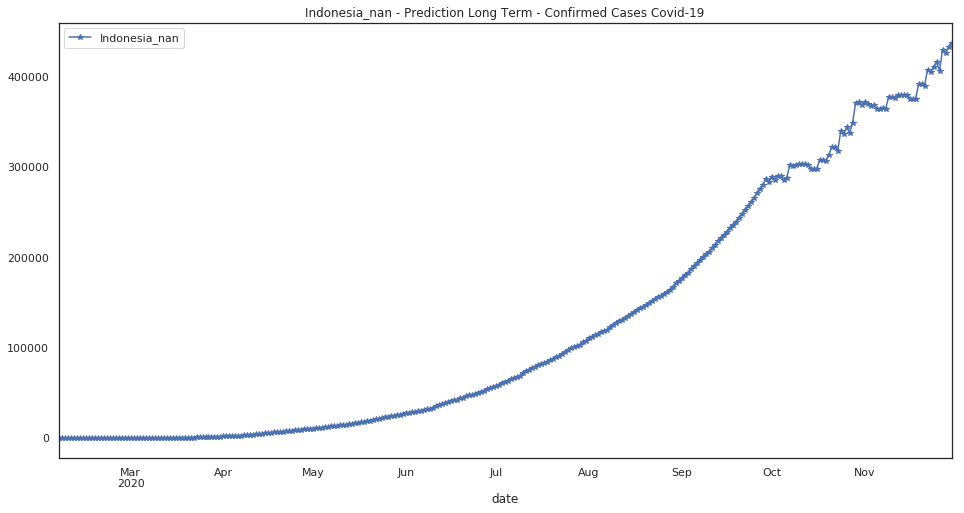

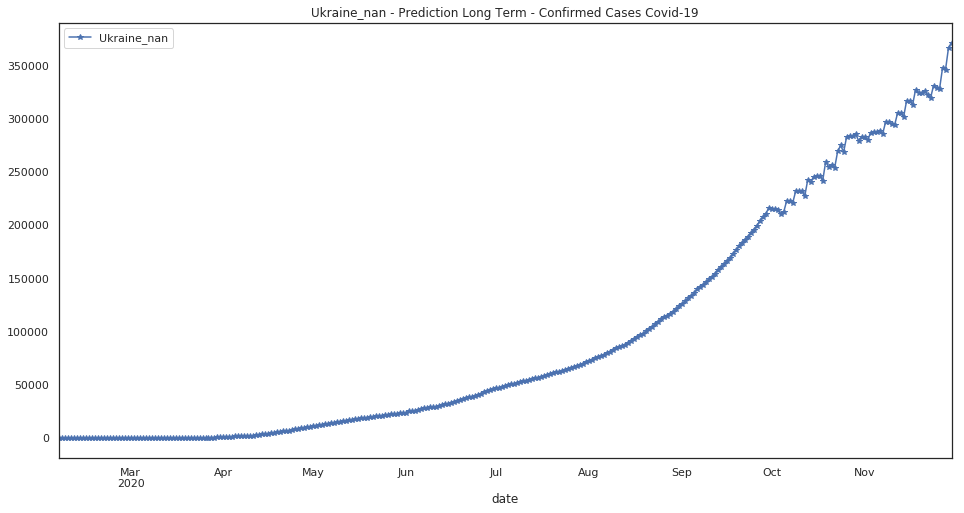

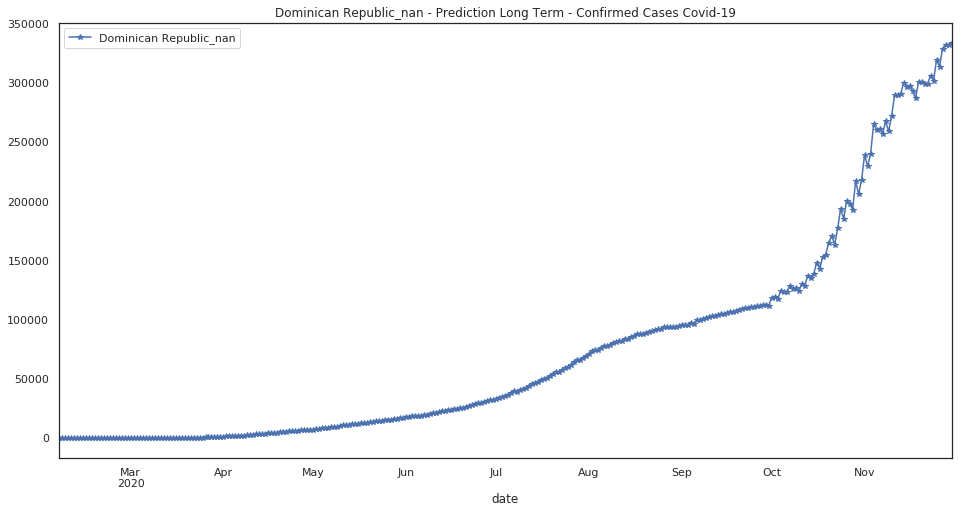

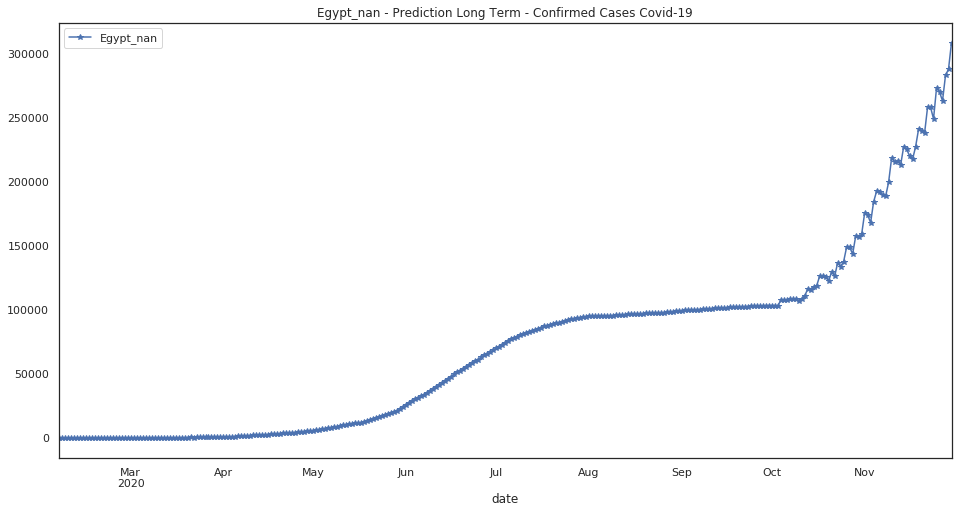

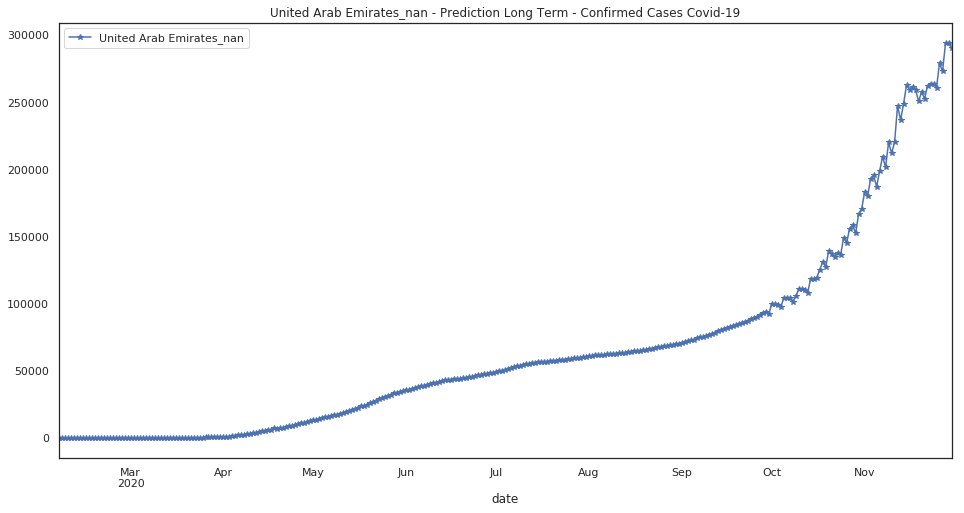

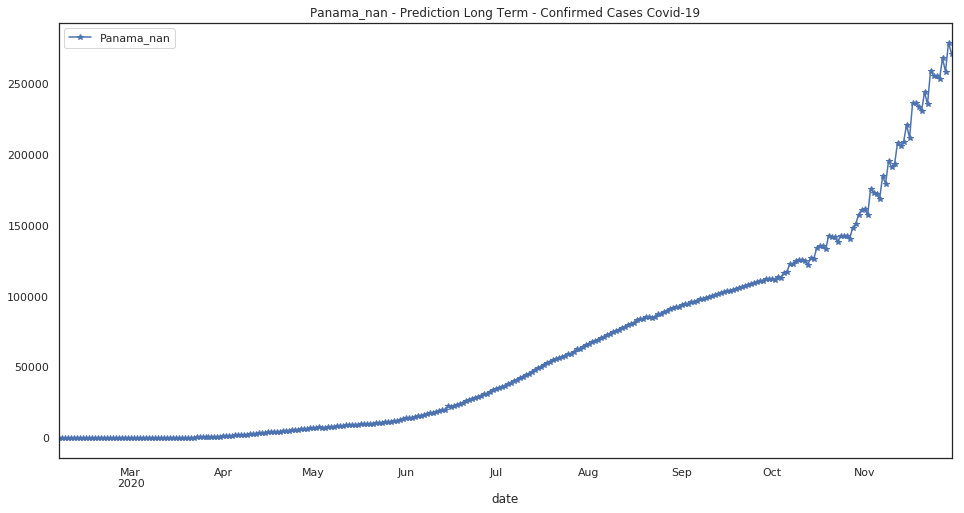

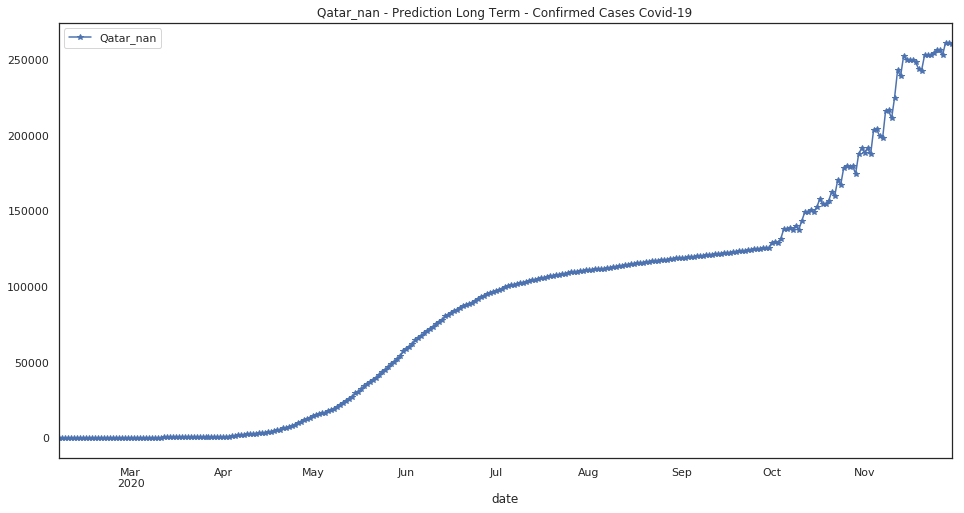

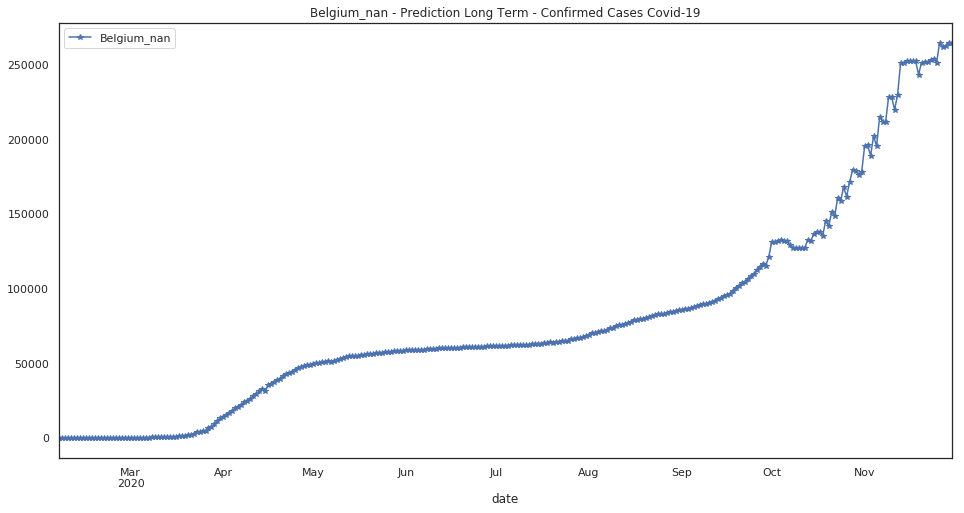

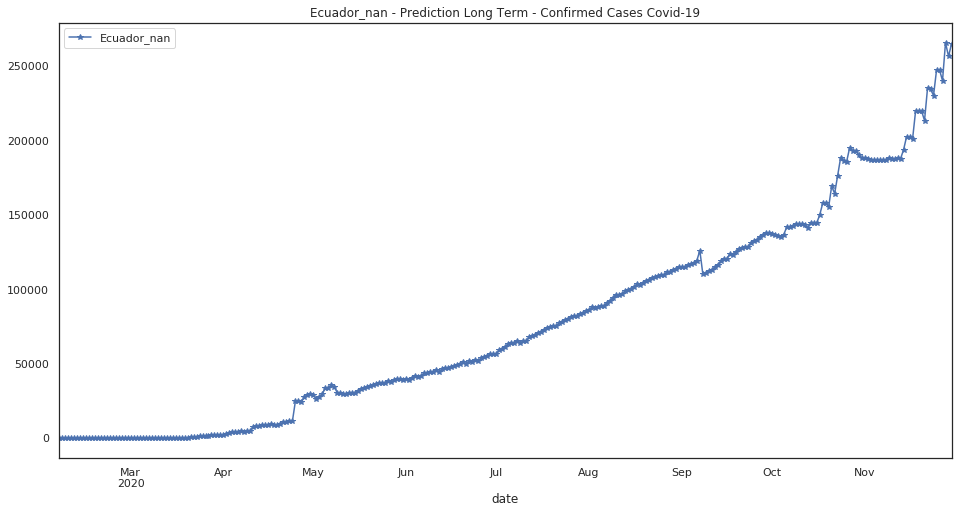

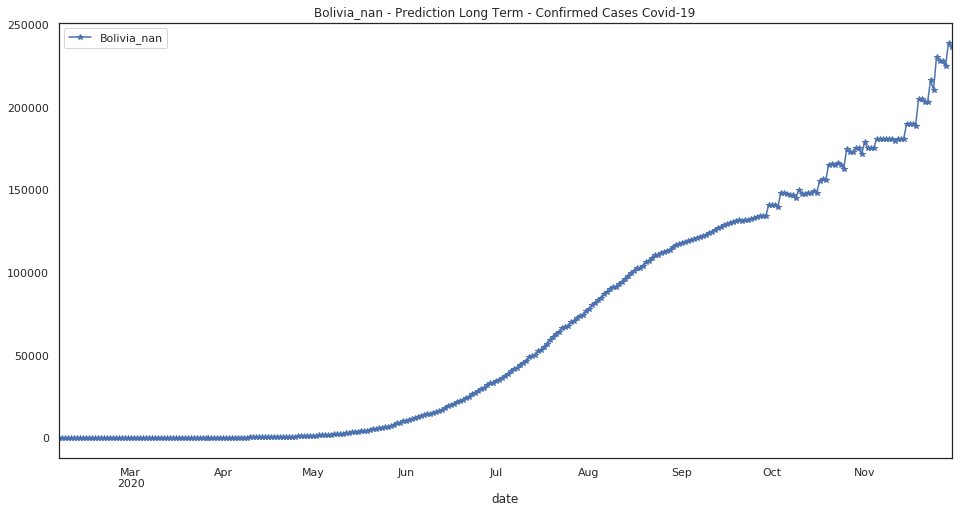

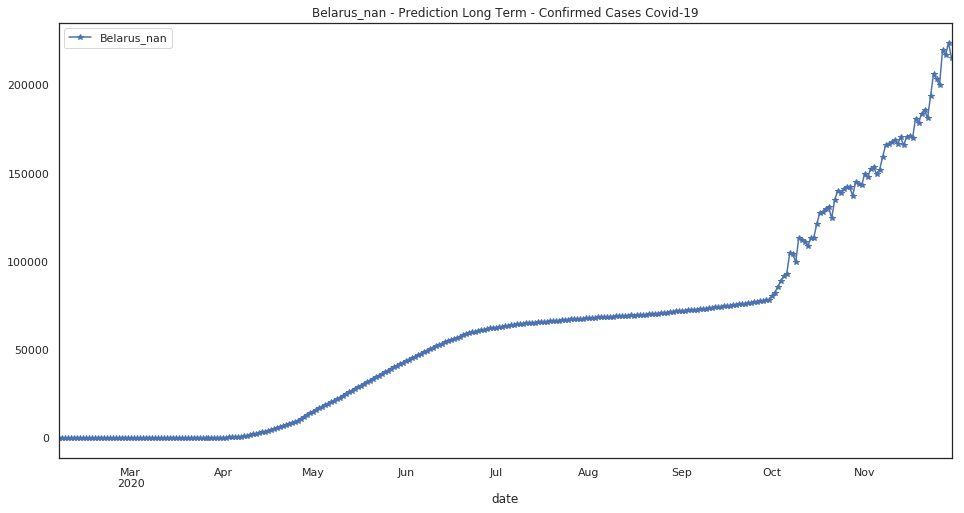

In [76]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

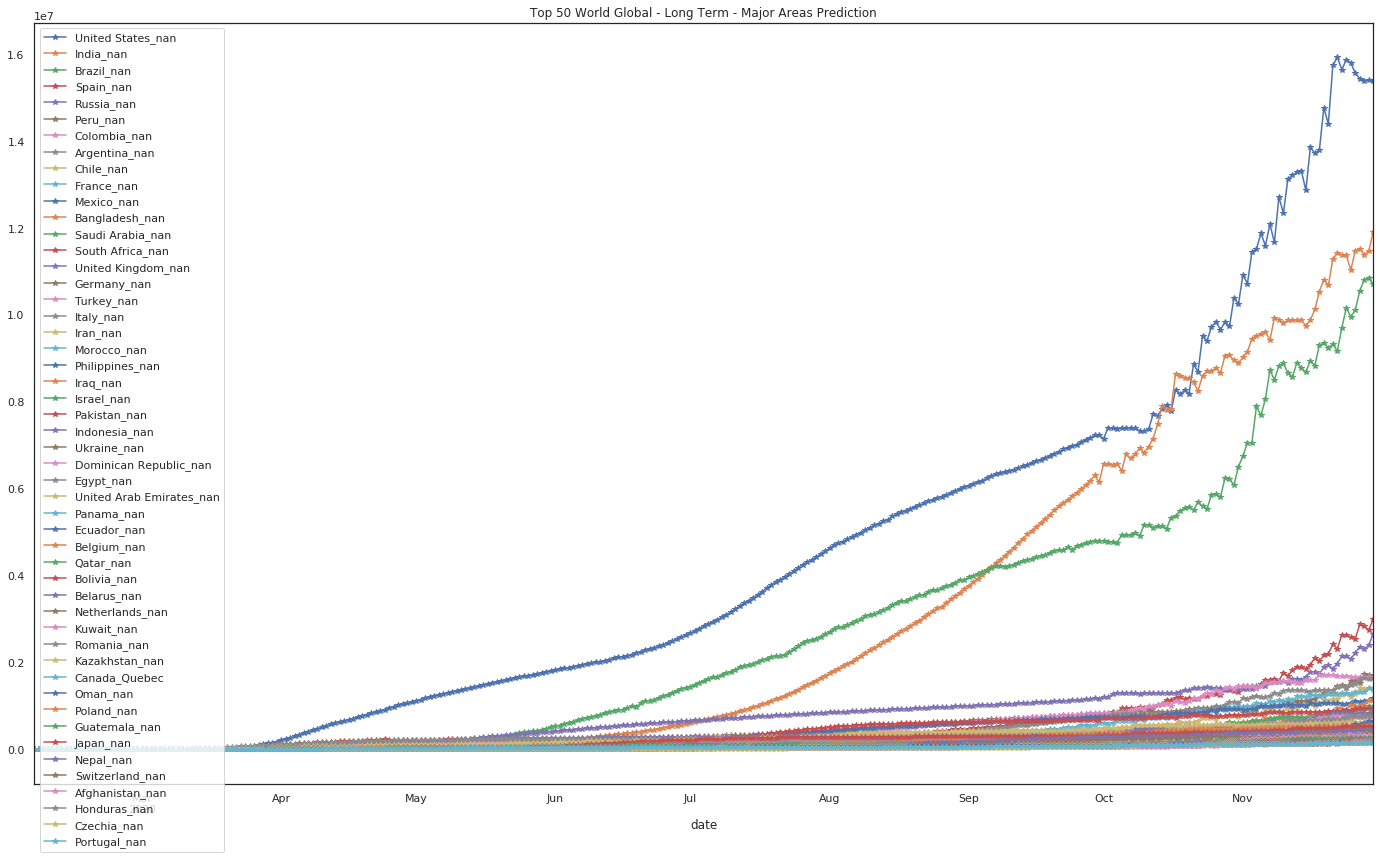

In [77]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

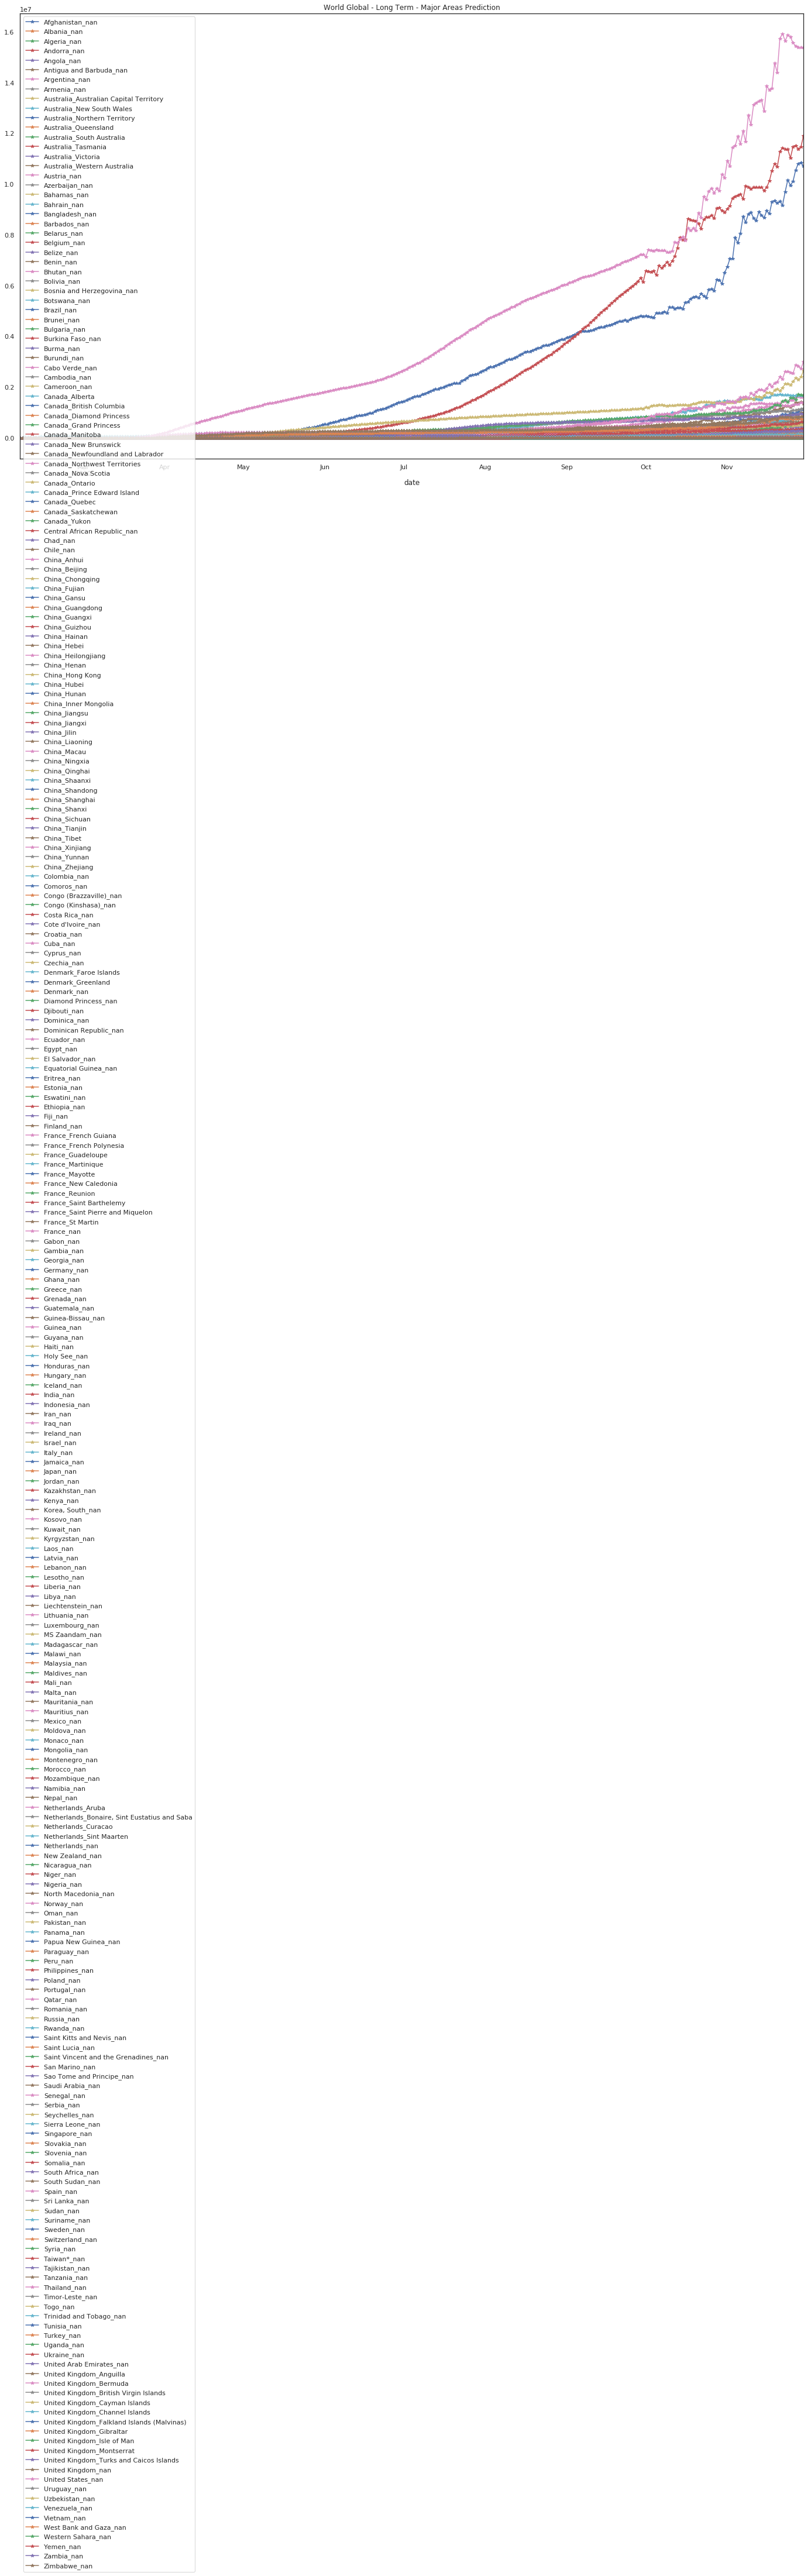

In [78]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [79]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [80]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-03-22             45.0         83.0        147.0        202.0   
2020-03-23             72.0         96.0        246.0        266.0   
2020-03-24             46.0        107.0        277.0        226.0   
2020-03-25            103.0        126.0        321.0        177.0   
2020-03-26            123.0        149.0        350.0        200.0   
2020-03-27            130.0        196.0        445.0        232.0   
2020-03-28            167.0        214.0        499.0        279.0   
2020-03-29            163.0        227.0        529.0        337.0   
2020-03-30            134.0        248.0        571.0        357.0   
2020-03-31            232.0        250.0        603.0        424.0   
2020-04-01            176.0        271.0        750.0        423.0   
2020-04-02            266.0        282.0        891.0        415.0   
2020-04-03            341.0        287.0       1003.0        473.0   
2020-04-04            338.0        316.0       1316.0        457.0   
2020-04-05            347.0        349.0       1436.0        467.0   
2020-04-06            434.0        390.0       1500.0        513.0   
2020-04-07            407.0        419.0       1684.0        532.0   
2020-04-08            501.0        417.0       1657.0        560.0   
2020-04-09            498.0        443.0       1747.0        584.0   
2020-04-10            536.0        453.0       1826.0        597.0   
2020-04-11            592.0        443.0       1899.0        633.0   
2020-04-12            614.0        458.0       1948.0        601.0   
2020-04-13            658.0        458.0       2062.0        651.0   
2020-04-14            734.0        488.0       2110.0        652.0   
2020-04-15            759.0        490.0       2205.0        659.0   
2020-04-16            854.0        504.0       2274.0        687.0   
2020-04-17            909.0        535.0       2342.0        673.0   
2020-04-18           1015.0        568.0       2524.0        696.0   
2020-04-19           1022.0        573.0       2672.0        708.0   
2020-04-20           1114.0        583.0       2779.0        713.0   
...                     ...          ...          ...          ...   
2020-11-01          94369.0      17351.0      58387.0       3005.0   
2020-11-02         104678.0      18802.0      58390.0       3005.0   
2020-11-03         104095.0      18362.0      58393.0       3171.0   
2020-11-04         108137.0      19258.0      58157.0       3138.0   
2020-11-05         108910.0      19092.0      58431.0       3349.0   
2020-11-06         105575.0      20643.0      59080.0       3496.0   
2020-11-07         114337.0      20473.0      59093.0       3496.0   
2020-11-08         119564.0      21191.0      59172.0       3496.0   
2020-11-09         114110.0      21512.0      58744.0       3717.0   
2020-11-10         125306.0      21326.0      60298.0       3646.0   
2020-11-11         125254.0      21014.0      59689.0       3763.0   
2020-11-12         120962.0      21954.0      61508.0       3734.0   
2020-11-13         129724.0      23242.0      61433.0       3936.0   
2020-11-14         136682.0      23327.0      61981.0       4053.0   
2020-11-15         140904.0      23391.0      62310.0       4053.0   
2020-11-16         142838.0      23535.0      62314.0       4109.0   
2020-11-17         137092.0      23535.0      61502.0       4145.0   
2020-11-18         148515.0      23447.0      62710.0       4130.0   
2020-11-19         148671.0      23091.0      62272.0       4130.0   
2020-11-20         145995.0      22785.0      62275.0       4130.0   
2020-11-21         145225.0      23789.0      62337.0       4130.0   
2020-11-22         142151.0      23731.0      62340.0       4130.0   
2020-11-23         144881.0      24535.0      62344.0       4130.0   
2020-11-24         149540.0      24456.0      62347.0       4130.0   
2020-11-25

In [81]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [82]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [83]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [84]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
238                                Thailand_nan  15.870032  100.992541   
239                             Timor-Leste_nan  -8.874217  125.727539   
240                                    Togo_nan   8.619500    0.824800   
241                     Trinidad and Tobago_nan  10.691800  -61.222500   
242                                 Tunisia_nan  33.886917    9.537499   
243                                  Turkey_nan  38.963700   35.243300   
244                           United States_nan  40.000000 -100.000000   
245                                  Uganda_nan   1.373333   32.290275   
246                                 Ukraine_nan  48.379400   31.165600   
247                    United Arab Emirates_nan  23.424076   53.847818   
248                     United Kingdom_Anguilla  18.220600  -63.068600   
249                      United Kingdom_Bermuda  32.307800  -64.750500   
250       United Kingdom_British Virgin Islands  18.420700  -64.640000   
251               United Kingdom_Cayman Islands  19.313300  -81.254600   
252              United Kingdom_Channel Islands  49.372300   -2.364400   
253  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
254                    United Kingdom_Gibraltar  36.140800   -5.353600   
255                  United Kingdom_Isle of Man  54.236100   -4.548100   
256                   United Kingdom_Montserrat  16.742498  -62.187366   
257     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
258                          United Kingdom_nan  55.378100   -3.436000   
259                                 Uruguay_nan -32.522800  -55.765800   
260                              Uzbekistan_n

In [85]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [86]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       0           Afghanistan_nan  33.939110   67.709953   
1       6             Argentina_nan -38.416100  -63.616700   
2      20            Bangladesh_nan  23.685000   90.356300   
3      22               Belarus_nan  53.709800   27.953400   
4      23               Belgium_nan  50.833300    4.469936   
5      27               Bolivia_nan -16.290200  -63.588700   
6      30                Brazil_nan -14.235000  -51.925300   
7      50             Canada_Quebec  52.939900  -73.549100   
8      55                 Chile_nan -35.675100  -71.543000   
9      89              Colombia_nan   4.570900  -74.297300   
10     98               Czechia_nan  49.817500   15.473000   
11    105    Dominican Republic_nan  18.735700  -70.162700   
12    106               Ecuador_nan  -1.831200  -78.183400   
13    107                 Egypt_nan  26.820553   30.802498   
14    126                France_nan  46.227600    2.213700   
15    131               Germany_nan  51.165691   10.451526   
16    135             Guatemala_nan  15.783500  -90.230800   
17    141              Honduras_nan  15.200000  -86.241900   
18    144                 India_nan  20.593684   78.962880   
19    145             Indonesia_nan  -0.789300  113.921300   
20    146                  Iran_nan  32.427908   53.688046   
21    147                  Iraq_nan  33.223191   43.679291   
22    149                Israel_nan  31.046051   34.851612   
23    150                 Italy_nan  41.871940   12.567380   
24    152                 Japan_nan  36.204824  138.252924   
25    154            Kazakhstan_nan  48.019600   66.923700   
26    158                Kuwait_nan  29.311660   47.481766   
27    179                Mexico_nan  23.634500 -102.552800   
28    184               Morocco_nan  31.791700   -7.092600   
29    187                 Nepal_nan  28.166700   84.250000   
30    192           Netherlands_nan  52.132600    5.291300   
31    196               Nigeria_nan   9.082000    8.675300   
32    199                  Oman_nan  21.512583   55.923255   
33    200              Pakistan_nan  30.375300   69.345100   
34    201                Panama_nan   8.538000  -80.782100   
35    204                  Peru_nan  -9.190000  -75.015200   
36    205           Philippines_nan  12.879721  121.774017   
37    206                Poland_nan  51.919400   19.145100   
38    207              Portugal_nan  39.399900   -8.224500   
39    208                 Qatar_nan  25.354800   51.183900   
40    209               Romania_nan  45.943200   24.966800   
41    210                Russia_nan  61.524010  105.318756   
42    217          Saudi Arabia_nan  23.885942   45.079162   
43    226          South Africa_nan -30.559500   22.937500   
44    228                 Spain_nan  40.463667   -3.749220   
45    233           Switzerland_nan  46.818200    8.227500   
46    243                Turkey_nan  38.963700   35.243300   
47    244         United States_nan  40.000000 -100.000000   
48    246               Ukraine_nan  48.379400   31.165600   
49    247  United Arab Emirates_nan  23.424076   53.847818   
50    258        United Kingdom_nan  55.378100   -3.436000   
51    261             Venezuela_nan   6.423800  -66.589700   

    2020-02-06 00:00:00  2020-02-07 00:00:00  2020-02-08 00:00:00  \
0                  11.0                 11.0                 11.0   
1                  11.0                 11.0                 11.0   
2                  11.0                 11.0                 11.0   
3                  11.0                 11.0                 11.0   
4                  25.0                 30.0                 14.0   
5                  11.0                 11.0                 11.0   
6                  11.0                 11.0                 11.0   
7                  11.0                 11.0                 11.0   
8                  11.0                 11.0                 11.0   
9                  11.0    

In [87]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=3)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [88]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [89]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [90]:
exit()